In [1]:
import numpy as np
import pandas as pd
import os
import argparse
import logging

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.autograd import Variable
from torch.utils.data.dataset import Dataset
from torch.utils.data import DataLoader

from capstone_project.preprocessing import generate_dataloaders, load_data, split_data
from capstone_project.models.embedding_network import EmbeddingNetwork
from capstone_project.models.classification_network import ClassificationNetwork
from capstone_project.utils import *

import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
%matplotlib inline



In [2]:
PROJECT_DIR = '/home/kyt237/learning_visual_embeddings/'
DATA_DIR,  PLOTS_DIR, LOGGING_DIR = 'data', 'plots', 'logs'
CHECKPOINTS_DIR = 'checkpoints'
DATASET = 'mnist_test_seq.npy'
TEST_SIZE, VAL_SIZE = 0.2, 0.2

BATCH_SIZE = 64    # input batch size for training
N_EPOCHS = 100     # number of epochs to train
LR = 1e-4          # learning rate
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

NUM_PASSES_FOR_GENERATION = 1   # number of passes through data for pair generation
NUM_FRAMES_IN_STACK = 2         # number of (total) frames to concatenate for each video
NUM_PAIRS_PER_EXAMPLE = 5        # number of pairs to generate for given video and time difference
TIME_BUCKETS = [[0], [1], [2], [3,4], range(5,11,1)]

RS = 20150101 # Random state

In [3]:
import torch
import torch.nn as nn


def conv3x3(in_channels, out_channels, stride=1, padding=1, bias=False):
    return nn.Conv2d(in_channels, out_channels, kernel_size=3,
                     stride=stride, padding=padding, bias=bias)


# Residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(ResidualBlock, self).__init__()
        self.conv1 = conv3x3(in_channels, out_channels, stride)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.conv2 = conv3x3(out_channels, out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample

    def forward(self, input):
        residual = input
        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)
        output = self.conv2(output)
        output = self.bn2(output)
        if self.downsample:
            residual = self.downsample(input)
        output += residual
        output = self.relu(output)
        return output


class EmbeddingNetwork(nn.Module):
    def __init__(self, in_dim, in_channels, hidden_size, out_dim, block=ResidualBlock, num_blocks=3):
        super(EmbeddingNetwork, self).__init__()
        self.in_dim = in_dim
        self.in_channels = in_channels

        # Conv-ReLU layers with batch-norm and downsampling
#         self.conv1 = conv3x3(in_channels, 32)
        self.conv1 = conv3x3(in_channels, 32, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn1 = nn.BatchNorm2d(32)
#         self.conv2 = conv3x3(32, 64)
        self.conv2 = conv3x3(32, 64, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn2 = nn.BatchNorm2d(64)
#         self.conv3 = conv3x3(64, 64)
        self.conv3 = conv3x3(64, 64, stride=2)  # NOTE: Use pool in _get_fc_input_size if using this
        self.bn3 = nn.BatchNorm2d(64)
        self.pool = nn.MaxPool2d(2)
        self.relu = nn.ReLU(inplace=True)

        # Residual layers
        self.residual_layers = self._make_layer(block, 64, 64, num_blocks)

        # Automatically get dimension of FC layer by using dummy input
        fc1_input_size = self._get_fc_input_size()
        print(fc1_input_size)

        # Fully connected layers
        self.fc1 = nn.Linear(fc1_input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, out_dim)

        # Initialize weights
        self._init_weights()

    def forward(self, input):
        # Reshape input to batch_size x in_channels x height x width
        input = input.view(-1, self.in_channels, self.in_dim, self.in_dim)

        output = self.conv1(input)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.conv2(output)
        output = self.bn2(output)
        output = self.relu(output)
#         output = self.pool(output) # NOTE: Use pool in _get_fc_input_size if using it here

        output = self.conv3(output)
        output = self.bn3(output)
        output = self.relu(output)
#         output = self.pool(output) # NOTE: Use pool in _get_fc_input_size if using it here

        # output = self.residual_layers(output)

        output = output.view(output.size(0), -1)
        output = self.fc1(output)
        output = self.fc2(output)
        output_n = torch.norm(output, p=2, dim=1, keepdim=True)
        output = output.div(output_n.expand_as(output))
        return output

    def _make_layer(self, block, in_channels, out_channels, num_blocks, stride=1, downsample=None):
        if (not downsample) and ((stride != 1) or (in_channels != out_channels)):
            downsample = nn.Sequential(conv3x3(in_channels, out_channels, stride=stride), nn.BatchNorm2d(out_channels))

        layers = [block(in_channels, out_channels, stride, downsample)]
        for i in range(num_blocks-1):
            # For residual blocks, in_channels = out_channels
            layers.append(block(out_channels, out_channels))

        return nn.Sequential(*layers)

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.xavier_normal_(m.weight)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight)
                nn.init.uniform_(m.bias)

    def _get_fc_input_size(self):
        layers = nn.Sequential(self.conv1,
                            self.bn1,
                            self.relu,
                            self.conv2,
                            self.bn2,
                            self.relu,
#                             self.pool,
                            self.conv3,
                            self.bn3,
                            self.relu,
#                             self.pool,
                            self.residual_layers
                )

        with torch.no_grad():
            dummy_input = torch.zeros([1, self.in_channels, self.in_dim, self.in_dim]).float()
            dummy_output = layers(dummy_input)
            fc_size = dummy_output.flatten(0).shape[0]

        return fc_size

In [4]:
DATASET = 'moving_bars_20_121.npy'
data = load_data(PROJECT_DIR, DATA_DIR, DATASET)
data = split_data(data, VAL_SIZE, TEST_SIZE, PROJECT_DIR, DATA_DIR)['train']

In [5]:
img_dim = data.shape[-1]
in_dim = img_dim
in_dim, in_channels, out_dim = img_dim, NUM_FRAMES_IN_STACK, 1024
embedding_hidden_size, classification_hidden_size = 1024, 1024
num_outputs = len(TIME_BUCKETS)

In [6]:
class EmbeddingDataset(Dataset):
    def __init__(self, X, num_frames_in_stack, transforms=None):
        self.X = X
        self.transforms = transforms
        self.num_frames_in_stack = num_frames_in_stack
        self.seq_len = X.shape[1]

    def __getitem__(self, index):
        video = self.X[index]
        stacked_frames = []
        
        for frame in range(self.num_frames_in_stack-1, self.seq_len):
            frame_numbers = np.array(range(frame-self.num_frames_in_stack+1, frame+1))
            frames = video[frame_numbers]
            if self.transforms:
                frames = self.transforms(frames)
            stacked_frames.append(frames)
            
        return torch.from_numpy(np.array(stacked_frames)) # torch.from_numpy uses same memory

    def __len__(self):
        return len(self.X)

In [7]:
def get_embeddings(embedding_network, dataloader, device):
    all_embeddings = np.array([])
    all_videos = np.array([])
    embedding_network.eval()
    with torch.no_grad():
        for batch_idx, all_stacked_frames in enumerate(dataloader):
            # Reshape (64,19,2,121,121) -> (19,64,2,121,121)
            all_stacked_frames = all_stacked_frames.numpy().swapaxes(0, 1)
            all_stacked_frames = torch.from_numpy(all_stacked_frames).to(DEVICE).float()
            embeddings = []
            videos = np.array([])
            for stacked_frames in all_stacked_frames:
                embedding_output = embedding_network(stacked_frames).detach().cpu().numpy()
                embeddings.append(embedding_output)
                
                frames = stacked_frames.detach().cpu().numpy().swapaxes(0, 1) # (2,64,121,121)
                last_frame = np.array([frames[-1]])
                videos = np.vstack((videos, last_frame)) if videos.size else last_frame
            embeddings = np.array(embeddings).swapaxes(0, 1)
            all_embeddings = np.vstack((all_embeddings, embeddings)) if all_embeddings.size else embeddings
            
            videos = videos.swapaxes(0, 1)
            all_videos = np.vstack((all_videos, videos)) if all_videos.size else np.array(videos)
    return all_embeddings, all_videos

In [8]:
embedding_network = EmbeddingNetwork(in_dim, in_channels, embedding_hidden_size, out_dim).to(DEVICE)
classification_network = ClassificationNetwork(out_dim, classification_hidden_size, num_outputs).to(DEVICE)

16384


In [9]:
embedding_dataset = EmbeddingDataset(data, NUM_FRAMES_IN_STACK)

In [10]:
dataloader = DataLoader(embedding_dataset, batch_size=64, shuffle=False, num_workers=4)

In [11]:
embeddings_bars, videos_bars = get_embeddings(embedding_network, dataloader, DEVICE)

In [12]:
embeddings_bars.shape

(146, 19, 1024)

In [13]:
videos_bars.shape

(146, 19, 121, 121)

In [14]:
embeddings_bars = embeddings_bars.reshape((-1,1024))

In [15]:
embeddings_bars.shape

(2774, 1024)

In [16]:
videos_bars = videos_bars.reshape((-1,121,121))

In [17]:
videos_bars.shape

(2774, 121, 121)

In [18]:
class DecoderDataset(Dataset):
    def __init__(self, X_embed, target_img, transforms=None):
        self.X_embed = X_embed
        self.target_img = target_img

    def __getitem__(self, index):
        return torch.from_numpy(self.X_embed[index]), torch.from_numpy(self.target_img[index])

    def __len__(self):
        return len(self.X_embed)

In [19]:
class DecoderNetwork(nn.Module):
    def __init__(self, emb_size,hidden_size):
        super(DecoderNetwork, self).__init__()
        self.emb_size,self.hidden_size = emb_size,hidden_size
        # Deconv layers
        self.deconv1 = nn.ConvTranspose2d(in_channels=64,out_channels=64,stride=2,padding=1,kernel_size=3,bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.deconv2 = nn.ConvTranspose2d(in_channels=64,out_channels=32,stride=2,padding=1,kernel_size=3,bias=False)
        self.bn2 = nn.BatchNorm2d(32)
        self.deconv3 = nn.ConvTranspose2d(in_channels=32,out_channels=1,stride=2,padding=1,kernel_size=3,bias=False)
        self.relu = nn.ReLU(inplace=True)
        self.tanh = nn.Tanh()
        self.sigmoid = nn.Sigmoid()
        self.fc1 = nn.Linear(emb_size,hidden_size)
        self.fc2 = nn.Linear(hidden_size,64*16*16)
        # Initialize weights
        self._init_weights()

    def forward(self, input):
        output = self.fc1(input)
        output = self.fc2(output)
        output = output.view(output.size(0),64,16,16)
        output = self.deconv1(output)
        output = self.bn1(output)
        output = self.relu(output)

        output = self.deconv2(output)
        output = self.bn2(output)
        output = self.relu(output)

        output = self.deconv3(output)
        #output = self.tanh(output)
        #trying to use a BCE loss and hence returning the outputs using a sigmoid
        output = self.sigmoid(output)
        return output.squeeze()

    def _init_weights(self):
        for m in self.modules():
            classname = m.__class__.__name__
            if classname.find('Conv') != -1:
                m.weight.data.normal_(0.0, 0.02)
            elif classname.find('BatchNorm') != -1:
                m.weight.data.normal_(1.0, 0.02)
                m.bias.data.fill_(0)


In [20]:
train_decoder_dataset = DecoderDataset(embeddings_bars,videos_bars)
train_decoder_dataloader = DataLoader(train_decoder_dataset, batch_size=64, shuffle=False)

In [21]:
def train(decoder_network, dataloader, criterion, optimizer, device, epoch):
    loss_train = 0.
    for batch_idx, (x_embed, target_img) in enumerate(dataloader):
        x_embed, target_img = x_embed.to(device).float(), target_img.to(device).float()
        decoder_network.train()

        optimizer.zero_grad()

        gen_img = decoder_network(x_embed)
        #assert (gen_img.view(-1,121*121) >= 0. & gen_img.view(-1,121*121) <= 1.).all()
        #assert (target_img.view(-1,121*121) >= 0. & target_img.view(-1,121*121) <= 1.).all()


        loss = criterion(gen_img.view(-1,121*121), target_img.view(-1,target_img.size(1)*target_img.size(1)))
        loss.backward()
        optimizer.step()
        #print(len(dataloader.dataset))
        # Accurately compute loss, because of different batch size
        loss_train += loss.item() * len(x_embed) / len(dataloader.dataset)

        if (batch_idx+1) % (len(dataloader.dataset)//(20*target_img.shape[0])) == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (batch_idx+1) * target_img.shape[0], len(dataloader.dataset),
                100. * (batch_idx+1) / len(dataloader), loss.item()))

    optimizer.zero_grad()
    return loss_train,gen_img.detach().cpu().numpy()

# def test(embedding_network, classification_network, dataloader, criterion, device):
#     embedding_network.eval()
#     classification_network.eval()
#     loss_test = 0.
#     y_ls = []
#     output_ls = []
#     with torch.no_grad():
#         for batch_idx, (x1, x2, y, differences, frame_numbers) in enumerate(dataloader):
#             x1, x2, y = x1.to(device).float(), x2.to(device).float(), y.to(device).long()
#             embedding_output1 = embedding_network(x1)
#             embedding_output2 = embedding_network(x2)
#             classification_output = classification_network(embedding_output1, embedding_output2)
#             loss = criterion(classification_output, y)

#             # Accurately compute loss, because of different batch size
#             loss_test += loss.item() / len(dataloader.dataset)

#             output_ls.append(classification_output)
#             y_ls.append(y)
#     return loss_test, torch.cat(output_ls, dim=0), torch.cat(y_ls, dim=0)


In [22]:
DEVICE = 'cuda:0' if torch.cuda.is_available() else 'cpu'

In [23]:
#DEVICE = 'cpu'

In [30]:
N_EPOCHS = 1000

In [31]:
criterion = nn.BCELoss(reduction='sum')
criterion_test = nn.BCELoss(reduction='sum')
decoder_network = DecoderNetwork(emb_size=embeddings_bars.shape[1],hidden_size=1024).to(DEVICE)
optimizer = optim.Adam(decoder_network.parameters(), lr=LR)

for epoch in range(N_EPOCHS):
    train_loss,gen_img_temp = train(decoder_network,train_decoder_dataloader,criterion,optimizer,DEVICE,epoch)
    print('TRAIN Epoch: {}\tAverage loss: {:.4f}'.format(epoch, train_loss))

    

Train Epoch: 0 [128/2774 (5%)]	Loss: 653602.375000
Train Epoch: 0 [256/2774 (9%)]	Loss: 648281.062500
Train Epoch: 0 [384/2774 (14%)]	Loss: 643849.562500
Train Epoch: 0 [512/2774 (18%)]	Loss: 639864.312500
Train Epoch: 0 [640/2774 (23%)]	Loss: 636213.750000
Train Epoch: 0 [768/2774 (27%)]	Loss: 632749.125000
Train Epoch: 0 [896/2774 (32%)]	Loss: 629358.250000
Train Epoch: 0 [1024/2774 (36%)]	Loss: 626173.875000
Train Epoch: 0 [1152/2774 (41%)]	Loss: 623039.125000
Train Epoch: 0 [1280/2774 (45%)]	Loss: 619956.812500
Train Epoch: 0 [1408/2774 (50%)]	Loss: 616986.812500
Train Epoch: 0 [1536/2774 (55%)]	Loss: 614065.187500
Train Epoch: 0 [1664/2774 (59%)]	Loss: 611172.687500
Train Epoch: 0 [1792/2774 (64%)]	Loss: 608369.875000
Train Epoch: 0 [1920/2774 (68%)]	Loss: 605563.625000
Train Epoch: 0 [2048/2774 (73%)]	Loss: 602710.750000
Train Epoch: 0 [2176/2774 (77%)]	Loss: 599978.125000
Train Epoch: 0 [2304/2774 (82%)]	Loss: 597201.250000
Train Epoch: 0 [2432/2774 (86%)]	Loss: 594527.437500
Tr

Train Epoch: 7 [768/2774 (27%)]	Loss: 311213.843750
Train Epoch: 7 [896/2774 (32%)]	Loss: 309522.718750
Train Epoch: 7 [1024/2774 (36%)]	Loss: 308310.031250
Train Epoch: 7 [1152/2774 (41%)]	Loss: 306922.500000
Train Epoch: 7 [1280/2774 (45%)]	Loss: 305447.437500
Train Epoch: 7 [1408/2774 (50%)]	Loss: 304254.218750
Train Epoch: 7 [1536/2774 (55%)]	Loss: 302850.750000
Train Epoch: 7 [1664/2774 (59%)]	Loss: 301556.062500
Train Epoch: 7 [1792/2774 (64%)]	Loss: 300379.781250
Train Epoch: 7 [1920/2774 (68%)]	Loss: 298927.750000
Train Epoch: 7 [2048/2774 (73%)]	Loss: 297650.687500
Train Epoch: 7 [2176/2774 (77%)]	Loss: 296464.812500
Train Epoch: 7 [2304/2774 (82%)]	Loss: 294942.187500
Train Epoch: 7 [2432/2774 (86%)]	Loss: 293738.625000
Train Epoch: 7 [2560/2774 (91%)]	Loss: 292465.125000
Train Epoch: 7 [2688/2774 (95%)]	Loss: 291101.656250
TRAIN Epoch: 7	Average loss: 302763.9519
Train Epoch: 8 [128/2774 (5%)]	Loss: 288658.968750
Train Epoch: 8 [256/2774 (9%)]	Loss: 287927.375000
Train Epoch

Train Epoch: 14 [1536/2774 (55%)]	Loss: 171471.000000
Train Epoch: 14 [1664/2774 (59%)]	Loss: 171010.796875
Train Epoch: 14 [1792/2774 (64%)]	Loss: 170622.265625
Train Epoch: 14 [1920/2774 (68%)]	Loss: 169913.000000
Train Epoch: 14 [2048/2774 (73%)]	Loss: 169467.500000
Train Epoch: 14 [2176/2774 (77%)]	Loss: 169119.875000
Train Epoch: 14 [2304/2774 (82%)]	Loss: 168220.156250
Train Epoch: 14 [2432/2774 (86%)]	Loss: 167809.625000
Train Epoch: 14 [2560/2774 (91%)]	Loss: 167287.375000
Train Epoch: 14 [2688/2774 (95%)]	Loss: 166657.671875
TRAIN Epoch: 14	Average loss: 171253.2483
Train Epoch: 15 [128/2774 (5%)]	Loss: 165660.890625
Train Epoch: 15 [256/2774 (9%)]	Loss: 165792.750000
Train Epoch: 15 [384/2774 (14%)]	Loss: 164950.921875
Train Epoch: 15 [512/2774 (18%)]	Loss: 164408.859375
Train Epoch: 15 [640/2774 (23%)]	Loss: 164120.375000
Train Epoch: 15 [768/2774 (27%)]	Loss: 163516.593750
Train Epoch: 15 [896/2774 (32%)]	Loss: 162777.062500
Train Epoch: 15 [1024/2774 (36%)]	Loss: 162367.28

Train Epoch: 21 [2304/2774 (82%)]	Loss: 112014.335938
Train Epoch: 21 [2432/2774 (86%)]	Loss: 111968.453125
Train Epoch: 21 [2560/2774 (91%)]	Loss: 111651.171875
Train Epoch: 21 [2688/2774 (95%)]	Loss: 111244.867188
TRAIN Epoch: 21	Average loss: 113523.2994
Train Epoch: 22 [128/2774 (5%)]	Loss: 110906.531250
Train Epoch: 22 [256/2774 (9%)]	Loss: 111386.703125
Train Epoch: 22 [384/2774 (14%)]	Loss: 110671.609375
Train Epoch: 22 [512/2774 (18%)]	Loss: 110332.859375
Train Epoch: 22 [640/2774 (23%)]	Loss: 110317.289062
Train Epoch: 22 [768/2774 (27%)]	Loss: 109904.203125
Train Epoch: 22 [896/2774 (32%)]	Loss: 109421.953125
Train Epoch: 22 [1024/2774 (36%)]	Loss: 109407.937500
Train Epoch: 22 [1152/2774 (41%)]	Loss: 109049.359375
Train Epoch: 22 [1280/2774 (45%)]	Loss: 108604.695312
Train Epoch: 22 [1408/2774 (50%)]	Loss: 108531.804688
Train Epoch: 22 [1536/2774 (55%)]	Loss: 108353.398438
Train Epoch: 22 [1664/2774 (59%)]	Loss: 108284.812500
Train Epoch: 22 [1792/2774 (64%)]	Loss: 108039.43

Train Epoch: 29 [256/2774 (9%)]	Loss: 83528.398438
Train Epoch: 29 [384/2774 (14%)]	Loss: 82647.773438
Train Epoch: 29 [512/2774 (18%)]	Loss: 82577.601562
Train Epoch: 29 [640/2774 (23%)]	Loss: 82573.921875
Train Epoch: 29 [768/2774 (27%)]	Loss: 82722.734375
Train Epoch: 29 [896/2774 (32%)]	Loss: 81920.585938
Train Epoch: 29 [1024/2774 (36%)]	Loss: 82283.531250
Train Epoch: 29 [1152/2774 (41%)]	Loss: 81804.421875
Train Epoch: 29 [1280/2774 (45%)]	Loss: 81279.062500
Train Epoch: 29 [1408/2774 (50%)]	Loss: 81508.148438
Train Epoch: 29 [1536/2774 (55%)]	Loss: 81422.570312
Train Epoch: 29 [1664/2774 (59%)]	Loss: 81273.820312
Train Epoch: 29 [1792/2774 (64%)]	Loss: 81268.546875
Train Epoch: 29 [1920/2774 (68%)]	Loss: 80852.664062
Train Epoch: 29 [2048/2774 (73%)]	Loss: 81164.695312
Train Epoch: 29 [2176/2774 (77%)]	Loss: 81372.546875
Train Epoch: 29 [2304/2774 (82%)]	Loss: 80201.429688
Train Epoch: 29 [2432/2774 (86%)]	Loss: 80521.195312
Train Epoch: 29 [2560/2774 (91%)]	Loss: 80354.515625


Train Epoch: 36 [1024/2774 (36%)]	Loss: 65085.156250
Train Epoch: 36 [1152/2774 (41%)]	Loss: 65195.734375
Train Epoch: 36 [1280/2774 (45%)]	Loss: 64111.609375
Train Epoch: 36 [1408/2774 (50%)]	Loss: 64871.367188
Train Epoch: 36 [1536/2774 (55%)]	Loss: 64936.183594
Train Epoch: 36 [1664/2774 (59%)]	Loss: 64289.953125
Train Epoch: 36 [1792/2774 (64%)]	Loss: 64477.167969
Train Epoch: 36 [1920/2774 (68%)]	Loss: 64373.875000
Train Epoch: 36 [2048/2774 (73%)]	Loss: 64246.113281
Train Epoch: 36 [2176/2774 (77%)]	Loss: 64886.953125
Train Epoch: 36 [2304/2774 (82%)]	Loss: 64171.527344
Train Epoch: 36 [2432/2774 (86%)]	Loss: 63858.187500
Train Epoch: 36 [2560/2774 (91%)]	Loss: 63663.574219
Train Epoch: 36 [2688/2774 (95%)]	Loss: 63866.203125
TRAIN Epoch: 36	Average loss: 64554.0934
Train Epoch: 37 [128/2774 (5%)]	Loss: 63011.078125
Train Epoch: 37 [256/2774 (9%)]	Loss: 64061.500000
Train Epoch: 37 [384/2774 (14%)]	Loss: 64002.242188
Train Epoch: 37 [512/2774 (18%)]	Loss: 64151.238281
Train Epoch

Train Epoch: 43 [1792/2774 (64%)]	Loss: 51452.945312
Train Epoch: 43 [1920/2774 (68%)]	Loss: 50940.164062
Train Epoch: 43 [2048/2774 (73%)]	Loss: 51167.574219
Train Epoch: 43 [2176/2774 (77%)]	Loss: 51430.148438
Train Epoch: 43 [2304/2774 (82%)]	Loss: 50900.425781
Train Epoch: 43 [2432/2774 (86%)]	Loss: 51108.406250
Train Epoch: 43 [2560/2774 (91%)]	Loss: 51648.925781
Train Epoch: 43 [2688/2774 (95%)]	Loss: 50993.753906
TRAIN Epoch: 43	Average loss: 51741.7631
Train Epoch: 44 [128/2774 (5%)]	Loss: 51224.304688
Train Epoch: 44 [256/2774 (9%)]	Loss: 51308.007812
Train Epoch: 44 [384/2774 (14%)]	Loss: 51514.035156
Train Epoch: 44 [512/2774 (18%)]	Loss: 51043.726562
Train Epoch: 44 [640/2774 (23%)]	Loss: 51064.230469
Train Epoch: 44 [768/2774 (27%)]	Loss: 50966.843750
Train Epoch: 44 [896/2774 (32%)]	Loss: 50959.722656
Train Epoch: 44 [1024/2774 (36%)]	Loss: 50662.113281
Train Epoch: 44 [1152/2774 (41%)]	Loss: 50231.156250
Train Epoch: 44 [1280/2774 (45%)]	Loss: 50662.734375
Train Epoch: 4

Train Epoch: 50 [2432/2774 (86%)]	Loss: 43723.613281
Train Epoch: 50 [2560/2774 (91%)]	Loss: 43250.953125
Train Epoch: 50 [2688/2774 (95%)]	Loss: 42440.214844
TRAIN Epoch: 50	Average loss: 44029.3243
Train Epoch: 51 [128/2774 (5%)]	Loss: 42504.644531
Train Epoch: 51 [256/2774 (9%)]	Loss: 42945.304688
Train Epoch: 51 [384/2774 (14%)]	Loss: 42985.136719
Train Epoch: 51 [512/2774 (18%)]	Loss: 42858.312500
Train Epoch: 51 [640/2774 (23%)]	Loss: 42845.230469
Train Epoch: 51 [768/2774 (27%)]	Loss: 43042.898438
Train Epoch: 51 [896/2774 (32%)]	Loss: 42553.218750
Train Epoch: 51 [1024/2774 (36%)]	Loss: 42487.539062
Train Epoch: 51 [1152/2774 (41%)]	Loss: 42617.203125
Train Epoch: 51 [1280/2774 (45%)]	Loss: 42213.023438
Train Epoch: 51 [1408/2774 (50%)]	Loss: 42760.097656
Train Epoch: 51 [1536/2774 (55%)]	Loss: 42334.035156
Train Epoch: 51 [1664/2774 (59%)]	Loss: 41647.730469
Train Epoch: 51 [1792/2774 (64%)]	Loss: 42180.453125
Train Epoch: 51 [1920/2774 (68%)]	Loss: 41863.996094
Train Epoch: 5

Train Epoch: 58 [384/2774 (14%)]	Loss: 37682.199219
Train Epoch: 58 [512/2774 (18%)]	Loss: 37149.238281
Train Epoch: 58 [640/2774 (23%)]	Loss: 36981.417969
Train Epoch: 58 [768/2774 (27%)]	Loss: 36741.816406
Train Epoch: 58 [896/2774 (32%)]	Loss: 36627.863281
Train Epoch: 58 [1024/2774 (36%)]	Loss: 37193.347656
Train Epoch: 58 [1152/2774 (41%)]	Loss: 36286.199219
Train Epoch: 58 [1280/2774 (45%)]	Loss: 36644.078125
Train Epoch: 58 [1408/2774 (50%)]	Loss: 36748.804688
Train Epoch: 58 [1536/2774 (55%)]	Loss: 36620.945312
Train Epoch: 58 [1664/2774 (59%)]	Loss: 35824.839844
Train Epoch: 58 [1792/2774 (64%)]	Loss: 36833.503906
Train Epoch: 58 [1920/2774 (68%)]	Loss: 36249.597656
Train Epoch: 58 [2048/2774 (73%)]	Loss: 35952.046875
Train Epoch: 58 [2176/2774 (77%)]	Loss: 36209.441406
Train Epoch: 58 [2304/2774 (82%)]	Loss: 35754.089844
Train Epoch: 58 [2432/2774 (86%)]	Loss: 36478.234375
Train Epoch: 58 [2560/2774 (91%)]	Loss: 36632.011719
Train Epoch: 58 [2688/2774 (95%)]	Loss: 35889.83593

Train Epoch: 65 [1152/2774 (41%)]	Loss: 32218.960938
Train Epoch: 65 [1280/2774 (45%)]	Loss: 32473.169922
Train Epoch: 65 [1408/2774 (50%)]	Loss: 32187.179688
Train Epoch: 65 [1536/2774 (55%)]	Loss: 32153.246094
Train Epoch: 65 [1664/2774 (59%)]	Loss: 31698.863281
Train Epoch: 65 [1792/2774 (64%)]	Loss: 32119.421875
Train Epoch: 65 [1920/2774 (68%)]	Loss: 32304.271484
Train Epoch: 65 [2048/2774 (73%)]	Loss: 31894.035156
Train Epoch: 65 [2176/2774 (77%)]	Loss: 32207.886719
Train Epoch: 65 [2304/2774 (82%)]	Loss: 32469.445312
Train Epoch: 65 [2432/2774 (86%)]	Loss: 32635.585938
Train Epoch: 65 [2560/2774 (91%)]	Loss: 32341.167969
Train Epoch: 65 [2688/2774 (95%)]	Loss: 31957.335938
TRAIN Epoch: 65	Average loss: 32166.4870
Train Epoch: 66 [128/2774 (5%)]	Loss: 32231.306641
Train Epoch: 66 [256/2774 (9%)]	Loss: 32915.023438
Train Epoch: 66 [384/2774 (14%)]	Loss: 33257.410156
Train Epoch: 66 [512/2774 (18%)]	Loss: 33208.265625
Train Epoch: 66 [640/2774 (23%)]	Loss: 32660.376953
Train Epoch:

Train Epoch: 72 [1920/2774 (68%)]	Loss: 29105.582031
Train Epoch: 72 [2048/2774 (73%)]	Loss: 29195.406250
Train Epoch: 72 [2176/2774 (77%)]	Loss: 29558.853516
Train Epoch: 72 [2304/2774 (82%)]	Loss: 29087.425781
Train Epoch: 72 [2432/2774 (86%)]	Loss: 29444.253906
Train Epoch: 72 [2560/2774 (91%)]	Loss: 29011.404297
Train Epoch: 72 [2688/2774 (95%)]	Loss: 28628.152344
TRAIN Epoch: 72	Average loss: 29208.5618
Train Epoch: 73 [128/2774 (5%)]	Loss: 28618.449219
Train Epoch: 73 [256/2774 (9%)]	Loss: 30002.417969
Train Epoch: 73 [384/2774 (14%)]	Loss: 30392.449219
Train Epoch: 73 [512/2774 (18%)]	Loss: 30989.611328
Train Epoch: 73 [640/2774 (23%)]	Loss: 31462.644531
Train Epoch: 73 [768/2774 (27%)]	Loss: 29558.193359
Train Epoch: 73 [896/2774 (32%)]	Loss: 29931.554688
Train Epoch: 73 [1024/2774 (36%)]	Loss: 29952.699219
Train Epoch: 73 [1152/2774 (41%)]	Loss: 29821.171875
Train Epoch: 73 [1280/2774 (45%)]	Loss: 29857.503906
Train Epoch: 73 [1408/2774 (50%)]	Loss: 29063.298828
Train Epoch: 7

Train Epoch: 79 [2688/2774 (95%)]	Loss: 27246.687500
TRAIN Epoch: 79	Average loss: 28011.5937
Train Epoch: 80 [128/2774 (5%)]	Loss: 26474.191406
Train Epoch: 80 [256/2774 (9%)]	Loss: 26825.478516
Train Epoch: 80 [384/2774 (14%)]	Loss: 26418.849609
Train Epoch: 80 [512/2774 (18%)]	Loss: 26972.220703
Train Epoch: 80 [640/2774 (23%)]	Loss: 26868.730469
Train Epoch: 80 [768/2774 (27%)]	Loss: 26099.542969
Train Epoch: 80 [896/2774 (32%)]	Loss: 26377.791016
Train Epoch: 80 [1024/2774 (36%)]	Loss: 26497.085938
Train Epoch: 80 [1152/2774 (41%)]	Loss: 26449.333984
Train Epoch: 80 [1280/2774 (45%)]	Loss: 26578.365234
Train Epoch: 80 [1408/2774 (50%)]	Loss: 26347.148438
Train Epoch: 80 [1536/2774 (55%)]	Loss: 27552.412109
Train Epoch: 80 [1664/2774 (59%)]	Loss: 26157.402344
Train Epoch: 80 [1792/2774 (64%)]	Loss: 26703.462891
Train Epoch: 80 [1920/2774 (68%)]	Loss: 26346.824219
Train Epoch: 80 [2048/2774 (73%)]	Loss: 25694.982422
Train Epoch: 80 [2176/2774 (77%)]	Loss: 26533.353516
Train Epoch: 8

Train Epoch: 87 [640/2774 (23%)]	Loss: 24818.517578
Train Epoch: 87 [768/2774 (27%)]	Loss: 24955.308594
Train Epoch: 87 [896/2774 (32%)]	Loss: 25075.761719
Train Epoch: 87 [1024/2774 (36%)]	Loss: 24497.037109
Train Epoch: 87 [1152/2774 (41%)]	Loss: 24811.779297
Train Epoch: 87 [1280/2774 (45%)]	Loss: 24933.796875
Train Epoch: 87 [1408/2774 (50%)]	Loss: 24391.304688
Train Epoch: 87 [1536/2774 (55%)]	Loss: 25307.585938
Train Epoch: 87 [1664/2774 (59%)]	Loss: 24590.296875
Train Epoch: 87 [1792/2774 (64%)]	Loss: 25098.294922
Train Epoch: 87 [1920/2774 (68%)]	Loss: 24423.798828
Train Epoch: 87 [2048/2774 (73%)]	Loss: 24291.158203
Train Epoch: 87 [2176/2774 (77%)]	Loss: 24505.136719
Train Epoch: 87 [2304/2774 (82%)]	Loss: 24047.173828
Train Epoch: 87 [2432/2774 (86%)]	Loss: 24365.796875
Train Epoch: 87 [2560/2774 (91%)]	Loss: 25218.900391
Train Epoch: 87 [2688/2774 (95%)]	Loss: 25909.324219
TRAIN Epoch: 87	Average loss: 24773.0165
Train Epoch: 88 [128/2774 (5%)]	Loss: 24104.019531
Train Epoc

Train Epoch: 94 [1408/2774 (50%)]	Loss: 22809.183594
Train Epoch: 94 [1536/2774 (55%)]	Loss: 23181.511719
Train Epoch: 94 [1664/2774 (59%)]	Loss: 22676.869141
Train Epoch: 94 [1792/2774 (64%)]	Loss: 23216.699219
Train Epoch: 94 [1920/2774 (68%)]	Loss: 23622.529297
Train Epoch: 94 [2048/2774 (73%)]	Loss: 22706.285156
Train Epoch: 94 [2176/2774 (77%)]	Loss: 22800.398438
Train Epoch: 94 [2304/2774 (82%)]	Loss: 23159.246094
Train Epoch: 94 [2432/2774 (86%)]	Loss: 23065.935547
Train Epoch: 94 [2560/2774 (91%)]	Loss: 23283.687500
Train Epoch: 94 [2688/2774 (95%)]	Loss: 22727.900391
TRAIN Epoch: 94	Average loss: 23788.6546
Train Epoch: 95 [128/2774 (5%)]	Loss: 22530.525391
Train Epoch: 95 [256/2774 (9%)]	Loss: 25002.191406
Train Epoch: 95 [384/2774 (14%)]	Loss: 24374.671875
Train Epoch: 95 [512/2774 (18%)]	Loss: 23864.519531
Train Epoch: 95 [640/2774 (23%)]	Loss: 23935.490234
Train Epoch: 95 [768/2774 (27%)]	Loss: 24082.375000
Train Epoch: 95 [896/2774 (32%)]	Loss: 23846.847656
Train Epoch: 9

Train Epoch: 101 [2176/2774 (77%)]	Loss: 20661.845703
Train Epoch: 101 [2304/2774 (82%)]	Loss: 20475.626953
Train Epoch: 101 [2432/2774 (86%)]	Loss: 20783.992188
Train Epoch: 101 [2560/2774 (91%)]	Loss: 21775.355469
Train Epoch: 101 [2688/2774 (95%)]	Loss: 22315.876953
TRAIN Epoch: 101	Average loss: 21698.5016
Train Epoch: 102 [128/2774 (5%)]	Loss: 20270.990234
Train Epoch: 102 [256/2774 (9%)]	Loss: 23389.302734
Train Epoch: 102 [384/2774 (14%)]	Loss: 22158.273438
Train Epoch: 102 [512/2774 (18%)]	Loss: 21615.066406
Train Epoch: 102 [640/2774 (23%)]	Loss: 22286.134766
Train Epoch: 102 [768/2774 (27%)]	Loss: 20965.542969
Train Epoch: 102 [896/2774 (32%)]	Loss: 20883.582031
Train Epoch: 102 [1024/2774 (36%)]	Loss: 20952.199219
Train Epoch: 102 [1152/2774 (41%)]	Loss: 20675.511719
Train Epoch: 102 [1280/2774 (45%)]	Loss: 20134.087891
Train Epoch: 102 [1408/2774 (50%)]	Loss: 20167.089844
Train Epoch: 102 [1536/2774 (55%)]	Loss: 21660.238281
Train Epoch: 102 [1664/2774 (59%)]	Loss: 20066.32

Train Epoch: 109 [128/2774 (5%)]	Loss: 25183.677734
Train Epoch: 109 [256/2774 (9%)]	Loss: 25073.087891
Train Epoch: 109 [384/2774 (14%)]	Loss: 24016.517578
Train Epoch: 109 [512/2774 (18%)]	Loss: 26496.648438
Train Epoch: 109 [640/2774 (23%)]	Loss: 22157.150391
Train Epoch: 109 [768/2774 (27%)]	Loss: 23395.542969
Train Epoch: 109 [896/2774 (32%)]	Loss: 23160.804688
Train Epoch: 109 [1024/2774 (36%)]	Loss: 22773.445312
Train Epoch: 109 [1152/2774 (41%)]	Loss: 21710.617188
Train Epoch: 109 [1280/2774 (45%)]	Loss: 21414.626953
Train Epoch: 109 [1408/2774 (50%)]	Loss: 21587.898438
Train Epoch: 109 [1536/2774 (55%)]	Loss: 20600.662109
Train Epoch: 109 [1664/2774 (59%)]	Loss: 20589.005859
Train Epoch: 109 [1792/2774 (64%)]	Loss: 19751.029297
Train Epoch: 109 [1920/2774 (68%)]	Loss: 20557.732422
Train Epoch: 109 [2048/2774 (73%)]	Loss: 19567.062500
Train Epoch: 109 [2176/2774 (77%)]	Loss: 20671.933594
Train Epoch: 109 [2304/2774 (82%)]	Loss: 19838.031250
Train Epoch: 109 [2432/2774 (86%)]	Lo

Train Epoch: 116 [896/2774 (32%)]	Loss: 22015.236328
Train Epoch: 116 [1024/2774 (36%)]	Loss: 19859.871094
Train Epoch: 116 [1152/2774 (41%)]	Loss: 20944.750000
Train Epoch: 116 [1280/2774 (45%)]	Loss: 19401.974609
Train Epoch: 116 [1408/2774 (50%)]	Loss: 20429.697266
Train Epoch: 116 [1536/2774 (55%)]	Loss: 19839.308594
Train Epoch: 116 [1664/2774 (59%)]	Loss: 19383.339844
Train Epoch: 116 [1792/2774 (64%)]	Loss: 18813.085938
Train Epoch: 116 [1920/2774 (68%)]	Loss: 22431.746094
Train Epoch: 116 [2048/2774 (73%)]	Loss: 20325.148438
Train Epoch: 116 [2176/2774 (77%)]	Loss: 20648.492188
Train Epoch: 116 [2304/2774 (82%)]	Loss: 20520.421875
Train Epoch: 116 [2432/2774 (86%)]	Loss: 22384.998047
Train Epoch: 116 [2560/2774 (91%)]	Loss: 20442.406250
Train Epoch: 116 [2688/2774 (95%)]	Loss: 20285.353516
TRAIN Epoch: 116	Average loss: 21203.6166
Train Epoch: 117 [128/2774 (5%)]	Loss: 23123.367188
Train Epoch: 117 [256/2774 (9%)]	Loss: 24177.109375
Train Epoch: 117 [384/2774 (14%)]	Loss: 19950

Train Epoch: 123 [1664/2774 (59%)]	Loss: 16396.605469
Train Epoch: 123 [1792/2774 (64%)]	Loss: 16961.847656
Train Epoch: 123 [1920/2774 (68%)]	Loss: 16618.115234
Train Epoch: 123 [2048/2774 (73%)]	Loss: 17069.574219
Train Epoch: 123 [2176/2774 (77%)]	Loss: 16712.693359
Train Epoch: 123 [2304/2774 (82%)]	Loss: 16894.685547
Train Epoch: 123 [2432/2774 (86%)]	Loss: 18099.087891
Train Epoch: 123 [2560/2774 (91%)]	Loss: 17710.082031
Train Epoch: 123 [2688/2774 (95%)]	Loss: 17899.488281
TRAIN Epoch: 123	Average loss: 17408.3977
Train Epoch: 124 [128/2774 (5%)]	Loss: 19485.093750
Train Epoch: 124 [256/2774 (9%)]	Loss: 23161.613281
Train Epoch: 124 [384/2774 (14%)]	Loss: 23722.009766
Train Epoch: 124 [512/2774 (18%)]	Loss: 23648.162109
Train Epoch: 124 [640/2774 (23%)]	Loss: 23637.396484
Train Epoch: 124 [768/2774 (27%)]	Loss: 20632.220703
Train Epoch: 124 [896/2774 (32%)]	Loss: 20706.593750
Train Epoch: 124 [1024/2774 (36%)]	Loss: 18670.158203
Train Epoch: 124 [1152/2774 (41%)]	Loss: 20261.86

Train Epoch: 130 [2432/2774 (86%)]	Loss: 15888.212891
Train Epoch: 130 [2560/2774 (91%)]	Loss: 16428.388672
Train Epoch: 130 [2688/2774 (95%)]	Loss: 16501.261719
TRAIN Epoch: 130	Average loss: 16619.5435
Train Epoch: 131 [128/2774 (5%)]	Loss: 17877.031250
Train Epoch: 131 [256/2774 (9%)]	Loss: 18870.916016
Train Epoch: 131 [384/2774 (14%)]	Loss: 16231.640625
Train Epoch: 131 [512/2774 (18%)]	Loss: 18903.652344
Train Epoch: 131 [640/2774 (23%)]	Loss: 16069.791992
Train Epoch: 131 [768/2774 (27%)]	Loss: 17935.193359
Train Epoch: 131 [896/2774 (32%)]	Loss: 17765.150391
Train Epoch: 131 [1024/2774 (36%)]	Loss: 16930.597656
Train Epoch: 131 [1152/2774 (41%)]	Loss: 16655.236328
Train Epoch: 131 [1280/2774 (45%)]	Loss: 16312.970703
Train Epoch: 131 [1408/2774 (50%)]	Loss: 15773.359375
Train Epoch: 131 [1536/2774 (55%)]	Loss: 16168.079102
Train Epoch: 131 [1664/2774 (59%)]	Loss: 16061.764648
Train Epoch: 131 [1792/2774 (64%)]	Loss: 18315.820312
Train Epoch: 131 [1920/2774 (68%)]	Loss: 19520.99

Train Epoch: 138 [384/2774 (14%)]	Loss: 15102.474609
Train Epoch: 138 [512/2774 (18%)]	Loss: 19387.103516
Train Epoch: 138 [640/2774 (23%)]	Loss: 16742.925781
Train Epoch: 138 [768/2774 (27%)]	Loss: 17798.453125
Train Epoch: 138 [896/2774 (32%)]	Loss: 18220.447266
Train Epoch: 138 [1024/2774 (36%)]	Loss: 15288.227539
Train Epoch: 138 [1152/2774 (41%)]	Loss: 18636.070312
Train Epoch: 138 [1280/2774 (45%)]	Loss: 14517.419922
Train Epoch: 138 [1408/2774 (50%)]	Loss: 15387.176758
Train Epoch: 138 [1536/2774 (55%)]	Loss: 17517.000000
Train Epoch: 138 [1664/2774 (59%)]	Loss: 16980.898438
Train Epoch: 138 [1792/2774 (64%)]	Loss: 14993.120117
Train Epoch: 138 [1920/2774 (68%)]	Loss: 15228.128906
Train Epoch: 138 [2048/2774 (73%)]	Loss: 16500.736328
Train Epoch: 138 [2176/2774 (77%)]	Loss: 14354.788086
Train Epoch: 138 [2304/2774 (82%)]	Loss: 15731.956055
Train Epoch: 138 [2432/2774 (86%)]	Loss: 15387.771484
Train Epoch: 138 [2560/2774 (91%)]	Loss: 15069.776367
Train Epoch: 138 [2688/2774 (95%)

Train Epoch: 145 [1152/2774 (41%)]	Loss: 13894.351562
Train Epoch: 145 [1280/2774 (45%)]	Loss: 13363.022461
Train Epoch: 145 [1408/2774 (50%)]	Loss: 14120.371094
Train Epoch: 145 [1536/2774 (55%)]	Loss: 15532.146484
Train Epoch: 145 [1664/2774 (59%)]	Loss: 17288.912109
Train Epoch: 145 [1792/2774 (64%)]	Loss: 15882.921875
Train Epoch: 145 [1920/2774 (68%)]	Loss: 15154.726562
Train Epoch: 145 [2048/2774 (73%)]	Loss: 17757.925781
Train Epoch: 145 [2176/2774 (77%)]	Loss: 19644.414062
Train Epoch: 145 [2304/2774 (82%)]	Loss: 19129.097656
Train Epoch: 145 [2432/2774 (86%)]	Loss: 20120.675781
Train Epoch: 145 [2560/2774 (91%)]	Loss: 18101.468750
Train Epoch: 145 [2688/2774 (95%)]	Loss: 19039.992188
TRAIN Epoch: 145	Average loss: 16314.3829
Train Epoch: 146 [128/2774 (5%)]	Loss: 16166.609375
Train Epoch: 146 [256/2774 (9%)]	Loss: 18987.824219
Train Epoch: 146 [384/2774 (14%)]	Loss: 15390.080078
Train Epoch: 146 [512/2774 (18%)]	Loss: 16172.372070
Train Epoch: 146 [640/2774 (23%)]	Loss: 16724.

Train Epoch: 152 [1920/2774 (68%)]	Loss: 14678.700195
Train Epoch: 152 [2048/2774 (73%)]	Loss: 14715.277344
Train Epoch: 152 [2176/2774 (77%)]	Loss: 12724.189453
Train Epoch: 152 [2304/2774 (82%)]	Loss: 14186.981445
Train Epoch: 152 [2432/2774 (86%)]	Loss: 13970.007812
Train Epoch: 152 [2560/2774 (91%)]	Loss: 14094.440430
Train Epoch: 152 [2688/2774 (95%)]	Loss: 13710.613281
TRAIN Epoch: 152	Average loss: 14948.8228
Train Epoch: 153 [128/2774 (5%)]	Loss: 13223.477539
Train Epoch: 153 [256/2774 (9%)]	Loss: 16635.611328
Train Epoch: 153 [384/2774 (14%)]	Loss: 11994.429688
Train Epoch: 153 [512/2774 (18%)]	Loss: 16160.394531
Train Epoch: 153 [640/2774 (23%)]	Loss: 13148.365234
Train Epoch: 153 [768/2774 (27%)]	Loss: 15832.345703
Train Epoch: 153 [896/2774 (32%)]	Loss: 14455.604492
Train Epoch: 153 [1024/2774 (36%)]	Loss: 12747.633789
Train Epoch: 153 [1152/2774 (41%)]	Loss: 14820.151367
Train Epoch: 153 [1280/2774 (45%)]	Loss: 12399.653320
Train Epoch: 153 [1408/2774 (50%)]	Loss: 14825.63

Train Epoch: 159 [2688/2774 (95%)]	Loss: 12069.066406
TRAIN Epoch: 159	Average loss: 13683.9749
Train Epoch: 160 [128/2774 (5%)]	Loss: 14320.613281
Train Epoch: 160 [256/2774 (9%)]	Loss: 12432.105469
Train Epoch: 160 [384/2774 (14%)]	Loss: 13067.911133
Train Epoch: 160 [512/2774 (18%)]	Loss: 13940.062500
Train Epoch: 160 [640/2774 (23%)]	Loss: 12581.992188
Train Epoch: 160 [768/2774 (27%)]	Loss: 12451.291992
Train Epoch: 160 [896/2774 (32%)]	Loss: 13731.023438
Train Epoch: 160 [1024/2774 (36%)]	Loss: 11043.709961
Train Epoch: 160 [1152/2774 (41%)]	Loss: 14186.104492
Train Epoch: 160 [1280/2774 (45%)]	Loss: 11892.787109
Train Epoch: 160 [1408/2774 (50%)]	Loss: 12656.435547
Train Epoch: 160 [1536/2774 (55%)]	Loss: 15257.828125
Train Epoch: 160 [1664/2774 (59%)]	Loss: 11651.804688
Train Epoch: 160 [1792/2774 (64%)]	Loss: 10364.545898
Train Epoch: 160 [1920/2774 (68%)]	Loss: 14972.599609
Train Epoch: 160 [2048/2774 (73%)]	Loss: 11432.212891
Train Epoch: 160 [2176/2774 (77%)]	Loss: 15754.74

Train Epoch: 167 [640/2774 (23%)]	Loss: 14274.576172
Train Epoch: 167 [768/2774 (27%)]	Loss: 17742.558594
Train Epoch: 167 [896/2774 (32%)]	Loss: 17367.775391
Train Epoch: 167 [1024/2774 (36%)]	Loss: 13447.740234
Train Epoch: 167 [1152/2774 (41%)]	Loss: 13231.794922
Train Epoch: 167 [1280/2774 (45%)]	Loss: 12933.740234
Train Epoch: 167 [1408/2774 (50%)]	Loss: 11100.465820
Train Epoch: 167 [1536/2774 (55%)]	Loss: 12410.060547
Train Epoch: 167 [1664/2774 (59%)]	Loss: 10810.808594
Train Epoch: 167 [1792/2774 (64%)]	Loss: 9864.255859
Train Epoch: 167 [1920/2774 (68%)]	Loss: 13109.964844
Train Epoch: 167 [2048/2774 (73%)]	Loss: 12121.790039
Train Epoch: 167 [2176/2774 (77%)]	Loss: 11132.684570
Train Epoch: 167 [2304/2774 (82%)]	Loss: 11560.669922
Train Epoch: 167 [2432/2774 (86%)]	Loss: 11123.570312
Train Epoch: 167 [2560/2774 (91%)]	Loss: 12519.656250
Train Epoch: 167 [2688/2774 (95%)]	Loss: 12504.568359
TRAIN Epoch: 167	Average loss: 13611.8756
Train Epoch: 168 [128/2774 (5%)]	Loss: 11069

Train Epoch: 174 [1408/2774 (50%)]	Loss: 10389.282227
Train Epoch: 174 [1536/2774 (55%)]	Loss: 11475.172852
Train Epoch: 174 [1664/2774 (59%)]	Loss: 10431.419922
Train Epoch: 174 [1792/2774 (64%)]	Loss: 9353.605469
Train Epoch: 174 [1920/2774 (68%)]	Loss: 18427.650391
Train Epoch: 174 [2048/2774 (73%)]	Loss: 12225.216797
Train Epoch: 174 [2176/2774 (77%)]	Loss: 14097.561523
Train Epoch: 174 [2304/2774 (82%)]	Loss: 13814.513672
Train Epoch: 174 [2432/2774 (86%)]	Loss: 12002.942383
Train Epoch: 174 [2560/2774 (91%)]	Loss: 12603.517578
Train Epoch: 174 [2688/2774 (95%)]	Loss: 12927.029297
TRAIN Epoch: 174	Average loss: 13338.7855
Train Epoch: 175 [128/2774 (5%)]	Loss: 10162.029297
Train Epoch: 175 [256/2774 (9%)]	Loss: 12170.490234
Train Epoch: 175 [384/2774 (14%)]	Loss: 8416.672852
Train Epoch: 175 [512/2774 (18%)]	Loss: 11216.934570
Train Epoch: 175 [640/2774 (23%)]	Loss: 8956.826172
Train Epoch: 175 [768/2774 (27%)]	Loss: 10119.672852
Train Epoch: 175 [896/2774 (32%)]	Loss: 11248.94043

Train Epoch: 181 [2176/2774 (77%)]	Loss: 10215.163086
Train Epoch: 181 [2304/2774 (82%)]	Loss: 9371.653320
Train Epoch: 181 [2432/2774 (86%)]	Loss: 8261.916016
Train Epoch: 181 [2560/2774 (91%)]	Loss: 9047.691406
Train Epoch: 181 [2688/2774 (95%)]	Loss: 10543.396484
TRAIN Epoch: 181	Average loss: 11916.0955
Train Epoch: 182 [128/2774 (5%)]	Loss: 12381.698242
Train Epoch: 182 [256/2774 (9%)]	Loss: 8790.618164
Train Epoch: 182 [384/2774 (14%)]	Loss: 9866.388672
Train Epoch: 182 [512/2774 (18%)]	Loss: 11430.954102
Train Epoch: 182 [640/2774 (23%)]	Loss: 10098.232422
Train Epoch: 182 [768/2774 (27%)]	Loss: 16161.789062
Train Epoch: 182 [896/2774 (32%)]	Loss: 14993.460938
Train Epoch: 182 [1024/2774 (36%)]	Loss: 13118.366211
Train Epoch: 182 [1152/2774 (41%)]	Loss: 14280.170898
Train Epoch: 182 [1280/2774 (45%)]	Loss: 12185.834961
Train Epoch: 182 [1408/2774 (50%)]	Loss: 14138.720703
Train Epoch: 182 [1536/2774 (55%)]	Loss: 13122.521484
Train Epoch: 182 [1664/2774 (59%)]	Loss: 15506.078125


Train Epoch: 189 [128/2774 (5%)]	Loss: 5775.793945
Train Epoch: 189 [256/2774 (9%)]	Loss: 8570.152344
Train Epoch: 189 [384/2774 (14%)]	Loss: 6518.852051
Train Epoch: 189 [512/2774 (18%)]	Loss: 6896.822754
Train Epoch: 189 [640/2774 (23%)]	Loss: 7175.629883
Train Epoch: 189 [768/2774 (27%)]	Loss: 7924.756836
Train Epoch: 189 [896/2774 (32%)]	Loss: 8733.619141
Train Epoch: 189 [1024/2774 (36%)]	Loss: 6828.159180
Train Epoch: 189 [1152/2774 (41%)]	Loss: 8408.847656
Train Epoch: 189 [1280/2774 (45%)]	Loss: 6697.551758
Train Epoch: 189 [1408/2774 (50%)]	Loss: 6566.503418
Train Epoch: 189 [1536/2774 (55%)]	Loss: 7457.162109
Train Epoch: 189 [1664/2774 (59%)]	Loss: 6416.776855
Train Epoch: 189 [1792/2774 (64%)]	Loss: 6024.459961
Train Epoch: 189 [1920/2774 (68%)]	Loss: 9472.726562
Train Epoch: 189 [2048/2774 (73%)]	Loss: 9639.858398
Train Epoch: 189 [2176/2774 (77%)]	Loss: 7686.300781
Train Epoch: 189 [2304/2774 (82%)]	Loss: 7469.590332
Train Epoch: 189 [2432/2774 (86%)]	Loss: 7760.165039
Tr

Train Epoch: 196 [896/2774 (32%)]	Loss: 13777.481445
Train Epoch: 196 [1024/2774 (36%)]	Loss: 11631.101562
Train Epoch: 196 [1152/2774 (41%)]	Loss: 11510.275391
Train Epoch: 196 [1280/2774 (45%)]	Loss: 10491.193359
Train Epoch: 196 [1408/2774 (50%)]	Loss: 9874.702148
Train Epoch: 196 [1536/2774 (55%)]	Loss: 9788.959961
Train Epoch: 196 [1664/2774 (59%)]	Loss: 10224.621094
Train Epoch: 196 [1792/2774 (64%)]	Loss: 8675.160156
Train Epoch: 196 [1920/2774 (68%)]	Loss: 9951.464844
Train Epoch: 196 [2048/2774 (73%)]	Loss: 11594.789062
Train Epoch: 196 [2176/2774 (77%)]	Loss: 10286.167969
Train Epoch: 196 [2304/2774 (82%)]	Loss: 13028.218750
Train Epoch: 196 [2432/2774 (86%)]	Loss: 11951.233398
Train Epoch: 196 [2560/2774 (91%)]	Loss: 11622.855469
Train Epoch: 196 [2688/2774 (95%)]	Loss: 10600.275391
TRAIN Epoch: 196	Average loss: 12689.1560
Train Epoch: 197 [128/2774 (5%)]	Loss: 10692.440430
Train Epoch: 197 [256/2774 (9%)]	Loss: 14386.455078
Train Epoch: 197 [384/2774 (14%)]	Loss: 11590.985

Train Epoch: 203 [1280/2774 (45%)]	Loss: 6000.819336
Train Epoch: 203 [1408/2774 (50%)]	Loss: 6896.302246
Train Epoch: 203 [1536/2774 (55%)]	Loss: 7641.790039
Train Epoch: 203 [1664/2774 (59%)]	Loss: 6475.037109
Train Epoch: 203 [1792/2774 (64%)]	Loss: 4859.358398
Train Epoch: 203 [1920/2774 (68%)]	Loss: 7208.880859
Train Epoch: 203 [2048/2774 (73%)]	Loss: 7311.139648
Train Epoch: 203 [2176/2774 (77%)]	Loss: 6331.104980
Train Epoch: 203 [2304/2774 (82%)]	Loss: 6628.094727
Train Epoch: 203 [2432/2774 (86%)]	Loss: 6575.129395
Train Epoch: 203 [2560/2774 (91%)]	Loss: 7159.023438
Train Epoch: 203 [2688/2774 (95%)]	Loss: 6827.512695
TRAIN Epoch: 203	Average loss: 7132.3362
Train Epoch: 204 [128/2774 (5%)]	Loss: 5119.345215
Train Epoch: 204 [256/2774 (9%)]	Loss: 6277.671875
Train Epoch: 204 [384/2774 (14%)]	Loss: 6486.045410
Train Epoch: 204 [512/2774 (18%)]	Loss: 6472.998047
Train Epoch: 204 [640/2774 (23%)]	Loss: 6205.977051
Train Epoch: 204 [768/2774 (27%)]	Loss: 7677.229492
Train Epoch: 

Train Epoch: 210 [2048/2774 (73%)]	Loss: 6884.492676
Train Epoch: 210 [2176/2774 (77%)]	Loss: 6092.250000
Train Epoch: 210 [2304/2774 (82%)]	Loss: 6675.158203
Train Epoch: 210 [2432/2774 (86%)]	Loss: 5890.141602
Train Epoch: 210 [2560/2774 (91%)]	Loss: 5737.194824
Train Epoch: 210 [2688/2774 (95%)]	Loss: 7057.791504
TRAIN Epoch: 210	Average loss: 5864.6732
Train Epoch: 211 [128/2774 (5%)]	Loss: 10246.730469
Train Epoch: 211 [256/2774 (9%)]	Loss: 11747.841797
Train Epoch: 211 [384/2774 (14%)]	Loss: 7039.004883
Train Epoch: 211 [512/2774 (18%)]	Loss: 9202.720703
Train Epoch: 211 [640/2774 (23%)]	Loss: 6886.270508
Train Epoch: 211 [768/2774 (27%)]	Loss: 9669.792969
Train Epoch: 211 [896/2774 (32%)]	Loss: 11693.942383
Train Epoch: 211 [1024/2774 (36%)]	Loss: 6622.381836
Train Epoch: 211 [1152/2774 (41%)]	Loss: 8857.072266
Train Epoch: 211 [1280/2774 (45%)]	Loss: 9992.316406
Train Epoch: 211 [1408/2774 (50%)]	Loss: 7482.045410
Train Epoch: 211 [1536/2774 (55%)]	Loss: 9424.868164
Train Epoch

TRAIN Epoch: 217	Average loss: 5003.1616
Train Epoch: 218 [128/2774 (5%)]	Loss: 4708.197754
Train Epoch: 218 [256/2774 (9%)]	Loss: 4531.611328
Train Epoch: 218 [384/2774 (14%)]	Loss: 3968.733398
Train Epoch: 218 [512/2774 (18%)]	Loss: 6524.553711
Train Epoch: 218 [640/2774 (23%)]	Loss: 4582.060547
Train Epoch: 218 [768/2774 (27%)]	Loss: 5233.734863
Train Epoch: 218 [896/2774 (32%)]	Loss: 5306.944824
Train Epoch: 218 [1024/2774 (36%)]	Loss: 4773.253906
Train Epoch: 218 [1152/2774 (41%)]	Loss: 4661.820312
Train Epoch: 218 [1280/2774 (45%)]	Loss: 4875.710938
Train Epoch: 218 [1408/2774 (50%)]	Loss: 5596.782227
Train Epoch: 218 [1536/2774 (55%)]	Loss: 5695.706543
Train Epoch: 218 [1664/2774 (59%)]	Loss: 5060.062012
Train Epoch: 218 [1792/2774 (64%)]	Loss: 3736.567871
Train Epoch: 218 [1920/2774 (68%)]	Loss: 4734.451172
Train Epoch: 218 [2048/2774 (73%)]	Loss: 4721.386719
Train Epoch: 218 [2176/2774 (77%)]	Loss: 5102.128906
Train Epoch: 218 [2304/2774 (82%)]	Loss: 5495.404785
Train Epoch: 2

Train Epoch: 225 [768/2774 (27%)]	Loss: 4437.583008
Train Epoch: 225 [896/2774 (32%)]	Loss: 4056.745605
Train Epoch: 225 [1024/2774 (36%)]	Loss: 3904.577148
Train Epoch: 225 [1152/2774 (41%)]	Loss: 3949.991699
Train Epoch: 225 [1280/2774 (45%)]	Loss: 3869.996094
Train Epoch: 225 [1408/2774 (50%)]	Loss: 3783.476562
Train Epoch: 225 [1536/2774 (55%)]	Loss: 3982.395020
Train Epoch: 225 [1664/2774 (59%)]	Loss: 3732.285156
Train Epoch: 225 [1792/2774 (64%)]	Loss: 3384.107422
Train Epoch: 225 [1920/2774 (68%)]	Loss: 3730.238525
Train Epoch: 225 [2048/2774 (73%)]	Loss: 3700.688477
Train Epoch: 225 [2176/2774 (77%)]	Loss: 3538.821045
Train Epoch: 225 [2304/2774 (82%)]	Loss: 3893.325439
Train Epoch: 225 [2432/2774 (86%)]	Loss: 3582.249023
Train Epoch: 225 [2560/2774 (91%)]	Loss: 3614.144775
Train Epoch: 225 [2688/2774 (95%)]	Loss: 3872.359863
TRAIN Epoch: 225	Average loss: 3898.6716
Train Epoch: 226 [128/2774 (5%)]	Loss: 3490.501465
Train Epoch: 226 [256/2774 (9%)]	Loss: 3379.136963
Train Epoch

Train Epoch: 232 [1536/2774 (55%)]	Loss: 8106.166016
Train Epoch: 232 [1664/2774 (59%)]	Loss: 6151.863770
Train Epoch: 232 [1792/2774 (64%)]	Loss: 5151.637695
Train Epoch: 232 [1920/2774 (68%)]	Loss: 6296.858887
Train Epoch: 232 [2048/2774 (73%)]	Loss: 6192.692871
Train Epoch: 232 [2176/2774 (77%)]	Loss: 5732.762695
Train Epoch: 232 [2304/2774 (82%)]	Loss: 6284.539062
Train Epoch: 232 [2432/2774 (86%)]	Loss: 5613.632812
Train Epoch: 232 [2560/2774 (91%)]	Loss: 6577.916992
Train Epoch: 232 [2688/2774 (95%)]	Loss: 5131.241699
TRAIN Epoch: 232	Average loss: 8844.1355
Train Epoch: 233 [128/2774 (5%)]	Loss: 4983.374023
Train Epoch: 233 [256/2774 (9%)]	Loss: 9811.389648
Train Epoch: 233 [384/2774 (14%)]	Loss: 6352.312500
Train Epoch: 233 [512/2774 (18%)]	Loss: 6014.734375
Train Epoch: 233 [640/2774 (23%)]	Loss: 6204.890625
Train Epoch: 233 [768/2774 (27%)]	Loss: 8236.058594
Train Epoch: 233 [896/2774 (32%)]	Loss: 9234.669922
Train Epoch: 233 [1024/2774 (36%)]	Loss: 5710.503906
Train Epoch: 2

Train Epoch: 239 [2304/2774 (82%)]	Loss: 10316.422852
Train Epoch: 239 [2432/2774 (86%)]	Loss: 8463.583008
Train Epoch: 239 [2560/2774 (91%)]	Loss: 9566.547852
Train Epoch: 239 [2688/2774 (95%)]	Loss: 9260.490234
TRAIN Epoch: 239	Average loss: 7396.3782
Train Epoch: 240 [128/2774 (5%)]	Loss: 10165.741211
Train Epoch: 240 [256/2774 (9%)]	Loss: 11969.407227
Train Epoch: 240 [384/2774 (14%)]	Loss: 10485.330078
Train Epoch: 240 [512/2774 (18%)]	Loss: 7805.431152
Train Epoch: 240 [640/2774 (23%)]	Loss: 7619.944824
Train Epoch: 240 [768/2774 (27%)]	Loss: 7988.640625
Train Epoch: 240 [896/2774 (32%)]	Loss: 11118.999023
Train Epoch: 240 [1024/2774 (36%)]	Loss: 9875.677734
Train Epoch: 240 [1152/2774 (41%)]	Loss: 7882.466797
Train Epoch: 240 [1280/2774 (45%)]	Loss: 9383.622070
Train Epoch: 240 [1408/2774 (50%)]	Loss: 5461.794434
Train Epoch: 240 [1536/2774 (55%)]	Loss: 12589.005859
Train Epoch: 240 [1664/2774 (59%)]	Loss: 10296.240234
Train Epoch: 240 [1792/2774 (64%)]	Loss: 8025.667969
Train E

Train Epoch: 247 [256/2774 (9%)]	Loss: 6722.775391
Train Epoch: 247 [384/2774 (14%)]	Loss: 8113.736328
Train Epoch: 247 [512/2774 (18%)]	Loss: 7359.375000
Train Epoch: 247 [640/2774 (23%)]	Loss: 6064.827637
Train Epoch: 247 [768/2774 (27%)]	Loss: 10375.342773
Train Epoch: 247 [896/2774 (32%)]	Loss: 12256.006836
Train Epoch: 247 [1024/2774 (36%)]	Loss: 6776.402832
Train Epoch: 247 [1152/2774 (41%)]	Loss: 7903.660645
Train Epoch: 247 [1280/2774 (45%)]	Loss: 7758.935547
Train Epoch: 247 [1408/2774 (50%)]	Loss: 6077.966797
Train Epoch: 247 [1536/2774 (55%)]	Loss: 5936.314453
Train Epoch: 247 [1664/2774 (59%)]	Loss: 5457.754883
Train Epoch: 247 [1792/2774 (64%)]	Loss: 5494.440430
Train Epoch: 247 [1920/2774 (68%)]	Loss: 4642.632812
Train Epoch: 247 [2048/2774 (73%)]	Loss: 4736.784180
Train Epoch: 247 [2176/2774 (77%)]	Loss: 5314.921875
Train Epoch: 247 [2304/2774 (82%)]	Loss: 4489.847656
Train Epoch: 247 [2432/2774 (86%)]	Loss: 5709.992676
Train Epoch: 247 [2560/2774 (91%)]	Loss: 5549.83496

Train Epoch: 254 [1024/2774 (36%)]	Loss: 5745.337891
Train Epoch: 254 [1152/2774 (41%)]	Loss: 4882.113281
Train Epoch: 254 [1280/2774 (45%)]	Loss: 5113.110352
Train Epoch: 254 [1408/2774 (50%)]	Loss: 4497.781250
Train Epoch: 254 [1536/2774 (55%)]	Loss: 5332.156250
Train Epoch: 254 [1664/2774 (59%)]	Loss: 4617.681641
Train Epoch: 254 [1792/2774 (64%)]	Loss: 4518.616699
Train Epoch: 254 [1920/2774 (68%)]	Loss: 3863.285645
Train Epoch: 254 [2048/2774 (73%)]	Loss: 4367.214844
Train Epoch: 254 [2176/2774 (77%)]	Loss: 3470.854248
Train Epoch: 254 [2304/2774 (82%)]	Loss: 4531.999023
Train Epoch: 254 [2432/2774 (86%)]	Loss: 3730.185059
Train Epoch: 254 [2560/2774 (91%)]	Loss: 3963.205811
Train Epoch: 254 [2688/2774 (95%)]	Loss: 4110.841797
TRAIN Epoch: 254	Average loss: 4924.9815
Train Epoch: 255 [128/2774 (5%)]	Loss: 3911.413330
Train Epoch: 255 [256/2774 (9%)]	Loss: 3620.827637
Train Epoch: 255 [384/2774 (14%)]	Loss: 3238.862305
Train Epoch: 255 [512/2774 (18%)]	Loss: 4511.024902
Train Epoch

Train Epoch: 261 [1792/2774 (64%)]	Loss: 7636.648438
Train Epoch: 261 [1920/2774 (68%)]	Loss: 11552.120117
Train Epoch: 261 [2048/2774 (73%)]	Loss: 10156.011719
Train Epoch: 261 [2176/2774 (77%)]	Loss: 8367.630859
Train Epoch: 261 [2304/2774 (82%)]	Loss: 10865.241211
Train Epoch: 261 [2432/2774 (86%)]	Loss: 9900.052734
Train Epoch: 261 [2560/2774 (91%)]	Loss: 7777.517578
Train Epoch: 261 [2688/2774 (95%)]	Loss: 7032.215332
TRAIN Epoch: 261	Average loss: 11297.3997
Train Epoch: 262 [128/2774 (5%)]	Loss: 6163.857422
Train Epoch: 262 [256/2774 (9%)]	Loss: 6517.361328
Train Epoch: 262 [384/2774 (14%)]	Loss: 4949.081055
Train Epoch: 262 [512/2774 (18%)]	Loss: 6381.059570
Train Epoch: 262 [640/2774 (23%)]	Loss: 6693.151855
Train Epoch: 262 [768/2774 (27%)]	Loss: 5763.518555
Train Epoch: 262 [896/2774 (32%)]	Loss: 6877.579102
Train Epoch: 262 [1024/2774 (36%)]	Loss: 5391.014648
Train Epoch: 262 [1152/2774 (41%)]	Loss: 5310.558105
Train Epoch: 262 [1280/2774 (45%)]	Loss: 5146.434082
Train Epoc

Train Epoch: 268 [2432/2774 (86%)]	Loss: 8183.581543
Train Epoch: 268 [2560/2774 (91%)]	Loss: 5054.867676
Train Epoch: 268 [2688/2774 (95%)]	Loss: 13533.394531
TRAIN Epoch: 268	Average loss: 7855.6627
Train Epoch: 269 [128/2774 (5%)]	Loss: 15092.804688
Train Epoch: 269 [256/2774 (9%)]	Loss: 13530.958984
Train Epoch: 269 [384/2774 (14%)]	Loss: 14223.958984
Train Epoch: 269 [512/2774 (18%)]	Loss: 17448.751953
Train Epoch: 269 [640/2774 (23%)]	Loss: 10242.179688
Train Epoch: 269 [768/2774 (27%)]	Loss: 10084.198242
Train Epoch: 269 [896/2774 (32%)]	Loss: 14379.322266
Train Epoch: 269 [1024/2774 (36%)]	Loss: 8296.963867
Train Epoch: 269 [1152/2774 (41%)]	Loss: 8938.378906
Train Epoch: 269 [1280/2774 (45%)]	Loss: 7194.903809
Train Epoch: 269 [1408/2774 (50%)]	Loss: 6113.900879
Train Epoch: 269 [1536/2774 (55%)]	Loss: 7101.162109
Train Epoch: 269 [1664/2774 (59%)]	Loss: 6806.339844
Train Epoch: 269 [1792/2774 (64%)]	Loss: 4374.558105
Train Epoch: 269 [1920/2774 (68%)]	Loss: 5761.760742
Train 

Train Epoch: 276 [384/2774 (14%)]	Loss: 2704.860352
Train Epoch: 276 [512/2774 (18%)]	Loss: 2815.330811
Train Epoch: 276 [640/2774 (23%)]	Loss: 2731.532715
Train Epoch: 276 [768/2774 (27%)]	Loss: 2725.447266
Train Epoch: 276 [896/2774 (32%)]	Loss: 2968.389648
Train Epoch: 276 [1024/2774 (36%)]	Loss: 2881.813721
Train Epoch: 276 [1152/2774 (41%)]	Loss: 2888.953613
Train Epoch: 276 [1280/2774 (45%)]	Loss: 2968.684326
Train Epoch: 276 [1408/2774 (50%)]	Loss: 2882.765869
Train Epoch: 276 [1536/2774 (55%)]	Loss: 2963.310059
Train Epoch: 276 [1664/2774 (59%)]	Loss: 2885.704590
Train Epoch: 276 [1792/2774 (64%)]	Loss: 2711.847412
Train Epoch: 276 [1920/2774 (68%)]	Loss: 2731.011230
Train Epoch: 276 [2048/2774 (73%)]	Loss: 2876.640381
Train Epoch: 276 [2176/2774 (77%)]	Loss: 2790.356689
Train Epoch: 276 [2304/2774 (82%)]	Loss: 2970.750488
Train Epoch: 276 [2432/2774 (86%)]	Loss: 2877.447021
Train Epoch: 276 [2560/2774 (91%)]	Loss: 2877.705322
Train Epoch: 276 [2688/2774 (95%)]	Loss: 2874.34033

Train Epoch: 283 [1152/2774 (41%)]	Loss: 2849.499512
Train Epoch: 283 [1280/2774 (45%)]	Loss: 2931.936035
Train Epoch: 283 [1408/2774 (50%)]	Loss: 2847.684570
Train Epoch: 283 [1536/2774 (55%)]	Loss: 2929.098145
Train Epoch: 283 [1664/2774 (59%)]	Loss: 2848.224365
Train Epoch: 283 [1792/2774 (64%)]	Loss: 2678.293945
Train Epoch: 283 [1920/2774 (68%)]	Loss: 2689.415039
Train Epoch: 283 [2048/2774 (73%)]	Loss: 2843.082031
Train Epoch: 283 [2176/2774 (77%)]	Loss: 2759.717285
Train Epoch: 283 [2304/2774 (82%)]	Loss: 2933.550537
Train Epoch: 283 [2432/2774 (86%)]	Loss: 2843.758301
Train Epoch: 283 [2560/2774 (91%)]	Loss: 2846.784424
Train Epoch: 283 [2688/2774 (95%)]	Loss: 2840.648682
TRAIN Epoch: 283	Average loss: 2771.2875
Train Epoch: 284 [128/2774 (5%)]	Loss: 2836.751953
Train Epoch: 284 [256/2774 (9%)]	Loss: 2602.502930
Train Epoch: 284 [384/2774 (14%)]	Loss: 2672.618652
Train Epoch: 284 [512/2774 (18%)]	Loss: 2769.462891
Train Epoch: 284 [640/2774 (23%)]	Loss: 2685.769287
Train Epoch:

Train Epoch: 290 [1920/2774 (68%)]	Loss: 2668.650635
Train Epoch: 290 [2048/2774 (73%)]	Loss: 2824.404541
Train Epoch: 290 [2176/2774 (77%)]	Loss: 2743.408936
Train Epoch: 290 [2304/2774 (82%)]	Loss: 2913.494141
Train Epoch: 290 [2432/2774 (86%)]	Loss: 2825.894775
Train Epoch: 290 [2560/2774 (91%)]	Loss: 2829.043701
Train Epoch: 290 [2688/2774 (95%)]	Loss: 2823.505127
TRAIN Epoch: 290	Average loss: 2752.1161
Train Epoch: 291 [128/2774 (5%)]	Loss: 2822.171631
Train Epoch: 291 [256/2774 (9%)]	Loss: 2583.079102
Train Epoch: 291 [384/2774 (14%)]	Loss: 2656.813477
Train Epoch: 291 [512/2774 (18%)]	Loss: 2748.648193
Train Epoch: 291 [640/2774 (23%)]	Loss: 2665.156006
Train Epoch: 291 [768/2774 (27%)]	Loss: 2662.245117
Train Epoch: 291 [896/2774 (32%)]	Loss: 2912.116943
Train Epoch: 291 [1024/2774 (36%)]	Loss: 2827.885010
Train Epoch: 291 [1152/2774 (41%)]	Loss: 2828.145264
Train Epoch: 291 [1280/2774 (45%)]	Loss: 2911.036133
Train Epoch: 291 [1408/2774 (50%)]	Loss: 2827.477295
Train Epoch: 2

Train Epoch: 297 [2688/2774 (95%)]	Loss: 2812.790039
TRAIN Epoch: 297	Average loss: 2741.6107
Train Epoch: 298 [128/2774 (5%)]	Loss: 2811.424072
Train Epoch: 298 [256/2774 (9%)]	Loss: 2568.093018
Train Epoch: 298 [384/2774 (14%)]	Loss: 2645.854980
Train Epoch: 298 [512/2774 (18%)]	Loss: 2734.568359
Train Epoch: 298 [640/2774 (23%)]	Loss: 2652.063965
Train Epoch: 298 [768/2774 (27%)]	Loss: 2649.514404
Train Epoch: 298 [896/2774 (32%)]	Loss: 2899.537598
Train Epoch: 298 [1024/2774 (36%)]	Loss: 2816.221191
Train Epoch: 298 [1152/2774 (41%)]	Loss: 2815.478271
Train Epoch: 298 [1280/2774 (45%)]	Loss: 2899.541504
Train Epoch: 298 [1408/2774 (50%)]	Loss: 2815.536133
Train Epoch: 298 [1536/2774 (55%)]	Loss: 2896.558350
Train Epoch: 298 [1664/2774 (59%)]	Loss: 2814.822510
Train Epoch: 298 [1792/2774 (64%)]	Loss: 2647.840820
Train Epoch: 298 [1920/2774 (68%)]	Loss: 2652.104248
Train Epoch: 298 [2048/2774 (73%)]	Loss: 2811.258789
Train Epoch: 298 [2176/2774 (77%)]	Loss: 2729.361816
Train Epoch: 2

Train Epoch: 305 [640/2774 (23%)]	Loss: 2644.504639
Train Epoch: 305 [768/2774 (27%)]	Loss: 2640.981445
Train Epoch: 305 [896/2774 (32%)]	Loss: 2890.769043
Train Epoch: 305 [1024/2774 (36%)]	Loss: 2808.257324
Train Epoch: 305 [1152/2774 (41%)]	Loss: 2808.645020
Train Epoch: 305 [1280/2774 (45%)]	Loss: 2891.416992
Train Epoch: 305 [1408/2774 (50%)]	Loss: 2807.383789
Train Epoch: 305 [1536/2774 (55%)]	Loss: 2892.600342
Train Epoch: 305 [1664/2774 (59%)]	Loss: 2807.097168
Train Epoch: 305 [1792/2774 (64%)]	Loss: 2639.819336
Train Epoch: 305 [1920/2774 (68%)]	Loss: 2643.096191
Train Epoch: 305 [2048/2774 (73%)]	Loss: 2805.013428
Train Epoch: 305 [2176/2774 (77%)]	Loss: 2722.679199
Train Epoch: 305 [2304/2774 (82%)]	Loss: 2894.098877
Train Epoch: 305 [2432/2774 (86%)]	Loss: 2804.813965
Train Epoch: 305 [2560/2774 (91%)]	Loss: 2806.077881
Train Epoch: 305 [2688/2774 (95%)]	Loss: 2804.514893
TRAIN Epoch: 305	Average loss: 2730.4414
Train Epoch: 306 [128/2774 (5%)]	Loss: 2804.172852
Train Epoc

Train Epoch: 312 [1408/2774 (50%)]	Loss: 4916.951172
Train Epoch: 312 [1536/2774 (55%)]	Loss: 4560.582520
Train Epoch: 312 [1664/2774 (59%)]	Loss: 4824.957031
Train Epoch: 312 [1792/2774 (64%)]	Loss: 4258.040039
Train Epoch: 312 [1920/2774 (68%)]	Loss: 8994.809570
Train Epoch: 312 [2048/2774 (73%)]	Loss: 5000.920410
Train Epoch: 312 [2176/2774 (77%)]	Loss: 7310.018555
Train Epoch: 312 [2304/2774 (82%)]	Loss: 7626.025879
Train Epoch: 312 [2432/2774 (86%)]	Loss: 6105.311035
Train Epoch: 312 [2560/2774 (91%)]	Loss: 6464.205078
Train Epoch: 312 [2688/2774 (95%)]	Loss: 10950.178711
TRAIN Epoch: 312	Average loss: 7060.8874
Train Epoch: 313 [128/2774 (5%)]	Loss: 7002.478516
Train Epoch: 313 [256/2774 (9%)]	Loss: 16443.591797
Train Epoch: 313 [384/2774 (14%)]	Loss: 12817.089844
Train Epoch: 313 [512/2774 (18%)]	Loss: 13401.248047
Train Epoch: 313 [640/2774 (23%)]	Loss: 12441.714844
Train Epoch: 313 [768/2774 (27%)]	Loss: 9570.533203
Train Epoch: 313 [896/2774 (32%)]	Loss: 10357.583008
Train Ep

Train Epoch: 319 [2176/2774 (77%)]	Loss: 11788.127930
Train Epoch: 319 [2304/2774 (82%)]	Loss: 8522.149414
Train Epoch: 319 [2432/2774 (86%)]	Loss: 7380.277832
Train Epoch: 319 [2560/2774 (91%)]	Loss: 7945.065430
Train Epoch: 319 [2688/2774 (95%)]	Loss: 9522.790039
TRAIN Epoch: 319	Average loss: 8609.0971
Train Epoch: 320 [128/2774 (5%)]	Loss: 7893.811523
Train Epoch: 320 [256/2774 (9%)]	Loss: 8635.530273
Train Epoch: 320 [384/2774 (14%)]	Loss: 8255.956055
Train Epoch: 320 [512/2774 (18%)]	Loss: 12182.368164
Train Epoch: 320 [640/2774 (23%)]	Loss: 6432.747070
Train Epoch: 320 [768/2774 (27%)]	Loss: 6803.801758
Train Epoch: 320 [896/2774 (32%)]	Loss: 9120.976562
Train Epoch: 320 [1024/2774 (36%)]	Loss: 5089.897949
Train Epoch: 320 [1152/2774 (41%)]	Loss: 7511.930176
Train Epoch: 320 [1280/2774 (45%)]	Loss: 5899.061035
Train Epoch: 320 [1408/2774 (50%)]	Loss: 5477.801270
Train Epoch: 320 [1536/2774 (55%)]	Loss: 5508.113281
Train Epoch: 320 [1664/2774 (59%)]	Loss: 5111.956543
Train Epoch:

Train Epoch: 327 [128/2774 (5%)]	Loss: 3626.543213
Train Epoch: 327 [256/2774 (9%)]	Loss: 3022.468262
Train Epoch: 327 [384/2774 (14%)]	Loss: 2953.408203
Train Epoch: 327 [512/2774 (18%)]	Loss: 3730.245361
Train Epoch: 327 [640/2774 (23%)]	Loss: 3251.123535
Train Epoch: 327 [768/2774 (27%)]	Loss: 3391.497559
Train Epoch: 327 [896/2774 (32%)]	Loss: 3441.790039
Train Epoch: 327 [1024/2774 (36%)]	Loss: 3894.812988
Train Epoch: 327 [1152/2774 (41%)]	Loss: 3248.302002
Train Epoch: 327 [1280/2774 (45%)]	Loss: 3260.232178
Train Epoch: 327 [1408/2774 (50%)]	Loss: 3164.150146
Train Epoch: 327 [1536/2774 (55%)]	Loss: 3183.610840
Train Epoch: 327 [1664/2774 (59%)]	Loss: 3054.230225
Train Epoch: 327 [1792/2774 (64%)]	Loss: 3059.167969
Train Epoch: 327 [1920/2774 (68%)]	Loss: 3264.252930
Train Epoch: 327 [2048/2774 (73%)]	Loss: 3034.348145
Train Epoch: 327 [2176/2774 (77%)]	Loss: 2955.178955
Train Epoch: 327 [2304/2774 (82%)]	Loss: 3366.359375
Train Epoch: 327 [2432/2774 (86%)]	Loss: 3070.243408
Tr

Train Epoch: 334 [896/2774 (32%)]	Loss: 2901.368896
Train Epoch: 334 [1024/2774 (36%)]	Loss: 2814.181641
Train Epoch: 334 [1152/2774 (41%)]	Loss: 2815.175293
Train Epoch: 334 [1280/2774 (45%)]	Loss: 2898.447754
Train Epoch: 334 [1408/2774 (50%)]	Loss: 2814.785400
Train Epoch: 334 [1536/2774 (55%)]	Loss: 2895.044434
Train Epoch: 334 [1664/2774 (59%)]	Loss: 2814.875977
Train Epoch: 334 [1792/2774 (64%)]	Loss: 2644.944580
Train Epoch: 334 [1920/2774 (68%)]	Loss: 2653.418457
Train Epoch: 334 [2048/2774 (73%)]	Loss: 2812.556152
Train Epoch: 334 [2176/2774 (77%)]	Loss: 2730.981689
Train Epoch: 334 [2304/2774 (82%)]	Loss: 2900.350342
Train Epoch: 334 [2432/2774 (86%)]	Loss: 2811.983887
Train Epoch: 334 [2560/2774 (91%)]	Loss: 2814.906494
Train Epoch: 334 [2688/2774 (95%)]	Loss: 2812.870361
TRAIN Epoch: 334	Average loss: 2738.2928
Train Epoch: 335 [128/2774 (5%)]	Loss: 2806.813965
Train Epoch: 335 [256/2774 (9%)]	Loss: 2565.231201
Train Epoch: 335 [384/2774 (14%)]	Loss: 2640.167969
Train Epoch

Train Epoch: 341 [1664/2774 (59%)]	Loss: 2800.352539
Train Epoch: 341 [1792/2774 (64%)]	Loss: 2631.944580
Train Epoch: 341 [1920/2774 (68%)]	Loss: 2636.810059
Train Epoch: 341 [2048/2774 (73%)]	Loss: 2798.584961
Train Epoch: 341 [2176/2774 (77%)]	Loss: 2716.451904
Train Epoch: 341 [2304/2774 (82%)]	Loss: 2885.118164
Train Epoch: 341 [2432/2774 (86%)]	Loss: 2798.227051
Train Epoch: 341 [2560/2774 (91%)]	Loss: 2800.597656
Train Epoch: 341 [2688/2774 (95%)]	Loss: 2798.482910
TRAIN Epoch: 341	Average loss: 2722.9526
Train Epoch: 342 [128/2774 (5%)]	Loss: 2795.864258
Train Epoch: 342 [256/2774 (9%)]	Loss: 2552.812744
Train Epoch: 342 [384/2774 (14%)]	Loss: 2629.795654
Train Epoch: 342 [512/2774 (18%)]	Loss: 2719.284180
Train Epoch: 342 [640/2774 (23%)]	Loss: 2635.875488
Train Epoch: 342 [768/2774 (27%)]	Loss: 2635.320312
Train Epoch: 342 [896/2774 (32%)]	Loss: 2884.871582
Train Epoch: 342 [1024/2774 (36%)]	Loss: 2799.322266
Train Epoch: 342 [1152/2774 (41%)]	Loss: 2799.314697
Train Epoch: 3

Train Epoch: 348 [2432/2774 (86%)]	Loss: 2790.865967
Train Epoch: 348 [2560/2774 (91%)]	Loss: 2792.012451
Train Epoch: 348 [2688/2774 (95%)]	Loss: 2790.341064
TRAIN Epoch: 348	Average loss: 2715.2629
Train Epoch: 349 [128/2774 (5%)]	Loss: 2789.419922
Train Epoch: 349 [256/2774 (9%)]	Loss: 2541.920898
Train Epoch: 349 [384/2774 (14%)]	Loss: 2622.413330
Train Epoch: 349 [512/2774 (18%)]	Loss: 2710.261230
Train Epoch: 349 [640/2774 (23%)]	Loss: 2626.859863
Train Epoch: 349 [768/2774 (27%)]	Loss: 2625.685303
Train Epoch: 349 [896/2774 (32%)]	Loss: 2876.630127
Train Epoch: 349 [1024/2774 (36%)]	Loss: 2791.866211
Train Epoch: 349 [1152/2774 (41%)]	Loss: 2791.276855
Train Epoch: 349 [1280/2774 (45%)]	Loss: 2876.126465
Train Epoch: 349 [1408/2774 (50%)]	Loss: 2791.903076
Train Epoch: 349 [1536/2774 (55%)]	Loss: 2873.657227
Train Epoch: 349 [1664/2774 (59%)]	Loss: 2791.647461
Train Epoch: 349 [1792/2774 (64%)]	Loss: 2624.002930
Train Epoch: 349 [1920/2774 (68%)]	Loss: 2626.961426
Train Epoch: 3

Train Epoch: 356 [128/2774 (5%)]	Loss: 2785.678467
Train Epoch: 356 [256/2774 (9%)]	Loss: 2537.010254
Train Epoch: 356 [384/2774 (14%)]	Loss: 2618.374023
Train Epoch: 356 [512/2774 (18%)]	Loss: 2705.142334
Train Epoch: 356 [640/2774 (23%)]	Loss: 2622.079102
Train Epoch: 356 [768/2774 (27%)]	Loss: 2620.622314
Train Epoch: 356 [896/2774 (32%)]	Loss: 2871.901367
Train Epoch: 356 [1024/2774 (36%)]	Loss: 2787.548340
Train Epoch: 356 [1152/2774 (41%)]	Loss: 2786.929688
Train Epoch: 356 [1280/2774 (45%)]	Loss: 2871.227295
Train Epoch: 356 [1408/2774 (50%)]	Loss: 2787.347656
Train Epoch: 356 [1536/2774 (55%)]	Loss: 2869.685303
Train Epoch: 356 [1664/2774 (59%)]	Loss: 2787.315430
Train Epoch: 356 [1792/2774 (64%)]	Loss: 2619.718750
Train Epoch: 356 [1920/2774 (68%)]	Loss: 2622.162109
Train Epoch: 356 [2048/2774 (73%)]	Loss: 2785.926514
Train Epoch: 356 [2176/2774 (77%)]	Loss: 2703.233643
Train Epoch: 356 [2304/2774 (82%)]	Loss: 2871.668213
Train Epoch: 356 [2432/2774 (86%)]	Loss: 2786.005371
Tr

Train Epoch: 363 [896/2774 (32%)]	Loss: 2869.339600
Train Epoch: 363 [1024/2774 (36%)]	Loss: 2784.720215
Train Epoch: 363 [1152/2774 (41%)]	Loss: 2784.147705
Train Epoch: 363 [1280/2774 (45%)]	Loss: 2868.377930
Train Epoch: 363 [1408/2774 (50%)]	Loss: 2784.677979
Train Epoch: 363 [1536/2774 (55%)]	Loss: 2866.806396
Train Epoch: 363 [1664/2774 (59%)]	Loss: 2784.276611
Train Epoch: 363 [1792/2774 (64%)]	Loss: 2616.745361
Train Epoch: 363 [1920/2774 (68%)]	Loss: 2618.860840
Train Epoch: 363 [2048/2774 (73%)]	Loss: 2782.897949
Train Epoch: 363 [2176/2774 (77%)]	Loss: 2700.067871
Train Epoch: 363 [2304/2774 (82%)]	Loss: 2868.184814
Train Epoch: 363 [2432/2774 (86%)]	Loss: 2783.059082
Train Epoch: 363 [2560/2774 (91%)]	Loss: 2783.732178
Train Epoch: 363 [2688/2774 (95%)]	Loss: 2782.381592
TRAIN Epoch: 363	Average loss: 2706.3894
Train Epoch: 364 [128/2774 (5%)]	Loss: 2782.411621
Train Epoch: 364 [256/2774 (9%)]	Loss: 2533.055908
Train Epoch: 364 [384/2774 (14%)]	Loss: 2615.228027
Train Epoch

Train Epoch: 370 [1664/2774 (59%)]	Loss: 2781.131836
Train Epoch: 370 [1792/2774 (64%)]	Loss: 2614.164551
Train Epoch: 370 [1920/2774 (68%)]	Loss: 2615.222168
Train Epoch: 370 [2048/2774 (73%)]	Loss: 2780.334229
Train Epoch: 370 [2176/2774 (77%)]	Loss: 2697.422119
Train Epoch: 370 [2304/2774 (82%)]	Loss: 2865.446045
Train Epoch: 370 [2432/2774 (86%)]	Loss: 2780.619385
Train Epoch: 370 [2560/2774 (91%)]	Loss: 2781.310059
Train Epoch: 370 [2688/2774 (95%)]	Loss: 2780.330566
TRAIN Epoch: 370	Average loss: 2703.3212
Train Epoch: 371 [128/2774 (5%)]	Loss: 2780.119629
Train Epoch: 371 [256/2774 (9%)]	Loss: 2530.875244
Train Epoch: 371 [384/2774 (14%)]	Loss: 2612.923828
Train Epoch: 371 [512/2774 (18%)]	Loss: 2698.409668
Train Epoch: 371 [640/2774 (23%)]	Loss: 2614.717773
Train Epoch: 371 [768/2774 (27%)]	Loss: 2613.923584
Train Epoch: 371 [896/2774 (32%)]	Loss: 2865.305176
Train Epoch: 371 [1024/2774 (36%)]	Loss: 2781.379395
Train Epoch: 371 [1152/2774 (41%)]	Loss: 2781.188965
Train Epoch: 3

Train Epoch: 377 [2432/2774 (86%)]	Loss: 2778.704102
Train Epoch: 377 [2560/2774 (91%)]	Loss: 2778.955078
Train Epoch: 377 [2688/2774 (95%)]	Loss: 2778.261475
TRAIN Epoch: 377	Average loss: 2701.1638
Train Epoch: 378 [128/2774 (5%)]	Loss: 2778.289795
Train Epoch: 378 [256/2774 (9%)]	Loss: 2528.435791
Train Epoch: 378 [384/2774 (14%)]	Loss: 2610.986328
Train Epoch: 378 [512/2774 (18%)]	Loss: 2695.994629
Train Epoch: 378 [640/2774 (23%)]	Loss: 2612.432373
Train Epoch: 378 [768/2774 (27%)]	Loss: 2611.886719
Train Epoch: 378 [896/2774 (32%)]	Loss: 2863.276367
Train Epoch: 378 [1024/2774 (36%)]	Loss: 2779.508057
Train Epoch: 378 [1152/2774 (41%)]	Loss: 2778.919922
Train Epoch: 378 [1280/2774 (45%)]	Loss: 2862.973389
Train Epoch: 378 [1408/2774 (50%)]	Loss: 2779.074463
Train Epoch: 378 [1536/2774 (55%)]	Loss: 2862.546631
Train Epoch: 378 [1664/2774 (59%)]	Loss: 2778.845703
Train Epoch: 378 [1792/2774 (64%)]	Loss: 2611.751465
Train Epoch: 378 [1920/2774 (68%)]	Loss: 2612.893799
Train Epoch: 3

Train Epoch: 385 [384/2774 (14%)]	Loss: 2610.173828
Train Epoch: 385 [512/2774 (18%)]	Loss: 2695.259033
Train Epoch: 385 [640/2774 (23%)]	Loss: 2611.613037
Train Epoch: 385 [768/2774 (27%)]	Loss: 2610.530518
Train Epoch: 385 [896/2774 (32%)]	Loss: 2862.152832
Train Epoch: 385 [1024/2774 (36%)]	Loss: 2778.329834
Train Epoch: 385 [1152/2774 (41%)]	Loss: 2778.340576
Train Epoch: 385 [1280/2774 (45%)]	Loss: 2861.791504
Train Epoch: 385 [1408/2774 (50%)]	Loss: 2778.232910
Train Epoch: 385 [1536/2774 (55%)]	Loss: 2860.967041
Train Epoch: 385 [1664/2774 (59%)]	Loss: 2777.810547
Train Epoch: 385 [1792/2774 (64%)]	Loss: 2610.445557
Train Epoch: 385 [1920/2774 (68%)]	Loss: 2611.490234
Train Epoch: 385 [2048/2774 (73%)]	Loss: 2776.829102
Train Epoch: 385 [2176/2774 (77%)]	Loss: 2693.667480
Train Epoch: 385 [2304/2774 (82%)]	Loss: 2861.567139
Train Epoch: 385 [2432/2774 (86%)]	Loss: 2777.044678
Train Epoch: 385 [2560/2774 (91%)]	Loss: 2777.251953
Train Epoch: 385 [2688/2774 (95%)]	Loss: 2776.60400

Train Epoch: 392 [1152/2774 (41%)]	Loss: 15418.419922
Train Epoch: 392 [1280/2774 (45%)]	Loss: 13601.275391
Train Epoch: 392 [1408/2774 (50%)]	Loss: 13146.755859
Train Epoch: 392 [1536/2774 (55%)]	Loss: 12713.477539
Train Epoch: 392 [1664/2774 (59%)]	Loss: 13093.178711
Train Epoch: 392 [1792/2774 (64%)]	Loss: 10365.668945
Train Epoch: 392 [1920/2774 (68%)]	Loss: 12348.590820
Train Epoch: 392 [2048/2774 (73%)]	Loss: 11077.493164
Train Epoch: 392 [2176/2774 (77%)]	Loss: 13037.669922
Train Epoch: 392 [2304/2774 (82%)]	Loss: 11449.380859
Train Epoch: 392 [2432/2774 (86%)]	Loss: 11674.637695
Train Epoch: 392 [2560/2774 (91%)]	Loss: 10894.707031
Train Epoch: 392 [2688/2774 (95%)]	Loss: 13197.519531
TRAIN Epoch: 392	Average loss: 15517.8103
Train Epoch: 393 [128/2774 (5%)]	Loss: 13383.422852
Train Epoch: 393 [256/2774 (9%)]	Loss: 12773.870117
Train Epoch: 393 [384/2774 (14%)]	Loss: 10521.064453
Train Epoch: 393 [512/2774 (18%)]	Loss: 10510.862305
Train Epoch: 393 [640/2774 (23%)]	Loss: 10361.

Train Epoch: 399 [1920/2774 (68%)]	Loss: 7131.766113
Train Epoch: 399 [2048/2774 (73%)]	Loss: 7560.874023
Train Epoch: 399 [2176/2774 (77%)]	Loss: 5764.199219
Train Epoch: 399 [2304/2774 (82%)]	Loss: 9847.598633
Train Epoch: 399 [2432/2774 (86%)]	Loss: 6418.995117
Train Epoch: 399 [2560/2774 (91%)]	Loss: 6788.166504
Train Epoch: 399 [2688/2774 (95%)]	Loss: 7735.724609
TRAIN Epoch: 399	Average loss: 6256.2071
Train Epoch: 400 [128/2774 (5%)]	Loss: 8463.253906
Train Epoch: 400 [256/2774 (9%)]	Loss: 13285.205078
Train Epoch: 400 [384/2774 (14%)]	Loss: 9499.044922
Train Epoch: 400 [512/2774 (18%)]	Loss: 10916.846680
Train Epoch: 400 [640/2774 (23%)]	Loss: 9756.732422
Train Epoch: 400 [768/2774 (27%)]	Loss: 10509.344727
Train Epoch: 400 [896/2774 (32%)]	Loss: 6062.050293
Train Epoch: 400 [1024/2774 (36%)]	Loss: 7004.880371
Train Epoch: 400 [1152/2774 (41%)]	Loss: 7116.263672
Train Epoch: 400 [1280/2774 (45%)]	Loss: 7973.995117
Train Epoch: 400 [1408/2774 (50%)]	Loss: 5028.535645
Train Epoch

Train Epoch: 406 [2688/2774 (95%)]	Loss: 6852.325195
TRAIN Epoch: 406	Average loss: 8521.7487
Train Epoch: 407 [128/2774 (5%)]	Loss: 6402.803711
Train Epoch: 407 [256/2774 (9%)]	Loss: 5198.603516
Train Epoch: 407 [384/2774 (14%)]	Loss: 6331.919922
Train Epoch: 407 [512/2774 (18%)]	Loss: 7456.695801
Train Epoch: 407 [640/2774 (23%)]	Loss: 4874.054199
Train Epoch: 407 [768/2774 (27%)]	Loss: 6861.587891
Train Epoch: 407 [896/2774 (32%)]	Loss: 6057.911621
Train Epoch: 407 [1024/2774 (36%)]	Loss: 5440.233887
Train Epoch: 407 [1152/2774 (41%)]	Loss: 5142.789062
Train Epoch: 407 [1280/2774 (45%)]	Loss: 3960.598633
Train Epoch: 407 [1408/2774 (50%)]	Loss: 4405.157227
Train Epoch: 407 [1536/2774 (55%)]	Loss: 4063.351562
Train Epoch: 407 [1664/2774 (59%)]	Loss: 4005.296875
Train Epoch: 407 [1792/2774 (64%)]	Loss: 3700.981201
Train Epoch: 407 [1920/2774 (68%)]	Loss: 3470.892334
Train Epoch: 407 [2048/2774 (73%)]	Loss: 4837.037598
Train Epoch: 407 [2176/2774 (77%)]	Loss: 3999.165771
Train Epoch: 4

Train Epoch: 414 [640/2774 (23%)]	Loss: 2762.018799
Train Epoch: 414 [768/2774 (27%)]	Loss: 2710.447510
Train Epoch: 414 [896/2774 (32%)]	Loss: 2963.646484
Train Epoch: 414 [1024/2774 (36%)]	Loss: 2863.430176
Train Epoch: 414 [1152/2774 (41%)]	Loss: 2892.339111
Train Epoch: 414 [1280/2774 (45%)]	Loss: 2949.650391
Train Epoch: 414 [1408/2774 (50%)]	Loss: 2856.102539
Train Epoch: 414 [1536/2774 (55%)]	Loss: 2933.608643
Train Epoch: 414 [1664/2774 (59%)]	Loss: 2861.715088
Train Epoch: 414 [1792/2774 (64%)]	Loss: 2683.561523
Train Epoch: 414 [1920/2774 (68%)]	Loss: 2693.422119
Train Epoch: 414 [2048/2774 (73%)]	Loss: 2842.820068
Train Epoch: 414 [2176/2774 (77%)]	Loss: 2758.685791
Train Epoch: 414 [2304/2774 (82%)]	Loss: 2929.973145
Train Epoch: 414 [2432/2774 (86%)]	Loss: 2841.955078
Train Epoch: 414 [2560/2774 (91%)]	Loss: 2837.485840
Train Epoch: 414 [2688/2774 (95%)]	Loss: 2839.754395
TRAIN Epoch: 414	Average loss: 2795.3776
Train Epoch: 415 [128/2774 (5%)]	Loss: 2825.385986
Train Epoc

Train Epoch: 421 [1280/2774 (45%)]	Loss: 2888.048584
Train Epoch: 421 [1408/2774 (50%)]	Loss: 2803.525146
Train Epoch: 421 [1536/2774 (55%)]	Loss: 2884.028809
Train Epoch: 421 [1664/2774 (59%)]	Loss: 2801.734619
Train Epoch: 421 [1792/2774 (64%)]	Loss: 2635.661133
Train Epoch: 421 [1920/2774 (68%)]	Loss: 2641.413086
Train Epoch: 421 [2048/2774 (73%)]	Loss: 2802.205566
Train Epoch: 421 [2176/2774 (77%)]	Loss: 2720.325439
Train Epoch: 421 [2304/2774 (82%)]	Loss: 2888.397461
Train Epoch: 421 [2432/2774 (86%)]	Loss: 2803.913574
Train Epoch: 421 [2560/2774 (91%)]	Loss: 2804.828613
Train Epoch: 421 [2688/2774 (95%)]	Loss: 2802.114746
TRAIN Epoch: 421	Average loss: 2726.5601
Train Epoch: 422 [128/2774 (5%)]	Loss: 2799.121826
Train Epoch: 422 [256/2774 (9%)]	Loss: 2555.443115
Train Epoch: 422 [384/2774 (14%)]	Loss: 2632.940430
Train Epoch: 422 [512/2774 (18%)]	Loss: 2721.677490
Train Epoch: 422 [640/2774 (23%)]	Loss: 2637.483154
Train Epoch: 422 [768/2774 (27%)]	Loss: 2635.493164
Train Epoch: 

Train Epoch: 428 [2688/2774 (95%)]	Loss: 2792.908691
TRAIN Epoch: 428	Average loss: 2716.6506
Train Epoch: 429 [128/2774 (5%)]	Loss: 2791.177002
Train Epoch: 429 [256/2774 (9%)]	Loss: 2544.278564
Train Epoch: 429 [384/2774 (14%)]	Loss: 2624.366943
Train Epoch: 429 [512/2774 (18%)]	Loss: 2711.484863
Train Epoch: 429 [640/2774 (23%)]	Loss: 2627.482422
Train Epoch: 429 [768/2774 (27%)]	Loss: 2626.091309
Train Epoch: 429 [896/2774 (32%)]	Loss: 2878.270508
Train Epoch: 429 [1024/2774 (36%)]	Loss: 2794.348145
Train Epoch: 429 [1152/2774 (41%)]	Loss: 2793.268555
Train Epoch: 429 [1280/2774 (45%)]	Loss: 2877.792236
Train Epoch: 429 [1408/2774 (50%)]	Loss: 2793.314209
Train Epoch: 429 [1536/2774 (55%)]	Loss: 2874.788574
Train Epoch: 429 [1664/2774 (59%)]	Loss: 2792.059082
Train Epoch: 429 [1792/2774 (64%)]	Loss: 2625.548340
Train Epoch: 429 [1920/2774 (68%)]	Loss: 2629.203613
Train Epoch: 429 [2048/2774 (73%)]	Loss: 2792.159912
Train Epoch: 429 [2176/2774 (77%)]	Loss: 2710.227295
Train Epoch: 4

Train Epoch: 436 [640/2774 (23%)]	Loss: 2622.001953
Train Epoch: 436 [768/2774 (27%)]	Loss: 2620.761475
Train Epoch: 436 [896/2774 (32%)]	Loss: 2872.770020
Train Epoch: 436 [1024/2774 (36%)]	Loss: 2789.080566
Train Epoch: 436 [1152/2774 (41%)]	Loss: 2787.845947
Train Epoch: 436 [1280/2774 (45%)]	Loss: 2872.418945
Train Epoch: 436 [1408/2774 (50%)]	Loss: 2788.192383
Train Epoch: 436 [1536/2774 (55%)]	Loss: 2870.218750
Train Epoch: 436 [1664/2774 (59%)]	Loss: 2787.101562
Train Epoch: 436 [1792/2774 (64%)]	Loss: 2620.520508
Train Epoch: 436 [1920/2774 (68%)]	Loss: 2623.311279
Train Epoch: 436 [2048/2774 (73%)]	Loss: 2787.033691
Train Epoch: 436 [2176/2774 (77%)]	Loss: 2704.918457
Train Epoch: 436 [2304/2774 (82%)]	Loss: 2872.783203
Train Epoch: 436 [2432/2774 (86%)]	Loss: 2787.563721
Train Epoch: 436 [2560/2774 (91%)]	Loss: 2788.104492
Train Epoch: 436 [2688/2774 (95%)]	Loss: 2787.123779
TRAIN Epoch: 436	Average loss: 2710.2047
Train Epoch: 437 [128/2774 (5%)]	Loss: 2786.398438
Train Epoc

Train Epoch: 443 [1408/2774 (50%)]	Loss: 2784.495117
Train Epoch: 443 [1536/2774 (55%)]	Loss: 2866.837402
Train Epoch: 443 [1664/2774 (59%)]	Loss: 2783.729004
Train Epoch: 443 [1792/2774 (64%)]	Loss: 2616.941895
Train Epoch: 443 [1920/2774 (68%)]	Loss: 2618.658447
Train Epoch: 443 [2048/2774 (73%)]	Loss: 2783.355957
Train Epoch: 443 [2176/2774 (77%)]	Loss: 2700.677979
Train Epoch: 443 [2304/2774 (82%)]	Loss: 2868.612061
Train Epoch: 443 [2432/2774 (86%)]	Loss: 2783.649902
Train Epoch: 443 [2560/2774 (91%)]	Loss: 2784.199707
Train Epoch: 443 [2688/2774 (95%)]	Loss: 2783.504395
TRAIN Epoch: 443	Average loss: 2706.2265
Train Epoch: 444 [128/2774 (5%)]	Loss: 2783.174072
Train Epoch: 444 [256/2774 (9%)]	Loss: 2535.235596
Train Epoch: 444 [384/2774 (14%)]	Loss: 2616.125244
Train Epoch: 444 [512/2774 (18%)]	Loss: 2701.529785
Train Epoch: 444 [640/2774 (23%)]	Loss: 2619.440186
Train Epoch: 444 [768/2774 (27%)]	Loss: 2616.809326
Train Epoch: 444 [896/2774 (32%)]	Loss: 2869.006348
Train Epoch: 4

Train Epoch: 450 [2176/2774 (77%)]	Loss: 2722.420410
Train Epoch: 450 [2304/2774 (82%)]	Loss: 2907.575439
Train Epoch: 450 [2432/2774 (86%)]	Loss: 3062.694824
Train Epoch: 450 [2560/2774 (91%)]	Loss: 2794.265137
Train Epoch: 450 [2688/2774 (95%)]	Loss: 2826.501221
TRAIN Epoch: 450	Average loss: 2741.2301
Train Epoch: 451 [128/2774 (5%)]	Loss: 2801.701904
Train Epoch: 451 [256/2774 (9%)]	Loss: 2749.926270
Train Epoch: 451 [384/2774 (14%)]	Loss: 4206.800293
Train Epoch: 451 [512/2774 (18%)]	Loss: 6590.631836
Train Epoch: 451 [640/2774 (23%)]	Loss: 15801.302734
Train Epoch: 451 [768/2774 (27%)]	Loss: 28437.087891
Train Epoch: 451 [896/2774 (32%)]	Loss: 49187.644531
Train Epoch: 451 [1024/2774 (36%)]	Loss: 22375.671875
Train Epoch: 451 [1152/2774 (41%)]	Loss: 20262.640625
Train Epoch: 451 [1280/2774 (45%)]	Loss: 24347.806641
Train Epoch: 451 [1408/2774 (50%)]	Loss: 20432.558594
Train Epoch: 451 [1536/2774 (55%)]	Loss: 30325.207031
Train Epoch: 451 [1664/2774 (59%)]	Loss: 21440.078125
Train

Train Epoch: 458 [128/2774 (5%)]	Loss: 6185.913574
Train Epoch: 458 [256/2774 (9%)]	Loss: 5222.788086
Train Epoch: 458 [384/2774 (14%)]	Loss: 3464.857422
Train Epoch: 458 [512/2774 (18%)]	Loss: 6205.661621
Train Epoch: 458 [640/2774 (23%)]	Loss: 5679.284668
Train Epoch: 458 [768/2774 (27%)]	Loss: 6531.129883
Train Epoch: 458 [896/2774 (32%)]	Loss: 10652.630859
Train Epoch: 458 [1024/2774 (36%)]	Loss: 4309.469727
Train Epoch: 458 [1152/2774 (41%)]	Loss: 6136.584473
Train Epoch: 458 [1280/2774 (45%)]	Loss: 6246.017090
Train Epoch: 458 [1408/2774 (50%)]	Loss: 7684.268555
Train Epoch: 458 [1536/2774 (55%)]	Loss: 5260.167969
Train Epoch: 458 [1664/2774 (59%)]	Loss: 7330.145020
Train Epoch: 458 [1792/2774 (64%)]	Loss: 7045.691406
Train Epoch: 458 [1920/2774 (68%)]	Loss: 6637.131836
Train Epoch: 458 [2048/2774 (73%)]	Loss: 12428.449219
Train Epoch: 458 [2176/2774 (77%)]	Loss: 12226.248047
Train Epoch: 458 [2304/2774 (82%)]	Loss: 10558.658203
Train Epoch: 458 [2432/2774 (86%)]	Loss: 10656.5253

Train Epoch: 465 [1280/2774 (45%)]	Loss: 2896.228271
Train Epoch: 465 [1408/2774 (50%)]	Loss: 2813.595947
Train Epoch: 465 [1536/2774 (55%)]	Loss: 2890.705322
Train Epoch: 465 [1664/2774 (59%)]	Loss: 2809.985107
Train Epoch: 465 [1792/2774 (64%)]	Loss: 2642.673340
Train Epoch: 465 [1920/2774 (68%)]	Loss: 2648.934082
Train Epoch: 465 [2048/2774 (73%)]	Loss: 2807.638916
Train Epoch: 465 [2176/2774 (77%)]	Loss: 2725.807373
Train Epoch: 465 [2304/2774 (82%)]	Loss: 2894.987061
Train Epoch: 465 [2432/2774 (86%)]	Loss: 2808.734863
Train Epoch: 465 [2560/2774 (91%)]	Loss: 2809.130127
Train Epoch: 465 [2688/2774 (95%)]	Loss: 2805.078613
TRAIN Epoch: 465	Average loss: 2735.1488
Train Epoch: 466 [128/2774 (5%)]	Loss: 2801.110840
Train Epoch: 466 [256/2774 (9%)]	Loss: 2558.034912
Train Epoch: 466 [384/2774 (14%)]	Loss: 2632.587891
Train Epoch: 466 [512/2774 (18%)]	Loss: 2725.695801
Train Epoch: 466 [640/2774 (23%)]	Loss: 2642.518555
Train Epoch: 466 [768/2774 (27%)]	Loss: 2640.417969
Train Epoch: 

Train Epoch: 472 [1792/2774 (64%)]	Loss: 2623.327881
Train Epoch: 472 [1920/2774 (68%)]	Loss: 2627.418213
Train Epoch: 472 [2048/2774 (73%)]	Loss: 2790.742920
Train Epoch: 472 [2176/2774 (77%)]	Loss: 2708.181152
Train Epoch: 472 [2304/2774 (82%)]	Loss: 2875.565186
Train Epoch: 472 [2432/2774 (86%)]	Loss: 2790.535156
Train Epoch: 472 [2560/2774 (91%)]	Loss: 2794.162354
Train Epoch: 472 [2688/2774 (95%)]	Loss: 2790.168945
TRAIN Epoch: 472	Average loss: 2713.8633
Train Epoch: 473 [128/2774 (5%)]	Loss: 2788.969971
Train Epoch: 473 [256/2774 (9%)]	Loss: 2543.544434
Train Epoch: 473 [384/2774 (14%)]	Loss: 2621.797607
Train Epoch: 473 [512/2774 (18%)]	Loss: 2711.051270
Train Epoch: 473 [640/2774 (23%)]	Loss: 2627.275391
Train Epoch: 473 [768/2774 (27%)]	Loss: 2623.894775
Train Epoch: 473 [896/2774 (32%)]	Loss: 2877.373291
Train Epoch: 473 [1024/2774 (36%)]	Loss: 2790.745850
Train Epoch: 473 [1152/2774 (41%)]	Loss: 2790.999512
Train Epoch: 473 [1280/2774 (45%)]	Loss: 2874.459961
Train Epoch: 4

Train Epoch: 480 [128/2774 (5%)]	Loss: 2783.194336
Train Epoch: 480 [256/2774 (9%)]	Loss: 2533.794922
Train Epoch: 480 [384/2774 (14%)]	Loss: 2615.069824
Train Epoch: 480 [512/2774 (18%)]	Loss: 2701.840820
Train Epoch: 480 [640/2774 (23%)]	Loss: 2618.389893
Train Epoch: 480 [768/2774 (27%)]	Loss: 2616.955078
Train Epoch: 480 [896/2774 (32%)]	Loss: 2869.807617
Train Epoch: 480 [1024/2774 (36%)]	Loss: 2784.563965
Train Epoch: 480 [1152/2774 (41%)]	Loss: 2784.085449
Train Epoch: 480 [1280/2774 (45%)]	Loss: 2868.878174
Train Epoch: 480 [1408/2774 (50%)]	Loss: 2784.843994
Train Epoch: 480 [1536/2774 (55%)]	Loss: 2866.526367
Train Epoch: 480 [1664/2774 (59%)]	Loss: 2783.778320
Train Epoch: 480 [1792/2774 (64%)]	Loss: 2616.643311
Train Epoch: 480 [1920/2774 (68%)]	Loss: 2619.247314
Train Epoch: 480 [2048/2774 (73%)]	Loss: 2783.549561
Train Epoch: 480 [2176/2774 (77%)]	Loss: 2700.676270
Train Epoch: 480 [2304/2774 (82%)]	Loss: 2868.372314
Train Epoch: 480 [2432/2774 (86%)]	Loss: 2783.437500
Tr

Train Epoch: 487 [768/2774 (27%)]	Loss: 2613.341553
Train Epoch: 487 [896/2774 (32%)]	Loss: 2865.825195
Train Epoch: 487 [1024/2774 (36%)]	Loss: 2781.221924
Train Epoch: 487 [1152/2774 (41%)]	Loss: 2780.480713
Train Epoch: 487 [1280/2774 (45%)]	Loss: 2864.788574
Train Epoch: 487 [1408/2774 (50%)]	Loss: 2781.179688
Train Epoch: 487 [1536/2774 (55%)]	Loss: 2863.352539
Train Epoch: 487 [1664/2774 (59%)]	Loss: 2780.227051
Train Epoch: 487 [1792/2774 (64%)]	Loss: 2613.267090
Train Epoch: 487 [1920/2774 (68%)]	Loss: 2614.822998
Train Epoch: 487 [2048/2774 (73%)]	Loss: 2780.032715
Train Epoch: 487 [2176/2774 (77%)]	Loss: 2697.049805
Train Epoch: 487 [2304/2774 (82%)]	Loss: 2864.861084
Train Epoch: 487 [2432/2774 (86%)]	Loss: 2780.062988
Train Epoch: 487 [2560/2774 (91%)]	Loss: 2780.857422
Train Epoch: 487 [2688/2774 (95%)]	Loss: 2779.300781
TRAIN Epoch: 487	Average loss: 2702.7240
Train Epoch: 488 [128/2774 (5%)]	Loss: 2779.223877
Train Epoch: 488 [256/2774 (9%)]	Loss: 2529.363281
Train Epoch

Train Epoch: 494 [1536/2774 (55%)]	Loss: 2861.321045
Train Epoch: 494 [1664/2774 (59%)]	Loss: 2777.915527
Train Epoch: 494 [1792/2774 (64%)]	Loss: 2610.929443
Train Epoch: 494 [1920/2774 (68%)]	Loss: 2612.073975
Train Epoch: 494 [2048/2774 (73%)]	Loss: 2777.789795
Train Epoch: 494 [2176/2774 (77%)]	Loss: 2694.861816
Train Epoch: 494 [2304/2774 (82%)]	Loss: 2862.606445
Train Epoch: 494 [2432/2774 (86%)]	Loss: 2777.742432
Train Epoch: 494 [2560/2774 (91%)]	Loss: 2778.346191
Train Epoch: 494 [2688/2774 (95%)]	Loss: 2778.419434
TRAIN Epoch: 494	Average loss: 2700.1989
Train Epoch: 495 [128/2774 (5%)]	Loss: 2777.240234
Train Epoch: 495 [256/2774 (9%)]	Loss: 2527.883789
Train Epoch: 495 [384/2774 (14%)]	Loss: 2609.736328
Train Epoch: 495 [512/2774 (18%)]	Loss: 2694.947754
Train Epoch: 495 [640/2774 (23%)]	Loss: 2611.624756
Train Epoch: 495 [768/2774 (27%)]	Loss: 2610.577637
Train Epoch: 495 [896/2774 (32%)]	Loss: 2863.099854
Train Epoch: 495 [1024/2774 (36%)]	Loss: 2778.507324
Train Epoch: 4

TRAIN Epoch: 501	Average loss: 2698.4653
Train Epoch: 502 [128/2774 (5%)]	Loss: 2775.704102
Train Epoch: 502 [256/2774 (9%)]	Loss: 2525.231445
Train Epoch: 502 [384/2774 (14%)]	Loss: 2608.118408
Train Epoch: 502 [512/2774 (18%)]	Loss: 2692.928223
Train Epoch: 502 [640/2774 (23%)]	Loss: 2609.442383
Train Epoch: 502 [768/2774 (27%)]	Loss: 2608.620361
Train Epoch: 502 [896/2774 (32%)]	Loss: 2860.871826
Train Epoch: 502 [1024/2774 (36%)]	Loss: 2776.673340
Train Epoch: 502 [1152/2774 (41%)]	Loss: 2776.055908
Train Epoch: 502 [1280/2774 (45%)]	Loss: 2860.468994
Train Epoch: 502 [1408/2774 (50%)]	Loss: 2776.580322
Train Epoch: 502 [1536/2774 (55%)]	Loss: 2859.258301
Train Epoch: 502 [1664/2774 (59%)]	Loss: 2775.983643
Train Epoch: 502 [1792/2774 (64%)]	Loss: 2608.834229
Train Epoch: 502 [1920/2774 (68%)]	Loss: 2609.768555
Train Epoch: 502 [2048/2774 (73%)]	Loss: 2775.725342
Train Epoch: 502 [2176/2774 (77%)]	Loss: 2692.631836
Train Epoch: 502 [2304/2774 (82%)]	Loss: 2860.206787
Train Epoch: 5

Train Epoch: 509 [640/2774 (23%)]	Loss: 2608.009277
Train Epoch: 509 [768/2774 (27%)]	Loss: 2607.256348
Train Epoch: 509 [896/2774 (32%)]	Loss: 2859.307861
Train Epoch: 509 [1024/2774 (36%)]	Loss: 2775.266602
Train Epoch: 509 [1152/2774 (41%)]	Loss: 2774.790771
Train Epoch: 509 [1280/2774 (45%)]	Loss: 2858.955078
Train Epoch: 509 [1408/2774 (50%)]	Loss: 2775.195312
Train Epoch: 509 [1536/2774 (55%)]	Loss: 2858.068604
Train Epoch: 509 [1664/2774 (59%)]	Loss: 2774.550537
Train Epoch: 509 [1792/2774 (64%)]	Loss: 2607.525879
Train Epoch: 509 [1920/2774 (68%)]	Loss: 2608.083984
Train Epoch: 509 [2048/2774 (73%)]	Loss: 2774.445801
Train Epoch: 509 [2176/2774 (77%)]	Loss: 2691.363037
Train Epoch: 509 [2304/2774 (82%)]	Loss: 2858.884521
Train Epoch: 509 [2432/2774 (86%)]	Loss: 2774.566650
Train Epoch: 509 [2560/2774 (91%)]	Loss: 2775.268066
Train Epoch: 509 [2688/2774 (95%)]	Loss: 2774.427246
TRAIN Epoch: 509	Average loss: 2696.6402
Train Epoch: 510 [128/2774 (5%)]	Loss: 2774.471924
Train Epoc

Train Epoch: 516 [1408/2774 (50%)]	Loss: 11602.605469
Train Epoch: 516 [1536/2774 (55%)]	Loss: 11434.391602
Train Epoch: 516 [1664/2774 (59%)]	Loss: 9621.633789
Train Epoch: 516 [1792/2774 (64%)]	Loss: 12572.622070
Train Epoch: 516 [1920/2774 (68%)]	Loss: 8755.216797
Train Epoch: 516 [2048/2774 (73%)]	Loss: 13940.244141
Train Epoch: 516 [2176/2774 (77%)]	Loss: 12556.115234
Train Epoch: 516 [2304/2774 (82%)]	Loss: 13253.646484
Train Epoch: 516 [2432/2774 (86%)]	Loss: 16574.746094
Train Epoch: 516 [2560/2774 (91%)]	Loss: 13683.956055
Train Epoch: 516 [2688/2774 (95%)]	Loss: 9901.908203
TRAIN Epoch: 516	Average loss: 13288.8055
Train Epoch: 517 [128/2774 (5%)]	Loss: 9454.574219
Train Epoch: 517 [256/2774 (9%)]	Loss: 17572.417969
Train Epoch: 517 [384/2774 (14%)]	Loss: 8621.749023
Train Epoch: 517 [512/2774 (18%)]	Loss: 12900.301758
Train Epoch: 517 [640/2774 (23%)]	Loss: 10142.685547
Train Epoch: 517 [768/2774 (27%)]	Loss: 13930.554688
Train Epoch: 517 [896/2774 (32%)]	Loss: 9917.454102
T

Train Epoch: 523 [2560/2774 (91%)]	Loss: 3958.971436
Train Epoch: 523 [2688/2774 (95%)]	Loss: 3579.123291
TRAIN Epoch: 523	Average loss: 5043.8737
Train Epoch: 524 [128/2774 (5%)]	Loss: 3282.606445
Train Epoch: 524 [256/2774 (9%)]	Loss: 9300.523438
Train Epoch: 524 [384/2774 (14%)]	Loss: 4624.221680
Train Epoch: 524 [512/2774 (18%)]	Loss: 5574.130859
Train Epoch: 524 [640/2774 (23%)]	Loss: 3698.625977
Train Epoch: 524 [768/2774 (27%)]	Loss: 8034.653320
Train Epoch: 524 [896/2774 (32%)]	Loss: 6880.995117
Train Epoch: 524 [1024/2774 (36%)]	Loss: 4949.946777
Train Epoch: 524 [1152/2774 (41%)]	Loss: 7282.050781
Train Epoch: 524 [1280/2774 (45%)]	Loss: 5430.592773
Train Epoch: 524 [1408/2774 (50%)]	Loss: 5982.268066
Train Epoch: 524 [1536/2774 (55%)]	Loss: 6200.568359
Train Epoch: 524 [1664/2774 (59%)]	Loss: 5541.058105
Train Epoch: 524 [1792/2774 (64%)]	Loss: 4365.181152
Train Epoch: 524 [1920/2774 (68%)]	Loss: 7866.619629
Train Epoch: 524 [2048/2774 (73%)]	Loss: 4642.890625
Train Epoch: 5

Train Epoch: 531 [1152/2774 (41%)]	Loss: 2799.003906
Train Epoch: 531 [1280/2774 (45%)]	Loss: 2881.343262
Train Epoch: 531 [1408/2774 (50%)]	Loss: 2797.218750
Train Epoch: 531 [1536/2774 (55%)]	Loss: 2879.668213
Train Epoch: 531 [1664/2774 (59%)]	Loss: 2797.124512
Train Epoch: 531 [1792/2774 (64%)]	Loss: 2628.388672
Train Epoch: 531 [1920/2774 (68%)]	Loss: 2639.359863
Train Epoch: 531 [2048/2774 (73%)]	Loss: 2795.269043
Train Epoch: 531 [2176/2774 (77%)]	Loss: 2713.414795
Train Epoch: 531 [2304/2774 (82%)]	Loss: 2881.596680
Train Epoch: 531 [2432/2774 (86%)]	Loss: 2796.598633
Train Epoch: 531 [2560/2774 (91%)]	Loss: 2797.864014
Train Epoch: 531 [2688/2774 (95%)]	Loss: 2795.899170
TRAIN Epoch: 531	Average loss: 2720.6516
Train Epoch: 532 [128/2774 (5%)]	Loss: 2792.078613
Train Epoch: 532 [256/2774 (9%)]	Loss: 2544.174805
Train Epoch: 532 [384/2774 (14%)]	Loss: 2623.178223
Train Epoch: 532 [512/2774 (18%)]	Loss: 2714.953857
Train Epoch: 532 [640/2774 (23%)]	Loss: 2630.666504
Train Epoch:

Train Epoch: 538 [2560/2774 (91%)]	Loss: 2787.004395
Train Epoch: 538 [2688/2774 (95%)]	Loss: 2785.291016
TRAIN Epoch: 538	Average loss: 2708.9752
Train Epoch: 539 [128/2774 (5%)]	Loss: 2783.746094
Train Epoch: 539 [256/2774 (9%)]	Loss: 2534.302490
Train Epoch: 539 [384/2774 (14%)]	Loss: 2615.559082
Train Epoch: 539 [512/2774 (18%)]	Loss: 2703.443604
Train Epoch: 539 [640/2774 (23%)]	Loss: 2619.746582
Train Epoch: 539 [768/2774 (27%)]	Loss: 2619.433838
Train Epoch: 539 [896/2774 (32%)]	Loss: 2871.648682
Train Epoch: 539 [1024/2774 (36%)]	Loss: 2785.708008
Train Epoch: 539 [1152/2774 (41%)]	Loss: 2785.662354
Train Epoch: 539 [1280/2774 (45%)]	Loss: 2869.979004
Train Epoch: 539 [1408/2774 (50%)]	Loss: 2785.697998
Train Epoch: 539 [1536/2774 (55%)]	Loss: 2868.266846
Train Epoch: 539 [1664/2774 (59%)]	Loss: 2785.095947
Train Epoch: 539 [1792/2774 (64%)]	Loss: 2617.233398
Train Epoch: 539 [1920/2774 (68%)]	Loss: 2623.428223
Train Epoch: 539 [2048/2774 (73%)]	Loss: 2784.207764
Train Epoch: 5

Train Epoch: 546 [512/2774 (18%)]	Loss: 2698.317383
Train Epoch: 546 [640/2774 (23%)]	Loss: 2614.648926
Train Epoch: 546 [768/2774 (27%)]	Loss: 2614.641846
Train Epoch: 546 [896/2774 (32%)]	Loss: 2866.972168
Train Epoch: 546 [1024/2774 (36%)]	Loss: 2781.495361
Train Epoch: 546 [1152/2774 (41%)]	Loss: 2781.185547
Train Epoch: 546 [1280/2774 (45%)]	Loss: 2865.405762
Train Epoch: 546 [1408/2774 (50%)]	Loss: 2781.443604
Train Epoch: 546 [1536/2774 (55%)]	Loss: 2864.110840
Train Epoch: 546 [1664/2774 (59%)]	Loss: 2780.903809
Train Epoch: 546 [1792/2774 (64%)]	Loss: 2613.237061
Train Epoch: 546 [1920/2774 (68%)]	Loss: 2617.692139
Train Epoch: 546 [2048/2774 (73%)]	Loss: 2780.217773
Train Epoch: 546 [2176/2774 (77%)]	Loss: 2697.707520
Train Epoch: 546 [2304/2774 (82%)]	Loss: 2865.206543
Train Epoch: 546 [2432/2774 (86%)]	Loss: 2780.511230
Train Epoch: 546 [2560/2774 (91%)]	Loss: 2781.586426
Train Epoch: 546 [2688/2774 (95%)]	Loss: 2780.419922
TRAIN Epoch: 546	Average loss: 2703.2822
Train Epo

Train Epoch: 553 [1152/2774 (41%)]	Loss: 2778.896240
Train Epoch: 553 [1280/2774 (45%)]	Loss: 2862.950195
Train Epoch: 553 [1408/2774 (50%)]	Loss: 2779.020264
Train Epoch: 553 [1536/2774 (55%)]	Loss: 2861.549072
Train Epoch: 553 [1664/2774 (59%)]	Loss: 2778.279541
Train Epoch: 553 [1792/2774 (64%)]	Loss: 2610.779297
Train Epoch: 553 [1920/2774 (68%)]	Loss: 2613.654297
Train Epoch: 553 [2048/2774 (73%)]	Loss: 2777.906982
Train Epoch: 553 [2176/2774 (77%)]	Loss: 2695.035156
Train Epoch: 553 [2304/2774 (82%)]	Loss: 2862.490479
Train Epoch: 553 [2432/2774 (86%)]	Loss: 2778.018799
Train Epoch: 553 [2560/2774 (91%)]	Loss: 2778.566162
Train Epoch: 553 [2688/2774 (95%)]	Loss: 2778.911865
TRAIN Epoch: 553	Average loss: 2700.6651
Train Epoch: 554 [128/2774 (5%)]	Loss: 2777.395996
Train Epoch: 554 [256/2774 (9%)]	Loss: 2526.904785
Train Epoch: 554 [384/2774 (14%)]	Loss: 2609.614746
Train Epoch: 554 [512/2774 (18%)]	Loss: 2695.155029
Train Epoch: 554 [640/2774 (23%)]	Loss: 2611.628174
Train Epoch:

Train Epoch: 560 [2304/2774 (82%)]	Loss: 2860.588867
Train Epoch: 560 [2432/2774 (86%)]	Loss: 2776.417969
Train Epoch: 560 [2560/2774 (91%)]	Loss: 2777.451416
Train Epoch: 560 [2688/2774 (95%)]	Loss: 2775.741699
TRAIN Epoch: 560	Average loss: 2698.7181
Train Epoch: 561 [128/2774 (5%)]	Loss: 2775.742676
Train Epoch: 561 [256/2774 (9%)]	Loss: 2524.987549
Train Epoch: 561 [384/2774 (14%)]	Loss: 2608.124756
Train Epoch: 561 [512/2774 (18%)]	Loss: 2693.217529
Train Epoch: 561 [640/2774 (23%)]	Loss: 2609.912109
Train Epoch: 561 [768/2774 (27%)]	Loss: 2610.054443
Train Epoch: 561 [896/2774 (32%)]	Loss: 2861.357910
Train Epoch: 561 [1024/2774 (36%)]	Loss: 2777.009521
Train Epoch: 561 [1152/2774 (41%)]	Loss: 2776.590088
Train Epoch: 561 [1280/2774 (45%)]	Loss: 2862.458252
Train Epoch: 561 [1408/2774 (50%)]	Loss: 2777.206787
Train Epoch: 561 [1536/2774 (55%)]	Loss: 2859.606201
Train Epoch: 561 [1664/2774 (59%)]	Loss: 2776.368652
Train Epoch: 561 [1792/2774 (64%)]	Loss: 2608.883301
Train Epoch: 5

TRAIN Epoch: 567	Average loss: 2697.0281
Train Epoch: 568 [128/2774 (5%)]	Loss: 2774.485107
Train Epoch: 568 [256/2774 (9%)]	Loss: 2523.725586
Train Epoch: 568 [384/2774 (14%)]	Loss: 2606.891846
Train Epoch: 568 [512/2774 (18%)]	Loss: 2691.737061
Train Epoch: 568 [640/2774 (23%)]	Loss: 2608.166016
Train Epoch: 568 [768/2774 (27%)]	Loss: 2607.668457
Train Epoch: 568 [896/2774 (32%)]	Loss: 2859.886475
Train Epoch: 568 [1024/2774 (36%)]	Loss: 2775.485107
Train Epoch: 568 [1152/2774 (41%)]	Loss: 2774.947510
Train Epoch: 568 [1280/2774 (45%)]	Loss: 2859.359863
Train Epoch: 568 [1408/2774 (50%)]	Loss: 2775.190674
Train Epoch: 568 [1536/2774 (55%)]	Loss: 2859.026611
Train Epoch: 568 [1664/2774 (59%)]	Loss: 2774.769531
Train Epoch: 568 [1792/2774 (64%)]	Loss: 2607.524902
Train Epoch: 568 [1920/2774 (68%)]	Loss: 2610.489258
Train Epoch: 568 [2048/2774 (73%)]	Loss: 2774.815430
Train Epoch: 568 [2176/2774 (77%)]	Loss: 2692.045654
Train Epoch: 568 [2304/2774 (82%)]	Loss: 2859.473633
Train Epoch: 5

Train Epoch: 575 [768/2774 (27%)]	Loss: 2606.421631
Train Epoch: 575 [896/2774 (32%)]	Loss: 2858.566650
Train Epoch: 575 [1024/2774 (36%)]	Loss: 2774.240234
Train Epoch: 575 [1152/2774 (41%)]	Loss: 2773.910889
Train Epoch: 575 [1280/2774 (45%)]	Loss: 2858.096191
Train Epoch: 575 [1408/2774 (50%)]	Loss: 2774.248779
Train Epoch: 575 [1536/2774 (55%)]	Loss: 2857.651611
Train Epoch: 575 [1664/2774 (59%)]	Loss: 2773.687988
Train Epoch: 575 [1792/2774 (64%)]	Loss: 2606.353027
Train Epoch: 575 [1920/2774 (68%)]	Loss: 2607.905762
Train Epoch: 575 [2048/2774 (73%)]	Loss: 2773.587158
Train Epoch: 575 [2176/2774 (77%)]	Loss: 2690.126953
Train Epoch: 575 [2304/2774 (82%)]	Loss: 2857.891846
Train Epoch: 575 [2432/2774 (86%)]	Loss: 2773.588135
Train Epoch: 575 [2560/2774 (91%)]	Loss: 2775.012695
Train Epoch: 575 [2688/2774 (95%)]	Loss: 2773.527100
TRAIN Epoch: 575	Average loss: 2695.7958
Train Epoch: 576 [128/2774 (5%)]	Loss: 2773.644531
Train Epoch: 576 [256/2774 (9%)]	Loss: 2522.431152
Train Epoch

Train Epoch: 582 [1408/2774 (50%)]	Loss: 2773.225586
Train Epoch: 582 [1536/2774 (55%)]	Loss: 2856.530273
Train Epoch: 582 [1664/2774 (59%)]	Loss: 2772.836914
Train Epoch: 582 [1792/2774 (64%)]	Loss: 2605.550781
Train Epoch: 582 [1920/2774 (68%)]	Loss: 2606.547852
Train Epoch: 582 [2048/2774 (73%)]	Loss: 2772.651855
Train Epoch: 582 [2176/2774 (77%)]	Loss: 2689.128906
Train Epoch: 582 [2304/2774 (82%)]	Loss: 2857.039795
Train Epoch: 582 [2432/2774 (86%)]	Loss: 2772.779297
Train Epoch: 582 [2560/2774 (91%)]	Loss: 2772.897461
Train Epoch: 582 [2688/2774 (95%)]	Loss: 2772.456299
TRAIN Epoch: 582	Average loss: 2694.7813
Train Epoch: 583 [128/2774 (5%)]	Loss: 2772.570312
Train Epoch: 583 [256/2774 (9%)]	Loss: 2521.562988
Train Epoch: 583 [384/2774 (14%)]	Loss: 2605.081055
Train Epoch: 583 [512/2774 (18%)]	Loss: 2689.398682
Train Epoch: 583 [640/2774 (23%)]	Loss: 2605.619385
Train Epoch: 583 [768/2774 (27%)]	Loss: 2605.330566
Train Epoch: 583 [896/2774 (32%)]	Loss: 2857.286377
Train Epoch: 5

Train Epoch: 589 [2176/2774 (77%)]	Loss: 8928.782227
Train Epoch: 589 [2304/2774 (82%)]	Loss: 15691.207031
Train Epoch: 589 [2432/2774 (86%)]	Loss: 12968.159180
Train Epoch: 589 [2560/2774 (91%)]	Loss: 17081.666016
Train Epoch: 589 [2688/2774 (95%)]	Loss: 17671.988281
TRAIN Epoch: 589	Average loss: 12512.1474
Train Epoch: 590 [128/2774 (5%)]	Loss: 15311.340820
Train Epoch: 590 [256/2774 (9%)]	Loss: 31954.712891
Train Epoch: 590 [384/2774 (14%)]	Loss: 16295.726562
Train Epoch: 590 [512/2774 (18%)]	Loss: 18585.773438
Train Epoch: 590 [640/2774 (23%)]	Loss: 14088.008789
Train Epoch: 590 [768/2774 (27%)]	Loss: 21037.607422
Train Epoch: 590 [896/2774 (32%)]	Loss: 12137.512695
Train Epoch: 590 [1024/2774 (36%)]	Loss: 24178.322266
Train Epoch: 590 [1152/2774 (41%)]	Loss: 12243.516602
Train Epoch: 590 [1280/2774 (45%)]	Loss: 14750.621094
Train Epoch: 590 [1408/2774 (50%)]	Loss: 9521.189453
Train Epoch: 590 [1536/2774 (55%)]	Loss: 11749.486328
Train Epoch: 590 [1664/2774 (59%)]	Loss: 8297.47558

TRAIN Epoch: 596	Average loss: 2773.4660
Train Epoch: 597 [128/2774 (5%)]	Loss: 2821.604980
Train Epoch: 597 [256/2774 (9%)]	Loss: 2573.493896
Train Epoch: 597 [384/2774 (14%)]	Loss: 2648.802002
Train Epoch: 597 [512/2774 (18%)]	Loss: 2748.595459
Train Epoch: 597 [640/2774 (23%)]	Loss: 2664.625732
Train Epoch: 597 [768/2774 (27%)]	Loss: 2658.525635
Train Epoch: 597 [896/2774 (32%)]	Loss: 2912.011719
Train Epoch: 597 [1024/2774 (36%)]	Loss: 2818.322021
Train Epoch: 597 [1152/2774 (41%)]	Loss: 2822.944336
Train Epoch: 597 [1280/2774 (45%)]	Loss: 2906.662354
Train Epoch: 597 [1408/2774 (50%)]	Loss: 2821.730957
Train Epoch: 597 [1536/2774 (55%)]	Loss: 2901.886475
Train Epoch: 597 [1664/2774 (59%)]	Loss: 2820.601562
Train Epoch: 597 [1792/2774 (64%)]	Loss: 2651.056641
Train Epoch: 597 [1920/2774 (68%)]	Loss: 2668.518555
Train Epoch: 597 [2048/2774 (73%)]	Loss: 2818.612793
Train Epoch: 597 [2176/2774 (77%)]	Loss: 2732.785645
Train Epoch: 597 [2304/2774 (82%)]	Loss: 2905.391602
Train Epoch: 5

Train Epoch: 604 [512/2774 (18%)]	Loss: 2717.001709
Train Epoch: 604 [640/2774 (23%)]	Loss: 2634.233887
Train Epoch: 604 [768/2774 (27%)]	Loss: 2631.778809
Train Epoch: 604 [896/2774 (32%)]	Loss: 2884.385986
Train Epoch: 604 [1024/2774 (36%)]	Loss: 2795.786377
Train Epoch: 604 [1152/2774 (41%)]	Loss: 2797.323486
Train Epoch: 604 [1280/2774 (45%)]	Loss: 2881.230469
Train Epoch: 604 [1408/2774 (50%)]	Loss: 2797.377930
Train Epoch: 604 [1536/2774 (55%)]	Loss: 2878.303711
Train Epoch: 604 [1664/2774 (59%)]	Loss: 2796.369141
Train Epoch: 604 [1792/2774 (64%)]	Loss: 2628.111816
Train Epoch: 604 [1920/2774 (68%)]	Loss: 2638.248291
Train Epoch: 604 [2048/2774 (73%)]	Loss: 2796.994873
Train Epoch: 604 [2176/2774 (77%)]	Loss: 2711.389404
Train Epoch: 604 [2304/2774 (82%)]	Loss: 2881.032471
Train Epoch: 604 [2432/2774 (86%)]	Loss: 2796.082520
Train Epoch: 604 [2560/2774 (91%)]	Loss: 2798.237793
Train Epoch: 604 [2688/2774 (95%)]	Loss: 2797.438477
TRAIN Epoch: 604	Average loss: 2720.0304
Train Epo

Train Epoch: 611 [1280/2774 (45%)]	Loss: 2872.803467
Train Epoch: 611 [1408/2774 (50%)]	Loss: 2788.998291
Train Epoch: 611 [1536/2774 (55%)]	Loss: 2870.617188
Train Epoch: 611 [1664/2774 (59%)]	Loss: 2787.935791
Train Epoch: 611 [1792/2774 (64%)]	Loss: 2620.149414
Train Epoch: 611 [1920/2774 (68%)]	Loss: 2626.702637
Train Epoch: 611 [2048/2774 (73%)]	Loss: 2788.341309
Train Epoch: 611 [2176/2774 (77%)]	Loss: 2704.437256
Train Epoch: 611 [2304/2774 (82%)]	Loss: 2872.633789
Train Epoch: 611 [2432/2774 (86%)]	Loss: 2788.026367
Train Epoch: 611 [2560/2774 (91%)]	Loss: 2789.781494
Train Epoch: 611 [2688/2774 (95%)]	Loss: 2788.886719
TRAIN Epoch: 611	Average loss: 2711.3208
Train Epoch: 612 [128/2774 (5%)]	Loss: 2786.678223
Train Epoch: 612 [256/2774 (9%)]	Loss: 2537.981934
Train Epoch: 612 [384/2774 (14%)]	Loss: 2617.980957
Train Epoch: 612 [512/2774 (18%)]	Loss: 2706.684814
Train Epoch: 612 [640/2774 (23%)]	Loss: 2624.145508
Train Epoch: 612 [768/2774 (27%)]	Loss: 2621.624268
Train Epoch: 

Train Epoch: 618 [2048/2774 (73%)]	Loss: 2783.697754
Train Epoch: 618 [2176/2774 (77%)]	Loss: 2699.653564
Train Epoch: 618 [2304/2774 (82%)]	Loss: 2867.590576
Train Epoch: 618 [2432/2774 (86%)]	Loss: 2783.231934
Train Epoch: 618 [2560/2774 (91%)]	Loss: 2784.888428
Train Epoch: 618 [2688/2774 (95%)]	Loss: 2783.362305
TRAIN Epoch: 618	Average loss: 2705.9815
Train Epoch: 619 [128/2774 (5%)]	Loss: 2782.326416
Train Epoch: 619 [256/2774 (9%)]	Loss: 2533.327637
Train Epoch: 619 [384/2774 (14%)]	Loss: 2614.380127
Train Epoch: 619 [512/2774 (18%)]	Loss: 2701.190918
Train Epoch: 619 [640/2774 (23%)]	Loss: 2619.340332
Train Epoch: 619 [768/2774 (27%)]	Loss: 2616.617676
Train Epoch: 619 [896/2774 (32%)]	Loss: 2869.418945
Train Epoch: 619 [1024/2774 (36%)]	Loss: 2783.965820
Train Epoch: 619 [1152/2774 (41%)]	Loss: 2783.284180
Train Epoch: 619 [1280/2774 (45%)]	Loss: 2867.292480
Train Epoch: 619 [1408/2774 (50%)]	Loss: 2783.249023
Train Epoch: 619 [1536/2774 (55%)]	Loss: 2866.012939
Train Epoch: 6

Train Epoch: 626 [512/2774 (18%)]	Loss: 2699.644531
Train Epoch: 626 [640/2774 (23%)]	Loss: 2619.362793
Train Epoch: 626 [768/2774 (27%)]	Loss: 2649.529785
Train Epoch: 626 [896/2774 (32%)]	Loss: 2866.808594
Train Epoch: 626 [1024/2774 (36%)]	Loss: 2804.559326
Train Epoch: 626 [1152/2774 (41%)]	Loss: 2788.423340
Train Epoch: 626 [1280/2774 (45%)]	Loss: 2897.080322
Train Epoch: 626 [1408/2774 (50%)]	Loss: 2785.668213
Train Epoch: 626 [1536/2774 (55%)]	Loss: 2943.945068
Train Epoch: 626 [1664/2774 (59%)]	Loss: 2799.595703
Train Epoch: 626 [1792/2774 (64%)]	Loss: 2630.895996
Train Epoch: 626 [1920/2774 (68%)]	Loss: 2755.357422
Train Epoch: 626 [2048/2774 (73%)]	Loss: 2865.816650
Train Epoch: 626 [2176/2774 (77%)]	Loss: 2805.312988
Train Epoch: 626 [2304/2774 (82%)]	Loss: 2944.976074
Train Epoch: 626 [2432/2774 (86%)]	Loss: 2918.154785
Train Epoch: 626 [2560/2774 (91%)]	Loss: 2825.842773
Train Epoch: 626 [2688/2774 (95%)]	Loss: 3184.814941
TRAIN Epoch: 626	Average loss: 2751.2060
Train Epo

Train Epoch: 633 [1152/2774 (41%)]	Loss: 7026.083496
Train Epoch: 633 [1280/2774 (45%)]	Loss: 6769.173340
Train Epoch: 633 [1408/2774 (50%)]	Loss: 5339.679688
Train Epoch: 633 [1536/2774 (55%)]	Loss: 6803.216797
Train Epoch: 633 [1664/2774 (59%)]	Loss: 5102.685059
Train Epoch: 633 [1792/2774 (64%)]	Loss: 4318.170410
Train Epoch: 633 [1920/2774 (68%)]	Loss: 4307.954590
Train Epoch: 633 [2048/2774 (73%)]	Loss: 4958.547363
Train Epoch: 633 [2176/2774 (77%)]	Loss: 4539.406250
Train Epoch: 633 [2304/2774 (82%)]	Loss: 3977.294678
Train Epoch: 633 [2432/2774 (86%)]	Loss: 5606.628418
Train Epoch: 633 [2560/2774 (91%)]	Loss: 3753.694336
Train Epoch: 633 [2688/2774 (95%)]	Loss: 4706.261719
TRAIN Epoch: 633	Average loss: 7282.4943
Train Epoch: 634 [128/2774 (5%)]	Loss: 3369.826904
Train Epoch: 634 [256/2774 (9%)]	Loss: 3231.041992
Train Epoch: 634 [384/2774 (14%)]	Loss: 3235.107910
Train Epoch: 634 [512/2774 (18%)]	Loss: 3425.292480
Train Epoch: 634 [640/2774 (23%)]	Loss: 2973.353516
Train Epoch:

Train Epoch: 640 [1920/2774 (68%)]	Loss: 1553.479980
Train Epoch: 640 [2048/2774 (73%)]	Loss: 1639.120850
Train Epoch: 640 [2176/2774 (77%)]	Loss: 1619.198975
Train Epoch: 640 [2304/2774 (82%)]	Loss: 1696.532593
Train Epoch: 640 [2432/2774 (86%)]	Loss: 1633.762817
Train Epoch: 640 [2560/2774 (91%)]	Loss: 1642.622192
Train Epoch: 640 [2688/2774 (95%)]	Loss: 1623.190674
TRAIN Epoch: 640	Average loss: 1662.3856
Train Epoch: 641 [128/2774 (5%)]	Loss: 1634.519165
Train Epoch: 641 [256/2774 (9%)]	Loss: 1487.964600
Train Epoch: 641 [384/2774 (14%)]	Loss: 1510.062012
Train Epoch: 641 [512/2774 (18%)]	Loss: 1563.501587
Train Epoch: 641 [640/2774 (23%)]	Loss: 1514.265503
Train Epoch: 641 [768/2774 (27%)]	Loss: 1493.293579
Train Epoch: 641 [896/2774 (32%)]	Loss: 1630.748047
Train Epoch: 641 [1024/2774 (36%)]	Loss: 1577.505981
Train Epoch: 641 [1152/2774 (41%)]	Loss: 1585.992432
Train Epoch: 641 [1280/2774 (45%)]	Loss: 1610.207886
Train Epoch: 641 [1408/2774 (50%)]	Loss: 1526.072388
Train Epoch: 6

Train Epoch: 647 [2688/2774 (95%)]	Loss: 841.375732
TRAIN Epoch: 647	Average loss: 865.4919
Train Epoch: 648 [128/2774 (5%)]	Loss: 866.459595
Train Epoch: 648 [256/2774 (9%)]	Loss: 775.128784
Train Epoch: 648 [384/2774 (14%)]	Loss: 797.855225
Train Epoch: 648 [512/2774 (18%)]	Loss: 819.459534
Train Epoch: 648 [640/2774 (23%)]	Loss: 783.015991
Train Epoch: 648 [768/2774 (27%)]	Loss: 769.775085
Train Epoch: 648 [896/2774 (32%)]	Loss: 854.669617
Train Epoch: 648 [1024/2774 (36%)]	Loss: 827.820679
Train Epoch: 648 [1152/2774 (41%)]	Loss: 827.257019
Train Epoch: 648 [1280/2774 (45%)]	Loss: 853.846924
Train Epoch: 648 [1408/2774 (50%)]	Loss: 785.907837
Train Epoch: 648 [1536/2774 (55%)]	Loss: 840.695557
Train Epoch: 648 [1664/2774 (59%)]	Loss: 784.264282
Train Epoch: 648 [1792/2774 (64%)]	Loss: 776.178101
Train Epoch: 648 [1920/2774 (68%)]	Loss: 740.331970
Train Epoch: 648 [2048/2774 (73%)]	Loss: 779.872070
Train Epoch: 648 [2176/2774 (77%)]	Loss: 770.159729
Train Epoch: 648 [2304/2774 (82%)

Train Epoch: 655 [1536/2774 (55%)]	Loss: 454.206116
Train Epoch: 655 [1664/2774 (59%)]	Loss: 420.101929
Train Epoch: 655 [1792/2774 (64%)]	Loss: 421.508148
Train Epoch: 655 [1920/2774 (68%)]	Loss: 410.424591
Train Epoch: 655 [2048/2774 (73%)]	Loss: 428.636597
Train Epoch: 655 [2176/2774 (77%)]	Loss: 418.994537
Train Epoch: 655 [2304/2774 (82%)]	Loss: 449.975739
Train Epoch: 655 [2432/2774 (86%)]	Loss: 429.430481
Train Epoch: 655 [2560/2774 (91%)]	Loss: 429.700348
Train Epoch: 655 [2688/2774 (95%)]	Loss: 422.776794
TRAIN Epoch: 655	Average loss: 432.0099
Train Epoch: 656 [128/2774 (5%)]	Loss: 436.315674
Train Epoch: 656 [256/2774 (9%)]	Loss: 383.947510
Train Epoch: 656 [384/2774 (14%)]	Loss: 402.305115
Train Epoch: 656 [512/2774 (18%)]	Loss: 420.097839
Train Epoch: 656 [640/2774 (23%)]	Loss: 386.149017
Train Epoch: 656 [768/2774 (27%)]	Loss: 385.755066
Train Epoch: 656 [896/2774 (32%)]	Loss: 433.486572
Train Epoch: 656 [1024/2774 (36%)]	Loss: 424.980408
Train Epoch: 656 [1152/2774 (41%)

Train Epoch: 663 [512/2774 (18%)]	Loss: 251.847748
Train Epoch: 663 [640/2774 (23%)]	Loss: 226.759735
Train Epoch: 663 [768/2774 (27%)]	Loss: 226.065735
Train Epoch: 663 [896/2774 (32%)]	Loss: 257.773804
Train Epoch: 663 [1024/2774 (36%)]	Loss: 254.887238
Train Epoch: 663 [1152/2774 (41%)]	Loss: 240.033020
Train Epoch: 663 [1280/2774 (45%)]	Loss: 264.805328
Train Epoch: 663 [1408/2774 (50%)]	Loss: 230.261871
Train Epoch: 663 [1536/2774 (55%)]	Loss: 244.568848
Train Epoch: 663 [1664/2774 (59%)]	Loss: 225.792267
Train Epoch: 663 [1792/2774 (64%)]	Loss: 225.324036
Train Epoch: 663 [1920/2774 (68%)]	Loss: 230.926117
Train Epoch: 663 [2048/2774 (73%)]	Loss: 236.649887
Train Epoch: 663 [2176/2774 (77%)]	Loss: 226.608429
Train Epoch: 663 [2304/2774 (82%)]	Loss: 249.061874
Train Epoch: 663 [2432/2774 (86%)]	Loss: 234.805176
Train Epoch: 663 [2560/2774 (91%)]	Loss: 235.890579
Train Epoch: 663 [2688/2774 (95%)]	Loss: 231.945969
TRAIN Epoch: 663	Average loss: 235.2025
Train Epoch: 664 [128/2774 (

Train Epoch: 670 [2176/2774 (77%)]	Loss: 143.703201
Train Epoch: 670 [2304/2774 (82%)]	Loss: 160.560379
Train Epoch: 670 [2432/2774 (86%)]	Loss: 150.946533
Train Epoch: 670 [2560/2774 (91%)]	Loss: 151.664810
Train Epoch: 670 [2688/2774 (95%)]	Loss: 148.637772
TRAIN Epoch: 670	Average loss: 149.9908
Train Epoch: 671 [128/2774 (5%)]	Loss: 155.478271
Train Epoch: 671 [256/2774 (9%)]	Loss: 131.158310
Train Epoch: 671 [384/2774 (14%)]	Loss: 139.910339
Train Epoch: 671 [512/2774 (18%)]	Loss: 152.497879
Train Epoch: 671 [640/2774 (23%)]	Loss: 136.077576
Train Epoch: 671 [768/2774 (27%)]	Loss: 134.561172
Train Epoch: 671 [896/2774 (32%)]	Loss: 155.431046
Train Epoch: 671 [1024/2774 (36%)]	Loss: 154.764801
Train Epoch: 671 [1152/2774 (41%)]	Loss: 144.222443
Train Epoch: 671 [1280/2774 (45%)]	Loss: 161.514526
Train Epoch: 671 [1408/2774 (50%)]	Loss: 138.493439
Train Epoch: 671 [1536/2774 (55%)]	Loss: 146.030655
Train Epoch: 671 [1664/2774 (59%)]	Loss: 135.123016
Train Epoch: 671 [1792/2774 (64%)

Train Epoch: 678 [1152/2774 (41%)]	Loss: 98.897865
Train Epoch: 678 [1280/2774 (45%)]	Loss: 111.353363
Train Epoch: 678 [1408/2774 (50%)]	Loss: 95.107521
Train Epoch: 678 [1536/2774 (55%)]	Loss: 99.781395
Train Epoch: 678 [1664/2774 (59%)]	Loss: 91.948486
Train Epoch: 678 [1792/2774 (64%)]	Loss: 90.344940
Train Epoch: 678 [1920/2774 (68%)]	Loss: 98.651581
Train Epoch: 678 [2048/2774 (73%)]	Loss: 99.197159
Train Epoch: 678 [2176/2774 (77%)]	Loss: 92.372765
Train Epoch: 678 [2304/2774 (82%)]	Loss: 104.749870
Train Epoch: 678 [2432/2774 (86%)]	Loss: 97.944366
Train Epoch: 678 [2560/2774 (91%)]	Loss: 98.831009
Train Epoch: 678 [2688/2774 (95%)]	Loss: 96.419083
TRAIN Epoch: 678	Average loss: 96.7771
Train Epoch: 679 [128/2774 (5%)]	Loss: 101.367081
Train Epoch: 679 [256/2774 (9%)]	Loss: 83.530457
Train Epoch: 679 [384/2774 (14%)]	Loss: 89.686188
Train Epoch: 679 [512/2774 (18%)]	Loss: 99.484009
Train Epoch: 679 [640/2774 (23%)]	Loss: 88.136848
Train Epoch: 679 [768/2774 (27%)]	Loss: 86.7189

Train Epoch: 686 [128/2774 (5%)]	Loss: 73.197021
Train Epoch: 686 [256/2774 (9%)]	Loss: 59.385651
Train Epoch: 686 [384/2774 (14%)]	Loss: 63.973274
Train Epoch: 686 [512/2774 (18%)]	Loss: 71.883339
Train Epoch: 686 [640/2774 (23%)]	Loss: 63.303509
Train Epoch: 686 [768/2774 (27%)]	Loss: 62.231560
Train Epoch: 686 [896/2774 (32%)]	Loss: 73.559074
Train Epoch: 686 [1024/2774 (36%)]	Loss: 72.705887
Train Epoch: 686 [1152/2774 (41%)]	Loss: 68.104301
Train Epoch: 686 [1280/2774 (45%)]	Loss: 77.070953
Train Epoch: 686 [1408/2774 (50%)]	Loss: 65.635956
Train Epoch: 686 [1536/2774 (55%)]	Loss: 68.644913
Train Epoch: 686 [1664/2774 (59%)]	Loss: 62.893665
Train Epoch: 686 [1792/2774 (64%)]	Loss: 61.410805
Train Epoch: 686 [1920/2774 (68%)]	Loss: 68.478996
Train Epoch: 686 [2048/2774 (73%)]	Loss: 68.589890
Train Epoch: 686 [2176/2774 (77%)]	Loss: 63.420403
Train Epoch: 686 [2304/2774 (82%)]	Loss: 72.666565
Train Epoch: 686 [2432/2774 (86%)]	Loss: 67.881950
Train Epoch: 686 [2560/2774 (91%)]	Loss:

Train Epoch: 693 [1536/2774 (55%)]	Loss: 51.458324
Train Epoch: 693 [1664/2774 (59%)]	Loss: 46.899658
Train Epoch: 693 [1792/2774 (64%)]	Loss: 45.563499
Train Epoch: 693 [1920/2774 (68%)]	Loss: 51.408779
Train Epoch: 693 [2048/2774 (73%)]	Loss: 51.312099
Train Epoch: 693 [2176/2774 (77%)]	Loss: 47.392509
Train Epoch: 693 [2304/2774 (82%)]	Loss: 54.599579
Train Epoch: 693 [2432/2774 (86%)]	Loss: 50.974434
Train Epoch: 693 [2560/2774 (91%)]	Loss: 51.405987
Train Epoch: 693 [2688/2774 (95%)]	Loss: 49.551655
TRAIN Epoch: 693	Average loss: 49.6885
Train Epoch: 694 [128/2774 (5%)]	Loss: 52.533134
Train Epoch: 694 [256/2774 (9%)]	Loss: 42.005852
Train Epoch: 694 [384/2774 (14%)]	Loss: 45.446747
Train Epoch: 694 [512/2774 (18%)]	Loss: 51.609291
Train Epoch: 694 [640/2774 (23%)]	Loss: 45.318630
Train Epoch: 694 [768/2774 (27%)]	Loss: 44.354919
Train Epoch: 694 [896/2774 (32%)]	Loss: 52.961494
Train Epoch: 694 [1024/2774 (36%)]	Loss: 52.151070
Train Epoch: 694 [1152/2774 (41%)]	Loss: 49.132565
T

Train Epoch: 701 [128/2774 (5%)]	Loss: 40.306278
Train Epoch: 701 [256/2774 (9%)]	Loss: 31.908417
Train Epoch: 701 [384/2774 (14%)]	Loss: 34.666084
Train Epoch: 701 [512/2774 (18%)]	Loss: 39.659489
Train Epoch: 701 [640/2774 (23%)]	Loss: 34.707207
Train Epoch: 701 [768/2774 (27%)]	Loss: 33.867245
Train Epoch: 701 [896/2774 (32%)]	Loss: 40.821857
Train Epoch: 701 [1024/2774 (36%)]	Loss: 40.014538
Train Epoch: 701 [1152/2774 (41%)]	Loss: 37.879478
Train Epoch: 701 [1280/2774 (45%)]	Loss: 42.968098
Train Epoch: 701 [1408/2774 (50%)]	Loss: 36.572178
Train Epoch: 701 [1536/2774 (55%)]	Loss: 38.155441
Train Epoch: 701 [1664/2774 (59%)]	Loss: 34.617516
Train Epoch: 701 [1792/2774 (64%)]	Loss: 33.434860
Train Epoch: 701 [1920/2774 (68%)]	Loss: 38.151302
Train Epoch: 701 [2048/2774 (73%)]	Loss: 37.995647
Train Epoch: 701 [2176/2774 (77%)]	Loss: 35.028282
Train Epoch: 701 [2304/2774 (82%)]	Loss: 40.591312
Train Epoch: 701 [2432/2774 (86%)]	Loss: 37.931328
Train Epoch: 701 [2560/2774 (91%)]	Loss:

Train Epoch: 708 [1792/2774 (64%)]	Loss: 26.059610
Train Epoch: 708 [1920/2774 (68%)]	Loss: 29.914417
Train Epoch: 708 [2048/2774 (73%)]	Loss: 29.740711
Train Epoch: 708 [2176/2774 (77%)]	Loss: 27.427601
Train Epoch: 708 [2304/2774 (82%)]	Loss: 31.961550
Train Epoch: 708 [2432/2774 (86%)]	Loss: 29.816422
Train Epoch: 708 [2560/2774 (91%)]	Loss: 29.937834
Train Epoch: 708 [2688/2774 (95%)]	Loss: 28.581085
TRAIN Epoch: 708	Average loss: 28.7662
Train Epoch: 709 [128/2774 (5%)]	Loss: 30.494793
Train Epoch: 709 [256/2774 (9%)]	Loss: 23.926243
Train Epoch: 709 [384/2774 (14%)]	Loss: 26.089485
Train Epoch: 709 [512/2774 (18%)]	Loss: 30.010696
Train Epoch: 709 [640/2774 (23%)]	Loss: 26.187048
Train Epoch: 709 [768/2774 (27%)]	Loss: 25.516068
Train Epoch: 709 [896/2774 (32%)]	Loss: 31.010971
Train Epoch: 709 [1024/2774 (36%)]	Loss: 30.260580
Train Epoch: 709 [1152/2774 (41%)]	Loss: 28.799438
Train Epoch: 709 [1280/2774 (45%)]	Loss: 32.642582
Train Epoch: 709 [1408/2774 (50%)]	Loss: 27.807711
T

Train Epoch: 716 [640/2774 (23%)]	Loss: 20.777239
Train Epoch: 716 [768/2774 (27%)]	Loss: 20.188850
Train Epoch: 716 [896/2774 (32%)]	Loss: 24.755302
Train Epoch: 716 [1024/2774 (36%)]	Loss: 24.064381
Train Epoch: 716 [1152/2774 (41%)]	Loss: 23.005064
Train Epoch: 716 [1280/2774 (45%)]	Loss: 26.049854
Train Epoch: 716 [1408/2774 (50%)]	Loss: 22.195965
Train Epoch: 716 [1536/2774 (55%)]	Loss: 23.149765
Train Epoch: 716 [1664/2774 (59%)]	Loss: 20.900286
Train Epoch: 716 [1792/2774 (64%)]	Loss: 19.960026
Train Epoch: 716 [1920/2774 (68%)]	Loss: 22.993912
Train Epoch: 716 [2048/2774 (73%)]	Loss: 22.883661
Train Epoch: 716 [2176/2774 (77%)]	Loss: 21.088512
Train Epoch: 716 [2304/2774 (82%)]	Loss: 24.737377
Train Epoch: 716 [2432/2774 (86%)]	Loss: 23.063608
Train Epoch: 716 [2560/2774 (91%)]	Loss: 23.094231
Train Epoch: 716 [2688/2774 (95%)]	Loss: 21.964352
TRAIN Epoch: 716	Average loss: 22.1363
Train Epoch: 717 [128/2774 (5%)]	Loss: 23.497858
Train Epoch: 717 [256/2774 (9%)]	Loss: 18.310141

Train Epoch: 723 [2560/2774 (91%)]	Loss: 18.621134
Train Epoch: 723 [2688/2774 (95%)]	Loss: 17.651596
TRAIN Epoch: 723	Average loss: 17.8072
Train Epoch: 724 [128/2774 (5%)]	Loss: 18.909412
Train Epoch: 724 [256/2774 (9%)]	Loss: 14.651883
Train Epoch: 724 [384/2774 (14%)]	Loss: 16.105877
Train Epoch: 724 [512/2774 (18%)]	Loss: 18.581131
Train Epoch: 724 [640/2774 (23%)]	Loss: 16.153650
Train Epoch: 724 [768/2774 (27%)]	Loss: 15.655696
Train Epoch: 724 [896/2774 (32%)]	Loss: 19.384619
Train Epoch: 724 [1024/2774 (36%)]	Loss: 18.761694
Train Epoch: 724 [1152/2774 (41%)]	Loss: 18.038155
Train Epoch: 724 [1280/2774 (45%)]	Loss: 20.368916
Train Epoch: 724 [1408/2774 (50%)]	Loss: 17.377056
Train Epoch: 724 [1536/2774 (55%)]	Loss: 18.147156
Train Epoch: 724 [1664/2774 (59%)]	Loss: 16.339005
Train Epoch: 724 [1792/2774 (64%)]	Loss: 15.518499
Train Epoch: 724 [1920/2774 (68%)]	Loss: 17.902336
Train Epoch: 724 [2048/2774 (73%)]	Loss: 17.857706
Train Epoch: 724 [2176/2774 (77%)]	Loss: 16.445833
T

Train Epoch: 731 [1024/2774 (36%)]	Loss: 15.243456
Train Epoch: 731 [1152/2774 (41%)]	Loss: 14.698020
Train Epoch: 731 [1280/2774 (45%)]	Loss: 16.595995
Train Epoch: 731 [1408/2774 (50%)]	Loss: 14.153972
Train Epoch: 731 [1536/2774 (55%)]	Loss: 14.799528
Train Epoch: 731 [1664/2774 (59%)]	Loss: 13.295460
Train Epoch: 731 [1792/2774 (64%)]	Loss: 12.566390
Train Epoch: 731 [1920/2774 (68%)]	Loss: 14.518828
Train Epoch: 731 [2048/2774 (73%)]	Loss: 14.518435
Train Epoch: 731 [2176/2774 (77%)]	Loss: 13.349500
Train Epoch: 731 [2304/2774 (82%)]	Loss: 15.822972
Train Epoch: 731 [2432/2774 (86%)]	Loss: 14.706911
Train Epoch: 731 [2560/2774 (91%)]	Loss: 14.705186
Train Epoch: 731 [2688/2774 (95%)]	Loss: 13.897760
TRAIN Epoch: 731	Average loss: 14.0376
Train Epoch: 732 [128/2774 (5%)]	Loss: 14.909946
Train Epoch: 732 [256/2774 (9%)]	Loss: 11.494069
Train Epoch: 732 [384/2774 (14%)]	Loss: 12.681940
Train Epoch: 732 [512/2774 (18%)]	Loss: 14.634145
Train Epoch: 732 [640/2774 (23%)]	Loss: 12.725601

Train Epoch: 739 [256/2774 (9%)]	Loss: 9.361471
Train Epoch: 739 [384/2774 (14%)]	Loss: 10.359861
Train Epoch: 739 [512/2774 (18%)]	Loss: 11.953590
Train Epoch: 739 [640/2774 (23%)]	Loss: 10.386792
Train Epoch: 739 [768/2774 (27%)]	Loss: 10.032629
Train Epoch: 739 [896/2774 (32%)]	Loss: 12.621023
Train Epoch: 739 [1024/2774 (36%)]	Loss: 12.123226
Train Epoch: 739 [1152/2774 (41%)]	Loss: 11.726199
Train Epoch: 739 [1280/2774 (45%)]	Loss: 13.227518
Train Epoch: 739 [1408/2774 (50%)]	Loss: 11.284246
Train Epoch: 739 [1536/2774 (55%)]	Loss: 11.828004
Train Epoch: 739 [1664/2774 (59%)]	Loss: 10.602968
Train Epoch: 739 [1792/2774 (64%)]	Loss: 9.966348
Train Epoch: 739 [1920/2774 (68%)]	Loss: 11.522430
Train Epoch: 739 [2048/2774 (73%)]	Loss: 11.550628
Train Epoch: 739 [2176/2774 (77%)]	Loss: 10.602608
Train Epoch: 739 [2304/2774 (82%)]	Loss: 12.650369
Train Epoch: 739 [2432/2774 (86%)]	Loss: 11.708119
Train Epoch: 739 [2560/2774 (91%)]	Loss: 11.723736
Train Epoch: 739 [2688/2774 (95%)]	Loss:

Train Epoch: 746 [2304/2774 (82%)]	Loss: 10.457083
Train Epoch: 746 [2432/2774 (86%)]	Loss: 9.647300
Train Epoch: 746 [2560/2774 (91%)]	Loss: 9.665148
Train Epoch: 746 [2688/2774 (95%)]	Loss: 9.091011
TRAIN Epoch: 746	Average loss: 9.1890
Train Epoch: 747 [128/2774 (5%)]	Loss: 9.774983
Train Epoch: 747 [256/2774 (9%)]	Loss: 7.456779
Train Epoch: 747 [384/2774 (14%)]	Loss: 8.278026
Train Epoch: 747 [512/2774 (18%)]	Loss: 9.533550
Train Epoch: 747 [640/2774 (23%)]	Loss: 8.293027
Train Epoch: 747 [768/2774 (27%)]	Loss: 8.009592
Train Epoch: 747 [896/2774 (32%)]	Loss: 10.145157
Train Epoch: 747 [1024/2774 (36%)]	Loss: 9.705770
Train Epoch: 747 [1152/2774 (41%)]	Loss: 9.415689
Train Epoch: 747 [1280/2774 (45%)]	Loss: 10.617800
Train Epoch: 747 [1408/2774 (50%)]	Loss: 9.057426
Train Epoch: 747 [1536/2774 (55%)]	Loss: 9.520502
Train Epoch: 747 [1664/2774 (59%)]	Loss: 8.515529
Train Epoch: 747 [1792/2774 (64%)]	Loss: 7.956103
Train Epoch: 747 [1920/2774 (68%)]	Loss: 9.198956
Train Epoch: 747 [

Train Epoch: 754 [1792/2774 (64%)]	Loss: 6.574464
Train Epoch: 754 [1920/2774 (68%)]	Loss: 7.588925
Train Epoch: 754 [2048/2774 (73%)]	Loss: 7.670084
Train Epoch: 754 [2176/2774 (77%)]	Loss: 7.005659
Train Epoch: 754 [2304/2774 (82%)]	Loss: 8.454194
Train Epoch: 754 [2432/2774 (86%)]	Loss: 7.775157
Train Epoch: 754 [2560/2774 (91%)]	Loss: 7.799059
Train Epoch: 754 [2688/2774 (95%)]	Loss: 7.316915
TRAIN Epoch: 754	Average loss: 7.3951
Train Epoch: 755 [128/2774 (5%)]	Loss: 7.871981
Train Epoch: 755 [256/2774 (9%)]	Loss: 5.971276
Train Epoch: 755 [384/2774 (14%)]	Loss: 6.650887
Train Epoch: 755 [512/2774 (18%)]	Loss: 7.649615
Train Epoch: 755 [640/2774 (23%)]	Loss: 6.656518
Train Epoch: 755 [768/2774 (27%)]	Loss: 6.427962
Train Epoch: 755 [896/2774 (32%)]	Loss: 8.197883
Train Epoch: 755 [1024/2774 (36%)]	Loss: 7.819336
Train Epoch: 755 [1152/2774 (41%)]	Loss: 7.593497
Train Epoch: 755 [1280/2774 (45%)]	Loss: 8.573976
Train Epoch: 755 [1408/2774 (50%)]	Loss: 7.310515
Train Epoch: 755 [153

Train Epoch: 762 [1408/2774 (50%)]	Loss: 6.081646
Train Epoch: 762 [1536/2774 (55%)]	Loss: 6.435986
Train Epoch: 762 [1664/2774 (59%)]	Loss: 5.727278
Train Epoch: 762 [1792/2774 (64%)]	Loss: 5.300002
Train Epoch: 762 [1920/2774 (68%)]	Loss: 6.114955
Train Epoch: 762 [2048/2774 (73%)]	Loss: 6.208764
Train Epoch: 762 [2176/2774 (77%)]	Loss: 5.656592
Train Epoch: 762 [2304/2774 (82%)]	Loss: 6.867682
Train Epoch: 762 [2432/2774 (86%)]	Loss: 6.295297
Train Epoch: 762 [2560/2774 (91%)]	Loss: 6.319530
Train Epoch: 762 [2688/2774 (95%)]	Loss: 5.921763
TRAIN Epoch: 762	Average loss: 5.9790
Train Epoch: 763 [128/2774 (5%)]	Loss: 6.376609
Train Epoch: 763 [256/2774 (9%)]	Loss: 4.812939
Train Epoch: 763 [384/2774 (14%)]	Loss: 5.370918
Train Epoch: 763 [512/2774 (18%)]	Loss: 6.162925
Train Epoch: 763 [640/2774 (23%)]	Loss: 5.369904
Train Epoch: 763 [768/2774 (27%)]	Loss: 5.186807
Train Epoch: 763 [896/2774 (32%)]	Loss: 6.652320
Train Epoch: 763 [1024/2774 (36%)]	Loss: 6.327605
Train Epoch: 763 [115

Train Epoch: 770 [768/2774 (27%)]	Loss: 4.317538
Train Epoch: 770 [896/2774 (32%)]	Loss: 5.561496
Train Epoch: 770 [1024/2774 (36%)]	Loss: 5.281993
Train Epoch: 770 [1152/2774 (41%)]	Loss: 5.135077
Train Epoch: 770 [1280/2774 (45%)]	Loss: 5.813890
Train Epoch: 770 [1408/2774 (50%)]	Loss: 4.950374
Train Epoch: 770 [1536/2774 (55%)]	Loss: 5.254954
Train Epoch: 770 [1664/2774 (59%)]	Loss: 4.668015
Train Epoch: 770 [1792/2774 (64%)]	Loss: 4.294080
Train Epoch: 770 [1920/2774 (68%)]	Loss: 4.949289
Train Epoch: 770 [2048/2774 (73%)]	Loss: 5.046021
Train Epoch: 770 [2176/2774 (77%)]	Loss: 4.589085
Train Epoch: 770 [2304/2774 (82%)]	Loss: 5.600982
Train Epoch: 770 [2432/2774 (86%)]	Loss: 5.114444
Train Epoch: 770 [2560/2774 (91%)]	Loss: 5.142051
Train Epoch: 770 [2688/2774 (95%)]	Loss: 4.813535
TRAIN Epoch: 770	Average loss: 4.8556
Train Epoch: 771 [128/2774 (5%)]	Loss: 5.186114
Train Epoch: 771 [256/2774 (9%)]	Loss: 3.896281
Train Epoch: 771 [384/2774 (14%)]	Loss: 4.356171
Train Epoch: 771 [5

Train Epoch: 778 [256/2774 (9%)]	Loss: 3.246250
Train Epoch: 778 [384/2774 (14%)]	Loss: 3.639028
Train Epoch: 778 [512/2774 (18%)]	Loss: 4.155477
Train Epoch: 778 [640/2774 (23%)]	Loss: 3.631970
Train Epoch: 778 [768/2774 (27%)]	Loss: 3.513121
Train Epoch: 778 [896/2774 (32%)]	Loss: 4.549970
Train Epoch: 778 [1024/2774 (36%)]	Loss: 4.309311
Train Epoch: 778 [1152/2774 (41%)]	Loss: 4.189931
Train Epoch: 778 [1280/2774 (45%)]	Loss: 4.756269
Train Epoch: 778 [1408/2774 (50%)]	Loss: 4.047525
Train Epoch: 778 [1536/2774 (55%)]	Loss: 4.308745
Train Epoch: 778 [1664/2774 (59%)]	Loss: 3.821185
Train Epoch: 778 [1792/2774 (64%)]	Loss: 3.498506
Train Epoch: 778 [1920/2774 (68%)]	Loss: 4.016466
Train Epoch: 778 [2048/2774 (73%)]	Loss: 4.124020
Train Epoch: 778 [2176/2774 (77%)]	Loss: 3.737489
Train Epoch: 778 [2304/2774 (82%)]	Loss: 4.589511
Train Epoch: 778 [2432/2774 (86%)]	Loss: 4.174112
Train Epoch: 778 [2560/2774 (91%)]	Loss: 4.198511
Train Epoch: 778 [2688/2774 (95%)]	Loss: 3.931138
TRAIN E

Train Epoch: 785 [1920/2774 (68%)]	Loss: 3.355428
Train Epoch: 785 [2048/2774 (73%)]	Loss: 3.466105
Train Epoch: 785 [2176/2774 (77%)]	Loss: 3.132491
Train Epoch: 785 [2304/2774 (82%)]	Loss: 3.866715
Train Epoch: 785 [2432/2774 (86%)]	Loss: 3.504737
Train Epoch: 785 [2560/2774 (91%)]	Loss: 3.526835
Train Epoch: 785 [2688/2774 (95%)]	Loss: 3.300623
TRAIN Epoch: 785	Average loss: 3.3207
Train Epoch: 786 [128/2774 (5%)]	Loss: 3.552240
Train Epoch: 786 [256/2774 (9%)]	Loss: 2.646585
Train Epoch: 786 [384/2774 (14%)]	Loss: 2.973012
Train Epoch: 786 [512/2774 (18%)]	Loss: 3.382850
Train Epoch: 786 [640/2774 (23%)]	Loss: 2.959846
Train Epoch: 786 [768/2774 (27%)]	Loss: 2.870582
Train Epoch: 786 [896/2774 (32%)]	Loss: 3.734716
Train Epoch: 786 [1024/2774 (36%)]	Loss: 3.527544
Train Epoch: 786 [1152/2774 (41%)]	Loss: 3.428715
Train Epoch: 786 [1280/2774 (45%)]	Loss: 3.901891
Train Epoch: 786 [1408/2774 (50%)]	Loss: 3.318970
Train Epoch: 786 [1536/2774 (55%)]	Loss: 3.545048
Train Epoch: 786 [166

Train Epoch: 793 [896/2774 (32%)]	Loss: 3.147267
Train Epoch: 793 [1024/2774 (36%)]	Loss: 2.966898
Train Epoch: 793 [1152/2774 (41%)]	Loss: 2.883545
Train Epoch: 793 [1280/2774 (45%)]	Loss: 3.287689
Train Epoch: 793 [1408/2774 (50%)]	Loss: 2.797250
Train Epoch: 793 [1536/2774 (55%)]	Loss: 2.994743
Train Epoch: 793 [1664/2774 (59%)]	Loss: 2.647437
Train Epoch: 793 [1792/2774 (64%)]	Loss: 2.400049
Train Epoch: 793 [1920/2774 (68%)]	Loss: 2.737573
Train Epoch: 793 [2048/2774 (73%)]	Loss: 2.848062
Train Epoch: 793 [2176/2774 (77%)]	Loss: 2.565740
Train Epoch: 793 [2304/2774 (82%)]	Loss: 3.183061
Train Epoch: 793 [2432/2774 (86%)]	Loss: 2.875189
Train Epoch: 793 [2560/2774 (91%)]	Loss: 2.895915
Train Epoch: 793 [2688/2774 (95%)]	Loss: 2.710387
TRAIN Epoch: 793	Average loss: 2.7222
Train Epoch: 794 [128/2774 (5%)]	Loss: 2.916674
Train Epoch: 794 [256/2774 (9%)]	Loss: 2.164182
Train Epoch: 794 [384/2774 (14%)]	Loss: 2.435012
Train Epoch: 794 [512/2774 (18%)]	Loss: 2.759887
Train Epoch: 794 [6

Train Epoch: 801 [384/2774 (14%)]	Loss: 2.049572
Train Epoch: 801 [512/2774 (18%)]	Loss: 2.315706
Train Epoch: 801 [640/2774 (23%)]	Loss: 2.029225
Train Epoch: 801 [768/2774 (27%)]	Loss: 1.979076
Train Epoch: 801 [896/2774 (32%)]	Loss: 2.593112
Train Epoch: 801 [1024/2774 (36%)]	Loss: 2.439278
Train Epoch: 801 [1152/2774 (41%)]	Loss: 2.370397
Train Epoch: 801 [1280/2774 (45%)]	Loss: 2.709618
Train Epoch: 801 [1408/2774 (50%)]	Loss: 2.305476
Train Epoch: 801 [1536/2774 (55%)]	Loss: 2.474053
Train Epoch: 801 [1664/2774 (59%)]	Loss: 2.183061
Train Epoch: 801 [1792/2774 (64%)]	Loss: 1.971418
Train Epoch: 801 [1920/2774 (68%)]	Loss: 2.237825
Train Epoch: 801 [2048/2774 (73%)]	Loss: 2.346086
Train Epoch: 801 [2176/2774 (77%)]	Loss: 2.106462
Train Epoch: 801 [2304/2774 (82%)]	Loss: 2.627491
Train Epoch: 801 [2432/2774 (86%)]	Loss: 2.364125
Train Epoch: 801 [2560/2774 (91%)]	Loss: 2.383217
Train Epoch: 801 [2688/2774 (95%)]	Loss: 2.230204
TRAIN Epoch: 801	Average loss: 2.2369
Train Epoch: 802 

Train Epoch: 808 [2304/2774 (82%)]	Loss: 2.223309
Train Epoch: 808 [2432/2774 (86%)]	Loss: 1.994695
Train Epoch: 808 [2560/2774 (91%)]	Loss: 2.012570
Train Epoch: 808 [2688/2774 (95%)]	Loss: 1.884333
TRAIN Epoch: 808	Average loss: 1.8865
Train Epoch: 809 [128/2774 (5%)]	Loss: 2.027106
Train Epoch: 809 [256/2774 (9%)]	Loss: 1.492557
Train Epoch: 809 [384/2774 (14%)]	Loss: 1.684196
Train Epoch: 809 [512/2774 (18%)]	Loss: 1.895935
Train Epoch: 809 [640/2774 (23%)]	Loss: 1.664383
Train Epoch: 809 [768/2774 (27%)]	Loss: 1.627646
Train Epoch: 809 [896/2774 (32%)]	Loss: 2.141666
Train Epoch: 809 [1024/2774 (36%)]	Loss: 2.009814
Train Epoch: 809 [1152/2774 (41%)]	Loss: 1.949143
Train Epoch: 809 [1280/2774 (45%)]	Loss: 2.238185
Train Epoch: 809 [1408/2774 (50%)]	Loss: 1.903708
Train Epoch: 809 [1536/2774 (55%)]	Loss: 2.046977
Train Epoch: 809 [1664/2774 (59%)]	Loss: 1.803681
Train Epoch: 809 [1792/2774 (64%)]	Loss: 1.621407
Train Epoch: 809 [1920/2774 (68%)]	Loss: 1.833004
Train Epoch: 809 [204

Train Epoch: 816 [1664/2774 (59%)]	Loss: 1.528639
Train Epoch: 816 [1792/2774 (64%)]	Loss: 1.368821
Train Epoch: 816 [1920/2774 (68%)]	Loss: 1.541510
Train Epoch: 816 [2048/2774 (73%)]	Loss: 1.639626
Train Epoch: 816 [2176/2774 (77%)]	Loss: 1.462765
Train Epoch: 816 [2304/2774 (82%)]	Loss: 1.839791
Train Epoch: 816 [2432/2774 (86%)]	Loss: 1.644763
Train Epoch: 816 [2560/2774 (91%)]	Loss: 1.661708
Train Epoch: 816 [2688/2774 (95%)]	Loss: 1.556021
TRAIN Epoch: 816	Average loss: 1.5556
Train Epoch: 817 [128/2774 (5%)]	Loss: 1.672776
Train Epoch: 817 [256/2774 (9%)]	Loss: 1.227519
Train Epoch: 817 [384/2774 (14%)]	Loss: 1.386414
Train Epoch: 817 [512/2774 (18%)]	Loss: 1.556932
Train Epoch: 817 [640/2774 (23%)]	Loss: 1.368301
Train Epoch: 817 [768/2774 (27%)]	Loss: 1.340986
Train Epoch: 817 [896/2774 (32%)]	Loss: 1.771764
Train Epoch: 817 [1024/2774 (36%)]	Loss: 1.658644
Train Epoch: 817 [1152/2774 (41%)]	Loss: 1.606983
Train Epoch: 817 [1280/2774 (45%)]	Loss: 1.852078
Train Epoch: 817 [140

Train Epoch: 824 [640/2774 (23%)]	Loss: 1.154081
Train Epoch: 824 [768/2774 (27%)]	Loss: 1.133542
Train Epoch: 824 [896/2774 (32%)]	Loss: 1.503013
Train Epoch: 824 [1024/2774 (36%)]	Loss: 1.403669
Train Epoch: 824 [1152/2774 (41%)]	Loss: 1.359831
Train Epoch: 824 [1280/2774 (45%)]	Loss: 1.570693
Train Epoch: 824 [1408/2774 (50%)]	Loss: 1.335679
Train Epoch: 824 [1536/2774 (55%)]	Loss: 1.442133
Train Epoch: 824 [1664/2774 (59%)]	Loss: 1.267772
Train Epoch: 824 [1792/2774 (64%)]	Loss: 1.129851
Train Epoch: 824 [1920/2774 (68%)]	Loss: 1.266341
Train Epoch: 824 [2048/2774 (73%)]	Loss: 1.358031
Train Epoch: 824 [2176/2774 (77%)]	Loss: 1.207487
Train Epoch: 824 [2304/2774 (82%)]	Loss: 1.524260
Train Epoch: 824 [2432/2774 (86%)]	Loss: 1.359047
Train Epoch: 824 [2560/2774 (91%)]	Loss: 1.375306
Train Epoch: 824 [2688/2774 (95%)]	Loss: 1.287738
TRAIN Epoch: 824	Average loss: 1.2849
Train Epoch: 825 [128/2774 (5%)]	Loss: 1.382815
Train Epoch: 825 [256/2774 (9%)]	Loss: 1.010970
Train Epoch: 825 [3

Train Epoch: 831 [2432/2774 (86%)]	Loss: 1.151152
Train Epoch: 831 [2560/2774 (91%)]	Loss: 1.166496
Train Epoch: 831 [2688/2774 (95%)]	Loss: 1.092290
TRAIN Epoch: 831	Average loss: 1.0882
Train Epoch: 832 [128/2774 (5%)]	Loss: 1.172472
Train Epoch: 832 [256/2774 (9%)]	Loss: 0.853787
Train Epoch: 832 [384/2774 (14%)]	Loss: 0.965541
Train Epoch: 832 [512/2774 (18%)]	Loss: 1.081863
Train Epoch: 832 [640/2774 (23%)]	Loss: 0.952141
Train Epoch: 832 [768/2774 (27%)]	Loss: 0.937186
Train Epoch: 832 [896/2774 (32%)]	Loss: 1.246840
Train Epoch: 832 [1024/2774 (36%)]	Loss: 1.162264
Train Epoch: 832 [1152/2774 (41%)]	Loss: 1.124952
Train Epoch: 832 [1280/2774 (45%)]	Loss: 1.303010
Train Epoch: 832 [1408/2774 (50%)]	Loss: 1.108238
Train Epoch: 832 [1536/2774 (55%)]	Loss: 1.198461
Train Epoch: 832 [1664/2774 (59%)]	Loss: 1.052671
Train Epoch: 832 [1792/2774 (64%)]	Loss: 0.933226
Train Epoch: 832 [1920/2774 (68%)]	Loss: 1.041426
Train Epoch: 832 [2048/2774 (73%)]	Loss: 1.125968
Train Epoch: 832 [217

Train Epoch: 839 [2048/2774 (73%)]	Loss: 0.956617
Train Epoch: 839 [2176/2774 (77%)]	Loss: 0.845378
Train Epoch: 839 [2304/2774 (82%)]	Loss: 1.074876
Train Epoch: 839 [2432/2774 (86%)]	Loss: 0.952965
Train Epoch: 839 [2560/2774 (91%)]	Loss: 0.967231
Train Epoch: 839 [2688/2774 (95%)]	Loss: 0.905319
TRAIN Epoch: 839	Average loss: 0.9008
Train Epoch: 840 [128/2774 (5%)]	Loss: 0.971640
Train Epoch: 840 [256/2774 (9%)]	Loss: 0.704561
Train Epoch: 840 [384/2774 (14%)]	Loss: 0.797492
Train Epoch: 840 [512/2774 (18%)]	Loss: 0.892690
Train Epoch: 840 [640/2774 (23%)]	Loss: 0.785967
Train Epoch: 840 [768/2774 (27%)]	Loss: 0.775087
Train Epoch: 840 [896/2774 (32%)]	Loss: 1.035514
Train Epoch: 840 [1024/2774 (36%)]	Loss: 0.963591
Train Epoch: 840 [1152/2774 (41%)]	Loss: 0.931338
Train Epoch: 840 [1280/2774 (45%)]	Loss: 1.081970
Train Epoch: 840 [1408/2774 (50%)]	Loss: 0.920364
Train Epoch: 840 [1536/2774 (55%)]	Loss: 0.997070
Train Epoch: 840 [1664/2774 (59%)]	Loss: 0.874614
Train Epoch: 840 [179

Train Epoch: 847 [1920/2774 (68%)]	Loss: 0.723893
Train Epoch: 847 [2048/2774 (73%)]	Loss: 0.794555
Train Epoch: 847 [2176/2774 (77%)]	Loss: 0.699826
Train Epoch: 847 [2304/2774 (82%)]	Loss: 0.892995
Train Epoch: 847 [2432/2774 (86%)]	Loss: 0.789233
Train Epoch: 847 [2560/2774 (91%)]	Loss: 0.802781
Train Epoch: 847 [2688/2774 (95%)]	Loss: 0.751269
TRAIN Epoch: 847	Average loss: 0.7464
Train Epoch: 848 [128/2774 (5%)]	Loss: 0.805708
Train Epoch: 848 [256/2774 (9%)]	Loss: 0.582290
Train Epoch: 848 [384/2774 (14%)]	Loss: 0.659412
Train Epoch: 848 [512/2774 (18%)]	Loss: 0.737415
Train Epoch: 848 [640/2774 (23%)]	Loss: 0.649433
Train Epoch: 848 [768/2774 (27%)]	Loss: 0.642262
Train Epoch: 848 [896/2774 (32%)]	Loss: 0.860474
Train Epoch: 848 [1024/2774 (36%)]	Loss: 0.798977
Train Epoch: 848 [1152/2774 (41%)]	Loss: 0.772071
Train Epoch: 848 [1280/2774 (45%)]	Loss: 0.898830
Train Epoch: 848 [1408/2774 (50%)]	Loss: 0.764576
Train Epoch: 848 [1536/2774 (55%)]	Loss: 0.830017
Train Epoch: 848 [166

Train Epoch: 855 [1408/2774 (50%)]	Loss: 0.650130
Train Epoch: 855 [1536/2774 (55%)]	Loss: 0.706877
Train Epoch: 855 [1664/2774 (59%)]	Loss: 0.618905
Train Epoch: 855 [1792/2774 (64%)]	Loss: 0.541399
Train Epoch: 855 [1920/2774 (68%)]	Loss: 0.597043
Train Epoch: 855 [2048/2774 (73%)]	Loss: 0.659886
Train Epoch: 855 [2176/2774 (77%)]	Loss: 0.579499
Train Epoch: 855 [2304/2774 (82%)]	Loss: 0.742362
Train Epoch: 855 [2432/2774 (86%)]	Loss: 0.653808
Train Epoch: 855 [2560/2774 (91%)]	Loss: 0.666483
Train Epoch: 855 [2688/2774 (95%)]	Loss: 0.623399
TRAIN Epoch: 855	Average loss: 0.6186
Train Epoch: 856 [128/2774 (5%)]	Loss: 0.667877
Train Epoch: 856 [256/2774 (9%)]	Loss: 0.480729
Train Epoch: 856 [384/2774 (14%)]	Loss: 0.544937
Train Epoch: 856 [512/2774 (18%)]	Loss: 0.609528
Train Epoch: 856 [640/2774 (23%)]	Loss: 0.536226
Train Epoch: 856 [768/2774 (27%)]	Loss: 0.531728
Train Epoch: 856 [896/2774 (32%)]	Loss: 0.715418
Train Epoch: 856 [1024/2774 (36%)]	Loss: 0.662574
Train Epoch: 856 [115

Train Epoch: 863 [1280/2774 (45%)]	Loss: 0.635888
Train Epoch: 863 [1408/2774 (50%)]	Loss: 0.540164
Train Epoch: 863 [1536/2774 (55%)]	Loss: 0.588468
Train Epoch: 863 [1664/2774 (59%)]	Loss: 0.514969
Train Epoch: 863 [1792/2774 (64%)]	Loss: 0.448197
Train Epoch: 863 [1920/2774 (68%)]	Loss: 0.491942
Train Epoch: 863 [2048/2774 (73%)]	Loss: 0.548678
Train Epoch: 863 [2176/2774 (77%)]	Loss: 0.479987
Train Epoch: 863 [2304/2774 (82%)]	Loss: 0.617344
Train Epoch: 863 [2432/2774 (86%)]	Loss: 0.542062
Train Epoch: 863 [2560/2774 (91%)]	Loss: 0.553510
Train Epoch: 863 [2688/2774 (95%)]	Loss: 0.517423
TRAIN Epoch: 863	Average loss: 0.5128
Train Epoch: 864 [128/2774 (5%)]	Loss: 0.554207
Train Epoch: 864 [256/2774 (9%)]	Loss: 0.397531
Train Epoch: 864 [384/2774 (14%)]	Loss: 0.450487
Train Epoch: 864 [512/2774 (18%)]	Loss: 0.504145
Train Epoch: 864 [640/2774 (23%)]	Loss: 0.443125
Train Epoch: 864 [768/2774 (27%)]	Loss: 0.440215
Train Epoch: 864 [896/2774 (32%)]	Loss: 0.594765
Train Epoch: 864 [102

Train Epoch: 871 [1152/2774 (41%)]	Loss: 0.450984
Train Epoch: 871 [1280/2774 (45%)]	Loss: 0.528686
Train Epoch: 871 [1408/2774 (50%)]	Loss: 0.449163
Train Epoch: 871 [1536/2774 (55%)]	Loss: 0.490351
Train Epoch: 871 [1664/2774 (59%)]	Loss: 0.428369
Train Epoch: 871 [1792/2774 (64%)]	Loss: 0.371156
Train Epoch: 871 [1920/2774 (68%)]	Loss: 0.405360
Train Epoch: 871 [2048/2774 (73%)]	Loss: 0.456371
Train Epoch: 871 [2176/2774 (77%)]	Loss: 0.397720
Train Epoch: 871 [2304/2774 (82%)]	Loss: 0.513483
Train Epoch: 871 [2432/2774 (86%)]	Loss: 0.449510
Train Epoch: 871 [2560/2774 (91%)]	Loss: 0.460039
Train Epoch: 871 [2688/2774 (95%)]	Loss: 0.429611
TRAIN Epoch: 871	Average loss: 0.4253
Train Epoch: 872 [128/2774 (5%)]	Loss: 0.460039
Train Epoch: 872 [256/2774 (9%)]	Loss: 0.328727
Train Epoch: 872 [384/2774 (14%)]	Loss: 0.372454
Train Epoch: 872 [512/2774 (18%)]	Loss: 0.417011
Train Epoch: 872 [640/2774 (23%)]	Loss: 0.366420
Train Epoch: 872 [768/2774 (27%)]	Loss: 0.364539
Train Epoch: 872 [89

Train Epoch: 879 [896/2774 (32%)]	Loss: 0.421191
Train Epoch: 879 [1024/2774 (36%)]	Loss: 0.388199
Train Epoch: 879 [1152/2774 (41%)]	Loss: 0.374305
Train Epoch: 879 [1280/2774 (45%)]	Loss: 0.439558
Train Epoch: 879 [1408/2774 (50%)]	Loss: 0.373485
Train Epoch: 879 [1536/2774 (55%)]	Loss: 0.408521
Train Epoch: 879 [1664/2774 (59%)]	Loss: 0.356304
Train Epoch: 879 [1792/2774 (64%)]	Loss: 0.307239
Train Epoch: 879 [1920/2774 (68%)]	Loss: 0.334333
Train Epoch: 879 [2048/2774 (73%)]	Loss: 0.379756
Train Epoch: 879 [2176/2774 (77%)]	Loss: 0.329549
Train Epoch: 879 [2304/2774 (82%)]	Loss: 0.427021
Train Epoch: 879 [2432/2774 (86%)]	Loss: 0.372990
Train Epoch: 879 [2560/2774 (91%)]	Loss: 0.382420
Train Epoch: 879 [2688/2774 (95%)]	Loss: 0.356683
TRAIN Epoch: 879	Average loss: 0.3528
Train Epoch: 880 [128/2774 (5%)]	Loss: 0.382140
Train Epoch: 880 [256/2774 (9%)]	Loss: 0.272024
Train Epoch: 880 [384/2774 (14%)]	Loss: 0.308074
Train Epoch: 880 [512/2774 (18%)]	Loss: 0.345219
Train Epoch: 880 [6

Train Epoch: 887 [512/2774 (18%)]	Loss: 0.292547
Train Epoch: 887 [640/2774 (23%)]	Loss: 0.256856
Train Epoch: 887 [768/2774 (27%)]	Loss: 0.256190
Train Epoch: 887 [896/2774 (32%)]	Loss: 0.350218
Train Epoch: 887 [1024/2774 (36%)]	Loss: 0.322413
Train Epoch: 887 [1152/2774 (41%)]	Loss: 0.311001
Train Epoch: 887 [1280/2774 (45%)]	Loss: 0.365544
Train Epoch: 887 [1408/2774 (50%)]	Loss: 0.310653
Train Epoch: 887 [1536/2774 (55%)]	Loss: 0.340393
Train Epoch: 887 [1664/2774 (59%)]	Loss: 0.296530
Train Epoch: 887 [1792/2774 (64%)]	Loss: 0.254418
Train Epoch: 887 [1920/2774 (68%)]	Loss: 0.275609
Train Epoch: 887 [2048/2774 (73%)]	Loss: 0.315886
Train Epoch: 887 [2176/2774 (77%)]	Loss: 0.273105
Train Epoch: 887 [2304/2774 (82%)]	Loss: 0.355295
Train Epoch: 887 [2432/2774 (86%)]	Loss: 0.309460
Train Epoch: 887 [2560/2774 (91%)]	Loss: 0.317926
Train Epoch: 887 [2688/2774 (95%)]	Loss: 0.296080
TRAIN Epoch: 887	Average loss: 0.2926
Train Epoch: 888 [128/2774 (5%)]	Loss: 0.317543
Train Epoch: 888 [

Train Epoch: 894 [2304/2774 (82%)]	Loss: 0.302393
Train Epoch: 894 [2432/2774 (86%)]	Loss: 0.262954
Train Epoch: 894 [2560/2774 (91%)]	Loss: 0.270536
Train Epoch: 894 [2688/2774 (95%)]	Loss: 0.251475
TRAIN Epoch: 894	Average loss: 0.2485
Train Epoch: 895 [128/2774 (5%)]	Loss: 0.270006
Train Epoch: 895 [256/2774 (9%)]	Loss: 0.190146
Train Epoch: 895 [384/2774 (14%)]	Loss: 0.215444
Train Epoch: 895 [512/2774 (18%)]	Loss: 0.242391
Train Epoch: 895 [640/2774 (23%)]	Loss: 0.212704
Train Epoch: 895 [768/2774 (27%)]	Loss: 0.212139
Train Epoch: 895 [896/2774 (32%)]	Loss: 0.291470
Train Epoch: 895 [1024/2774 (36%)]	Loss: 0.268005
Train Epoch: 895 [1152/2774 (41%)]	Loss: 0.258195
Train Epoch: 895 [1280/2774 (45%)]	Loss: 0.304037
Train Epoch: 895 [1408/2774 (50%)]	Loss: 0.258479
Train Epoch: 895 [1536/2774 (55%)]	Loss: 0.283755
Train Epoch: 895 [1664/2774 (59%)]	Loss: 0.246614
Train Epoch: 895 [1792/2774 (64%)]	Loss: 0.210442
Train Epoch: 895 [1920/2774 (68%)]	Loss: 0.227350
Train Epoch: 895 [204

Train Epoch: 902 [1280/2774 (45%)]	Loss: 0.258783
Train Epoch: 902 [1408/2774 (50%)]	Loss: 0.219966
Train Epoch: 902 [1536/2774 (55%)]	Loss: 0.242029
Train Epoch: 902 [1664/2774 (59%)]	Loss: 0.209860
Train Epoch: 902 [1792/2774 (64%)]	Loss: 0.178309
Train Epoch: 902 [1920/2774 (68%)]	Loss: 0.192090
Train Epoch: 902 [2048/2774 (73%)]	Loss: 0.223579
Train Epoch: 902 [2176/2774 (77%)]	Loss: 0.192052
Train Epoch: 902 [2304/2774 (82%)]	Loss: 0.251587
Train Epoch: 902 [2432/2774 (86%)]	Loss: 0.218218
Train Epoch: 902 [2560/2774 (91%)]	Loss: 0.224909
Train Epoch: 902 [2688/2774 (95%)]	Loss: 0.208737
TRAIN Epoch: 902	Average loss: 0.2061
Train Epoch: 903 [128/2774 (5%)]	Loss: 0.224280
Train Epoch: 903 [256/2774 (9%)]	Loss: 0.156961
Train Epoch: 903 [384/2774 (14%)]	Loss: 0.177980
Train Epoch: 903 [512/2774 (18%)]	Loss: 0.200648
Train Epoch: 903 [640/2774 (23%)]	Loss: 0.175872
Train Epoch: 903 [768/2774 (27%)]	Loss: 0.175452
Train Epoch: 903 [896/2774 (32%)]	Loss: 0.242480
Train Epoch: 903 [102

Train Epoch: 910 [896/2774 (32%)]	Loss: 0.206526
Train Epoch: 910 [1024/2774 (36%)]	Loss: 0.189322
Train Epoch: 910 [1152/2774 (41%)]	Loss: 0.182076
Train Epoch: 910 [1280/2774 (45%)]	Loss: 0.215032
Train Epoch: 910 [1408/2774 (50%)]	Loss: 0.182924
Train Epoch: 910 [1536/2774 (55%)]	Loss: 0.201659
Train Epoch: 910 [1664/2774 (59%)]	Loss: 0.174329
Train Epoch: 910 [1792/2774 (64%)]	Loss: 0.147453
Train Epoch: 910 [1920/2774 (68%)]	Loss: 0.158393
Train Epoch: 910 [2048/2774 (73%)]	Loss: 0.185933
Train Epoch: 910 [2176/2774 (77%)]	Loss: 0.159066
Train Epoch: 910 [2304/2774 (82%)]	Loss: 0.209285
Train Epoch: 910 [2432/2774 (86%)]	Loss: 0.181149
Train Epoch: 910 [2560/2774 (91%)]	Loss: 0.186982
Train Epoch: 910 [2688/2774 (95%)]	Loss: 0.173075
TRAIN Epoch: 910	Average loss: 0.1709
Train Epoch: 911 [128/2774 (5%)]	Loss: 0.186390
Train Epoch: 911 [256/2774 (9%)]	Loss: 0.129538
Train Epoch: 911 [384/2774 (14%)]	Loss: 0.147021
Train Epoch: 911 [512/2774 (18%)]	Loss: 0.166393
Train Epoch: 911 [6

Train Epoch: 918 [512/2774 (18%)]	Loss: 0.140946
Train Epoch: 918 [640/2774 (23%)]	Loss: 0.122925
Train Epoch: 918 [768/2774 (27%)]	Loss: 0.122694
Train Epoch: 918 [896/2774 (32%)]	Loss: 0.171763
Train Epoch: 918 [1024/2774 (36%)]	Loss: 0.157104
Train Epoch: 918 [1152/2774 (41%)]	Loss: 0.150990
Train Epoch: 918 [1280/2774 (45%)]	Loss: 0.178743
Train Epoch: 918 [1408/2774 (50%)]	Loss: 0.152111
Train Epoch: 918 [1536/2774 (55%)]	Loss: 0.168001
Train Epoch: 918 [1664/2774 (59%)]	Loss: 0.144720
Train Epoch: 918 [1792/2774 (64%)]	Loss: 0.121939
Train Epoch: 918 [1920/2774 (68%)]	Loss: 0.130612
Train Epoch: 918 [2048/2774 (73%)]	Loss: 0.154485
Train Epoch: 918 [2176/2774 (77%)]	Loss: 0.131679
Train Epoch: 918 [2304/2774 (82%)]	Loss: 0.174143
Train Epoch: 918 [2432/2774 (86%)]	Loss: 0.150276
Train Epoch: 918 [2560/2774 (91%)]	Loss: 0.155128
Train Epoch: 918 [2688/2774 (95%)]	Loss: 0.143417
TRAIN Epoch: 918	Average loss: 0.1416
Train Epoch: 919 [128/2774 (5%)]	Loss: 0.154650
Train Epoch: 919 [

Train Epoch: 925 [2176/2774 (77%)]	Loss: 0.111540
Train Epoch: 925 [2304/2774 (82%)]	Loss: 0.148177
Train Epoch: 925 [2432/2774 (86%)]	Loss: 0.127541
Train Epoch: 925 [2560/2774 (91%)]	Loss: 0.131756
Train Epoch: 925 [2688/2774 (95%)]	Loss: 0.121609
TRAIN Epoch: 925	Average loss: 0.1200
Train Epoch: 926 [128/2774 (5%)]	Loss: 0.131413
Train Epoch: 926 [256/2774 (9%)]	Loss: 0.090012
Train Epoch: 926 [384/2774 (14%)]	Loss: 0.102486
Train Epoch: 926 [512/2774 (18%)]	Loss: 0.116689
Train Epoch: 926 [640/2774 (23%)]	Loss: 0.101472
Train Epoch: 926 [768/2774 (27%)]	Loss: 0.101222
Train Epoch: 926 [896/2774 (32%)]	Loss: 0.142860
Train Epoch: 926 [1024/2774 (36%)]	Loss: 0.130315
Train Epoch: 926 [1152/2774 (41%)]	Loss: 0.125146
Train Epoch: 926 [1280/2774 (45%)]	Loss: 0.148480
Train Epoch: 926 [1408/2774 (50%)]	Loss: 0.126356
Train Epoch: 926 [1536/2774 (55%)]	Loss: 0.139832
Train Epoch: 926 [1664/2774 (59%)]	Loss: 0.120089
Train Epoch: 926 [1792/2774 (64%)]	Loss: 0.100676
Train Epoch: 926 [192

Train Epoch: 933 [1152/2774 (41%)]	Loss: 0.106145
Train Epoch: 933 [1280/2774 (45%)]	Loss: 0.126174
Train Epoch: 933 [1408/2774 (50%)]	Loss: 0.107438
Train Epoch: 933 [1536/2774 (55%)]	Loss: 0.119135
Train Epoch: 933 [1664/2774 (59%)]	Loss: 0.101962
Train Epoch: 933 [1792/2774 (64%)]	Loss: 0.085048
Train Epoch: 933 [1920/2774 (68%)]	Loss: 0.090784
Train Epoch: 933 [2048/2774 (73%)]	Loss: 0.108884
Train Epoch: 933 [2176/2774 (77%)]	Loss: 0.092251
Train Epoch: 933 [2304/2774 (82%)]	Loss: 0.123207
Train Epoch: 933 [2432/2774 (86%)]	Loss: 0.105706
Train Epoch: 933 [2560/2774 (91%)]	Loss: 0.109158
Train Epoch: 933 [2688/2774 (95%)]	Loss: 0.100651
TRAIN Epoch: 933	Average loss: 0.0994
Train Epoch: 934 [128/2774 (5%)]	Loss: 0.108922
Train Epoch: 934 [256/2774 (9%)]	Loss: 0.074010
Train Epoch: 934 [384/2774 (14%)]	Loss: 0.084435
Train Epoch: 934 [512/2774 (18%)]	Loss: 0.096510
Train Epoch: 934 [640/2774 (23%)]	Loss: 0.083623
Train Epoch: 934 [768/2774 (27%)]	Loss: 0.083444
Train Epoch: 934 [89

TRAIN Epoch: 940	Average loss: 0.0841
Train Epoch: 941 [128/2774 (5%)]	Loss: 0.092389
Train Epoch: 941 [256/2774 (9%)]	Loss: 0.062263
Train Epoch: 941 [384/2774 (14%)]	Loss: 0.071191
Train Epoch: 941 [512/2774 (18%)]	Loss: 0.081721
Train Epoch: 941 [640/2774 (23%)]	Loss: 0.070587
Train Epoch: 941 [768/2774 (27%)]	Loss: 0.070416
Train Epoch: 941 [896/2774 (32%)]	Loss: 0.100994
Train Epoch: 941 [1024/2774 (36%)]	Loss: 0.091607
Train Epoch: 941 [1152/2774 (41%)]	Loss: 0.087814
Train Epoch: 941 [1280/2774 (45%)]	Loss: 0.104692
Train Epoch: 941 [1408/2774 (50%)]	Loss: 0.089192
Train Epoch: 941 [1536/2774 (55%)]	Loss: 0.099136
Train Epoch: 941 [1664/2774 (59%)]	Loss: 0.084488
Train Epoch: 941 [1792/2774 (64%)]	Loss: 0.070093
Train Epoch: 941 [1920/2774 (68%)]	Loss: 0.074759
Train Epoch: 941 [2048/2774 (73%)]	Loss: 0.090286
Train Epoch: 941 [2176/2774 (77%)]	Loss: 0.076177
Train Epoch: 941 [2304/2774 (82%)]	Loss: 0.102415
Train Epoch: 941 [2432/2774 (86%)]	Loss: 0.087591
Train Epoch: 941 [256

Train Epoch: 948 [2432/2774 (86%)]	Loss: 0.074197
Train Epoch: 948 [2560/2774 (91%)]	Loss: 0.076554
Train Epoch: 948 [2688/2774 (95%)]	Loss: 0.070475
TRAIN Epoch: 948	Average loss: 0.0695
Train Epoch: 949 [128/2774 (5%)]	Loss: 0.076449
Train Epoch: 949 [256/2774 (9%)]	Loss: 0.051068
Train Epoch: 949 [384/2774 (14%)]	Loss: 0.058520
Train Epoch: 949 [512/2774 (18%)]	Loss: 0.067474
Train Epoch: 949 [640/2774 (23%)]	Loss: 0.058007
Train Epoch: 949 [768/2774 (27%)]	Loss: 0.057879
Train Epoch: 949 [896/2774 (32%)]	Loss: 0.083816
Train Epoch: 949 [1024/2774 (36%)]	Loss: 0.075750
Train Epoch: 949 [1152/2774 (41%)]	Loss: 0.072615
Train Epoch: 949 [1280/2774 (45%)]	Loss: 0.086774
Train Epoch: 949 [1408/2774 (50%)]	Loss: 0.073930
Train Epoch: 949 [1536/2774 (55%)]	Loss: 0.082414
Train Epoch: 949 [1664/2774 (59%)]	Loss: 0.070003
Train Epoch: 949 [1792/2774 (64%)]	Loss: 0.057625
Train Epoch: 949 [1920/2774 (68%)]	Loss: 0.061454
Train Epoch: 949 [2048/2774 (73%)]	Loss: 0.074785
Train Epoch: 949 [217

Train Epoch: 956 [1408/2774 (50%)]	Loss: 0.062684
Train Epoch: 956 [1536/2774 (55%)]	Loss: 0.070058
Train Epoch: 956 [1664/2774 (59%)]	Loss: 0.059275
Train Epoch: 956 [1792/2774 (64%)]	Loss: 0.048502
Train Epoch: 956 [1920/2774 (68%)]	Loss: 0.051749
Train Epoch: 956 [2048/2774 (73%)]	Loss: 0.063361
Train Epoch: 956 [2176/2774 (77%)]	Loss: 0.053087
Train Epoch: 956 [2304/2774 (82%)]	Loss: 0.072266
Train Epoch: 956 [2432/2774 (86%)]	Loss: 0.061411
Train Epoch: 956 [2560/2774 (91%)]	Loss: 0.063285
Train Epoch: 956 [2688/2774 (95%)]	Loss: 0.058240
TRAIN Epoch: 956	Average loss: 0.0574
Train Epoch: 957 [128/2774 (5%)]	Loss: 0.063196
Train Epoch: 957 [256/2774 (9%)]	Loss: 0.041833
Train Epoch: 957 [384/2774 (14%)]	Loss: 0.048053
Train Epoch: 957 [512/2774 (18%)]	Loss: 0.055652
Train Epoch: 957 [640/2774 (23%)]	Loss: 0.047578
Train Epoch: 957 [768/2774 (27%)]	Loss: 0.047555
Train Epoch: 957 [896/2774 (32%)]	Loss: 0.069526
Train Epoch: 957 [1024/2774 (36%)]	Loss: 0.062593
Train Epoch: 957 [115

Train Epoch: 964 [384/2774 (14%)]	Loss: 0.040392
Train Epoch: 964 [512/2774 (18%)]	Loss: 0.047000
Train Epoch: 964 [640/2774 (23%)]	Loss: 0.040003
Train Epoch: 964 [768/2774 (27%)]	Loss: 0.040017
Train Epoch: 964 [896/2774 (32%)]	Loss: 0.058993
Train Epoch: 964 [1024/2774 (36%)]	Loss: 0.052950
Train Epoch: 964 [1152/2774 (41%)]	Loss: 0.050773
Train Epoch: 964 [1280/2774 (45%)]	Loss: 0.060948
Train Epoch: 964 [1408/2774 (50%)]	Loss: 0.051890
Train Epoch: 964 [1536/2774 (55%)]	Loss: 0.058167
Train Epoch: 964 [1664/2774 (59%)]	Loss: 0.049052
Train Epoch: 964 [1792/2774 (64%)]	Loss: 0.039834
Train Epoch: 964 [1920/2774 (68%)]	Loss: 0.042480
Train Epoch: 964 [2048/2774 (73%)]	Loss: 0.052352
Train Epoch: 964 [2176/2774 (77%)]	Loss: 0.043716
Train Epoch: 964 [2304/2774 (82%)]	Loss: 0.059929
Train Epoch: 964 [2432/2774 (86%)]	Loss: 0.050750
Train Epoch: 964 [2560/2774 (91%)]	Loss: 0.052260
Train Epoch: 964 [2688/2774 (95%)]	Loss: 0.048110
TRAIN Epoch: 964	Average loss: 0.0473
Train Epoch: 965 

Train Epoch: 971 [2176/2774 (77%)]	Loss: 0.036862
Train Epoch: 971 [2304/2774 (82%)]	Loss: 0.050891
Train Epoch: 971 [2432/2774 (86%)]	Loss: 0.042989
Train Epoch: 971 [2560/2774 (91%)]	Loss: 0.044188
Train Epoch: 971 [2688/2774 (95%)]	Loss: 0.040711
TRAIN Epoch: 971	Average loss: 0.0400
Train Epoch: 972 [128/2774 (5%)]	Loss: 0.044102
Train Epoch: 972 [256/2774 (9%)]	Loss: 0.028704
Train Epoch: 972 [384/2774 (14%)]	Loss: 0.033112
Train Epoch: 972 [512/2774 (18%)]	Loss: 0.038756
Train Epoch: 972 [640/2774 (23%)]	Loss: 0.032749
Train Epoch: 972 [768/2774 (27%)]	Loss: 0.032874
Train Epoch: 972 [896/2774 (32%)]	Loss: 0.048882
Train Epoch: 972 [1024/2774 (36%)]	Loss: 0.043718
Train Epoch: 972 [1152/2774 (41%)]	Loss: 0.041964
Train Epoch: 972 [1280/2774 (45%)]	Loss: 0.050467
Train Epoch: 972 [1408/2774 (50%)]	Loss: 0.042943
Train Epoch: 972 [1536/2774 (55%)]	Loss: 0.048263
Train Epoch: 972 [1664/2774 (59%)]	Loss: 0.040570
Train Epoch: 972 [1792/2774 (64%)]	Loss: 0.032658
Train Epoch: 972 [192

Train Epoch: 979 [1408/2774 (50%)]	Loss: 0.036378
Train Epoch: 979 [1536/2774 (55%)]	Loss: 0.041002
Train Epoch: 979 [1664/2774 (59%)]	Loss: 0.034371
Train Epoch: 979 [1792/2774 (64%)]	Loss: 0.027426
Train Epoch: 979 [1920/2774 (68%)]	Loss: 0.029248
Train Epoch: 979 [2048/2774 (73%)]	Loss: 0.036609
Train Epoch: 979 [2176/2774 (77%)]	Loss: 0.030338
Train Epoch: 979 [2304/2774 (82%)]	Loss: 0.042211
Train Epoch: 979 [2432/2774 (86%)]	Loss: 0.035508
Train Epoch: 979 [2560/2774 (91%)]	Loss: 0.036440
Train Epoch: 979 [2688/2774 (95%)]	Loss: 0.033654
TRAIN Epoch: 979	Average loss: 0.0329
Train Epoch: 980 [128/2774 (5%)]	Loss: 0.036377
Train Epoch: 980 [256/2774 (9%)]	Loss: 0.023420
Train Epoch: 980 [384/2774 (14%)]	Loss: 0.027110
Train Epoch: 980 [512/2774 (18%)]	Loss: 0.031846
Train Epoch: 980 [640/2774 (23%)]	Loss: 0.026789
Train Epoch: 980 [768/2774 (27%)]	Loss: 0.026994
Train Epoch: 980 [896/2774 (32%)]	Loss: 0.040491
Train Epoch: 980 [1024/2774 (36%)]	Loss: 0.036085
Train Epoch: 980 [115

Train Epoch: 987 [384/2774 (14%)]	Loss: 0.022740
Train Epoch: 987 [512/2774 (18%)]	Loss: 0.026847
Train Epoch: 987 [640/2774 (23%)]	Loss: 0.022476
Train Epoch: 987 [768/2774 (27%)]	Loss: 0.022708
Train Epoch: 987 [896/2774 (32%)]	Loss: 0.034351
Train Epoch: 987 [1024/2774 (36%)]	Loss: 0.030511
Train Epoch: 987 [1152/2774 (41%)]	Loss: 0.029291
Train Epoch: 987 [1280/2774 (45%)]	Loss: 0.035424
Train Epoch: 987 [1408/2774 (50%)]	Loss: 0.030084
Train Epoch: 987 [1536/2774 (55%)]	Loss: 0.034030
Train Epoch: 987 [1664/2774 (59%)]	Loss: 0.028419
Train Epoch: 987 [1792/2774 (64%)]	Loss: 0.022464
Train Epoch: 987 [1920/2774 (68%)]	Loss: 0.023973
Train Epoch: 987 [2048/2774 (73%)]	Loss: 0.030248
Train Epoch: 987 [2176/2774 (77%)]	Loss: 0.024975
Train Epoch: 987 [2304/2774 (82%)]	Loss: 0.034996
Train Epoch: 987 [2432/2774 (86%)]	Loss: 0.029314
Train Epoch: 987 [2560/2774 (91%)]	Loss: 0.030044
Train Epoch: 987 [2688/2774 (95%)]	Loss: 0.027809
TRAIN Epoch: 987	Average loss: 0.0271
Train Epoch: 988 

TRAIN Epoch: 994	Average loss: 0.0229
Train Epoch: 995 [128/2774 (5%)]	Loss: 0.025367
Train Epoch: 995 [256/2774 (9%)]	Loss: 0.015992
Train Epoch: 995 [384/2774 (14%)]	Loss: 0.018627
Train Epoch: 995 [512/2774 (18%)]	Loss: 0.022111
Train Epoch: 995 [640/2774 (23%)]	Loss: 0.018403
Train Epoch: 995 [768/2774 (27%)]	Loss: 0.018668
Train Epoch: 995 [896/2774 (32%)]	Loss: 0.028500
Train Epoch: 995 [1024/2774 (36%)]	Loss: 0.025191
Train Epoch: 995 [1152/2774 (41%)]	Loss: 0.024184
Train Epoch: 995 [1280/2774 (45%)]	Loss: 0.029335
Train Epoch: 995 [1408/2774 (50%)]	Loss: 0.024901
Train Epoch: 995 [1536/2774 (55%)]	Loss: 0.028258
Train Epoch: 995 [1664/2774 (59%)]	Loss: 0.023519
Train Epoch: 995 [1792/2774 (64%)]	Loss: 0.018389
Train Epoch: 995 [1920/2774 (68%)]	Loss: 0.019644
Train Epoch: 995 [2048/2774 (73%)]	Loss: 0.024983
Train Epoch: 995 [2176/2774 (77%)]	Loss: 0.020556
Train Epoch: 995 [2304/2774 (82%)]	Loss: 0.029041
Train Epoch: 995 [2432/2774 (86%)]	Loss: 0.024219
Train Epoch: 995 [256

In [28]:
gen_img_temp.shape

(22, 121, 121)

In [141]:
gen_img_temp.numpy()

AttributeError: 'numpy.ndarray' object has no attribute 'numpy'

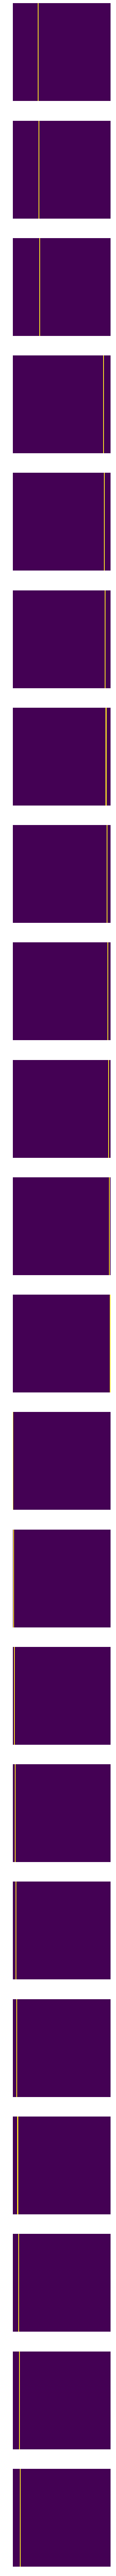

In [32]:
i = 1
fig = plt.figure(figsize=(121,121))
for image in gen_img_temp:
    fig.add_subplot(22, 1, i)
    plt.imshow(image)
    plt.xlim(0, data.shape[-1])
    plt.ylim(0, data.shape[-1])
    plt.axis('off')
    i += 1
plt.show()